In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import glob
import numpy as np
import matplotlib.pyplot as plt

# Define the 2D CNN model in PyTorch
class CNN2D(nn.Module):
    def __init__(self, input_channels):
        super(CNN2D, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 4 * 18, 128)  # Adjust based on input size
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.pool3(x)
        
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [9]:
# Training method for PyTorch
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)
        loss = criterion(outputs, labels.squeeze(1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = torch.sigmoid(outputs) >= 0.5
        correct += (preds == labels.squeeze(1).bool()).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    accuracy = correct / total
    return epoch_loss, accuracy

# Validation function
def validate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels.squeeze(1))
            running_loss += loss.item() * inputs.size(0)
            
            # Compute accuracy
            preds = torch.sigmoid(outputs) >= 0.5
            correct += (preds == labels.squeeze(1).bool()).sum().item()
            total += labels.size(0)
    
    validation_loss = running_loss / total
    accuracy = correct / total
    return validation_loss, accuracy

In [10]:
class GridDataset(Dataset):
    def __init__(self, data_dict):
        self.data = list(data_dict.values())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        grid = sample['grid_tensor']
        label = torch.tensor(sample['label'], dtype=torch.float32)
        return grid, label.unsqueeze(0)

In [11]:
# Create a dictionary with file names as keys and label + tensor grid as values
positive_grids = glob.glob('../../../Data/SplitData/Cholesterol/cholesterol-graph-5A_exp2/PositiveWithoutSpies/*.npy')
validation_grids = glob.glob('../../../Data/SplitData/Cholesterol/cholesterol-graph-5A_exp2/Validation_Set/*.npy')
file_data = {} # format is filename as key, label and grid tensor are values

for file in positive_grids:
    # Load the numpy array and convert it to a PyTorch tensor
    grid = np.load(file)
    grid_tensor = torch.tensor(grid, dtype=torch.float32).unsqueeze(0)  # Adds channel dimension
    file_data[file] = {'label': 1, 'grid_tensor': grid_tensor}
positive_grids = file_data
print(len(positive_grids), "is length of positive")

file_data = {} # format is filename as key, label and grid tensor are values

positive_validation_count = 0
unlabeled_validation_count = 0

for file in validation_grids:
    # Load the numpy array and convert it to a PyTorch tensor
    grid = np.load(file)
    grid_tensor = torch.tensor(grid, dtype=torch.float32).unsqueeze(0)  # Adds channel dimension
    # Label as negative if "-f1" to "-f5" is in the filename
    if any(f"-f{i}" in file for i in range(1, 6)):
        label = 0
        unlabeled_validation_count += 1
    else:
        label = 1
        positive_validation_count += 1

    file_data[file] = {'label': label, 'grid_tensor': grid_tensor}
print("In validation directory there are", positive_validation_count, "positives and", unlabeled_validation_count, "fragments")
validation_grids = file_data
print(len(validation_grids), "is length of validation grids")


file_data = {} # format is filename as key, label and grid tensor are values

k = 50
subset_grids = []
for i in range(1, k + 1):
    file_data = {}
    subset_grid = glob.glob(f'../../../Data/SplitData/Cholesterol/cholesterol-graph-5A_exp2/k_subsets/subset_{i}/*.npy')  # Adjust path as needed
    for file in subset_grid:
        # Load the numpy array and convert it to a PyTorch tensor
        grid = np.load(file)
        grid_tensor = torch.tensor(grid, dtype=torch.float32).unsqueeze(0)  # Adds channel dimension
        file_data[file] = {'label': 0, 'grid_tensor': grid_tensor} # 0 means unlabeled
    subset_grid = file_data
    subset_grids.append(subset_grid)
    print(len(subset_grid), "is length of subset grid")

bins = []
for subset_grid in subset_grids:
    bin = {**positive_grids, **subset_grid} # merged
    bins.append(bin)


385 is length of positive
In validation directory there are 77 positives and 277 fragments
354 is length of validation grids
385 is length of subset grid
385 is length of subset grid
385 is length of subset grid
385 is length of subset grid
385 is length of subset grid
385 is length of subset grid
385 is length of subset grid
385 is length of subset grid
385 is length of subset grid
385 is length of subset grid
385 is length of subset grid
385 is length of subset grid
385 is length of subset grid
385 is length of subset grid
385 is length of subset grid
385 is length of subset grid
385 is length of subset grid
385 is length of subset grid
385 is length of subset grid
385 is length of subset grid
385 is length of subset grid
385 is length of subset grid
385 is length of subset grid
385 is length of subset grid
385 is length of subset grid
385 is length of subset grid
385 is length of subset grid
385 is length of subset grid
385 is length of subset grid
385 is length of subset grid
385 i

In [12]:
def plot_graphs(train_losses, validation_losses, validation_accuracies, learning_rates):
    # Plot Training Loss vs Validation Loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Validation Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Learning Rate
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(learning_rates) + 1), learning_rates, label='Learning Rates', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

In [13]:
import torch
import torch.nn.functional as F

def weighted_positive_loss(y_pred, y_true, lambda_weight=0.01):
    # BCE Loss
    bce_loss = F.binary_cross_entropy(y_pred, y_true)

    # Additional Weighted Positive Term
    positive_mask = (y_true == 1.0).float()
    P = positive_mask.sum()

    if P > 0:
        wp_term = torch.sqrt(
            torch.mean((torch.log(y_pred[positive_mask.bool()] + 1) - torch.log(y_true[positive_mask.bool()] + 1)) ** 2)
        )
    else:
        wp_term = torch.tensor(0.0, device=y_pred.device)

    total_loss = bce_loss + lambda_weight * wp_term
    return total_loss


Using 4 GPUs
Training on bin 1/50
Bin 1, Epoch 1/2000, Train Loss: 0.6724, Validation Loss: 0.7234,  Accuracy: 0.5818, LR: 0.000001
Bin 1, Epoch 101/2000, Train Loss: 0.3884, Validation Loss: 0.2462,  Accuracy: 0.8286, LR: 0.000001
Bin 1, Epoch 201/2000, Train Loss: 0.3557, Validation Loss: 0.2329,  Accuracy: 0.8571, LR: 0.000001
Bin 1, Epoch 301/2000, Train Loss: 0.3210, Validation Loss: 0.2080,  Accuracy: 0.8662, LR: 0.000001
Bin 1, Epoch 401/2000, Train Loss: 0.3018, Validation Loss: 0.2170,  Accuracy: 0.8753, LR: 0.000001
Bin 1, Epoch 501/2000, Train Loss: 0.2833, Validation Loss: 0.1979,  Accuracy: 0.8870, LR: 0.000001
Bin 1, Epoch 601/2000, Train Loss: 0.2684, Validation Loss: 0.2017,  Accuracy: 0.8974, LR: 0.000001
Bin 1, Epoch 701/2000, Train Loss: 0.2539, Validation Loss: 0.1895,  Accuracy: 0.9026, LR: 0.000001
Bin 1, Epoch 801/2000, Train Loss: 0.2262, Validation Loss: 0.1875,  Accuracy: 0.9143, LR: 0.000001
Bin 1, Epoch 901/2000, Train Loss: 0.2170, Validation Loss: 0.1878, 

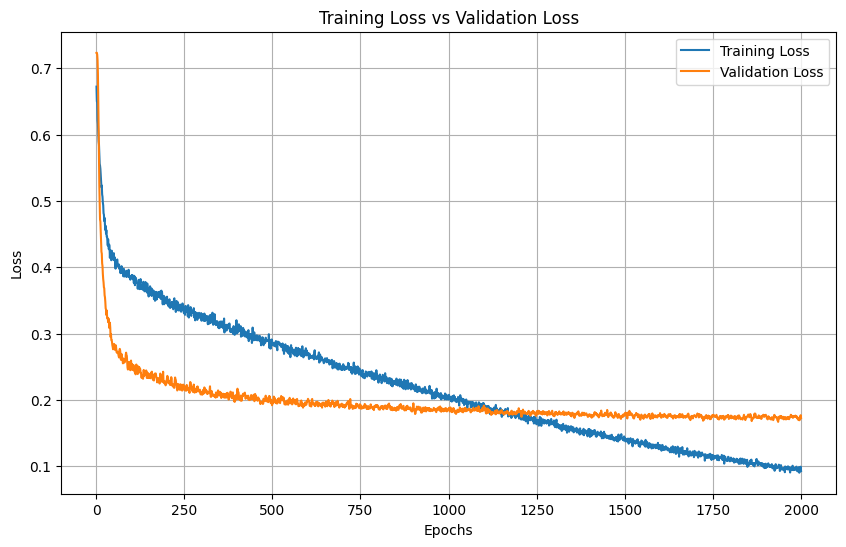

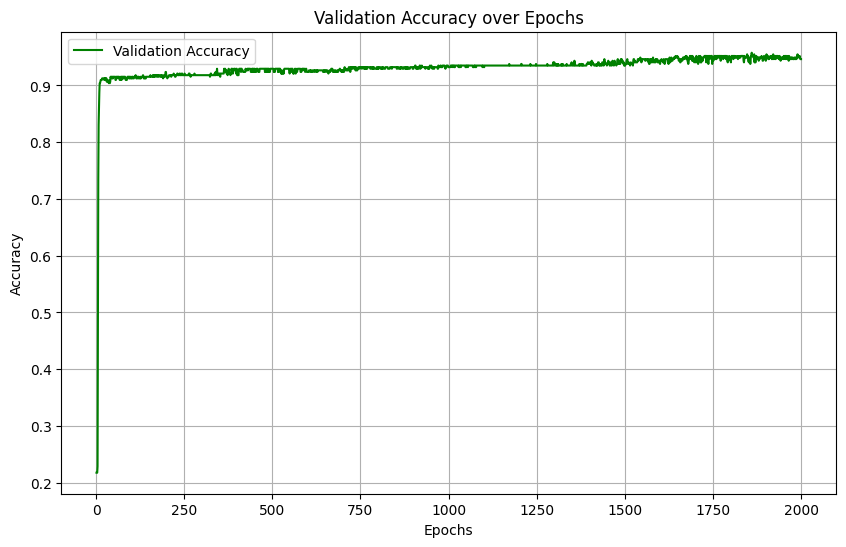

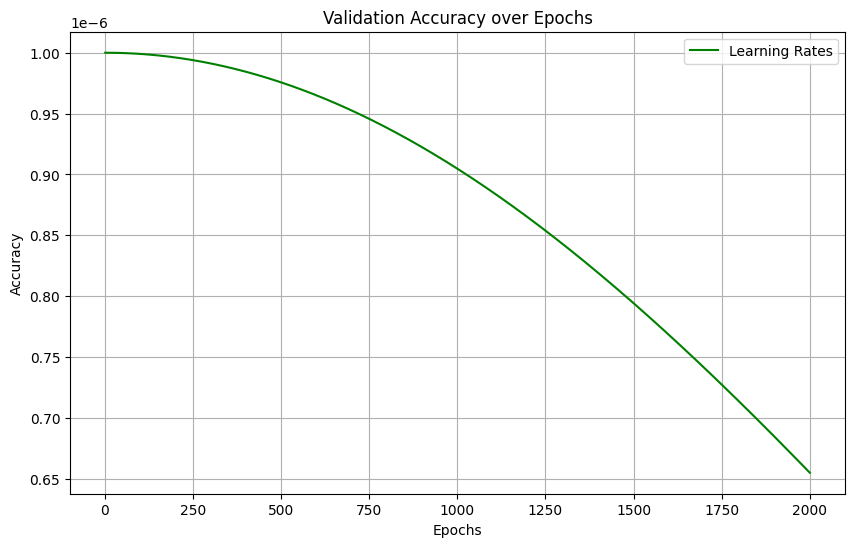

Model for bin 1 saved to GNN-5A_Exp2/model_bin_1.pth
Using 4 GPUs
Training on bin 2/50
Bin 2, Epoch 1/2000, Train Loss: 0.6521, Validation Loss: 0.6639,  Accuracy: 0.5701, LR: 0.000001
Bin 2, Epoch 101/2000, Train Loss: 0.4043, Validation Loss: 0.2511,  Accuracy: 0.8416, LR: 0.000001
Bin 2, Epoch 201/2000, Train Loss: 0.3534, Validation Loss: 0.2309,  Accuracy: 0.8442, LR: 0.000001
Bin 2, Epoch 301/2000, Train Loss: 0.3270, Validation Loss: 0.2268,  Accuracy: 0.8649, LR: 0.000001
Bin 2, Epoch 401/2000, Train Loss: 0.3080, Validation Loss: 0.2116,  Accuracy: 0.8688, LR: 0.000001
Bin 2, Epoch 501/2000, Train Loss: 0.2867, Validation Loss: 0.2081,  Accuracy: 0.8987, LR: 0.000001
Bin 2, Epoch 601/2000, Train Loss: 0.2652, Validation Loss: 0.1943,  Accuracy: 0.8883, LR: 0.000001
Bin 2, Epoch 701/2000, Train Loss: 0.2525, Validation Loss: 0.1916,  Accuracy: 0.9039, LR: 0.000001
Bin 2, Epoch 801/2000, Train Loss: 0.2315, Validation Loss: 0.1957,  Accuracy: 0.9182, LR: 0.000001
Bin 2, Epoch 90

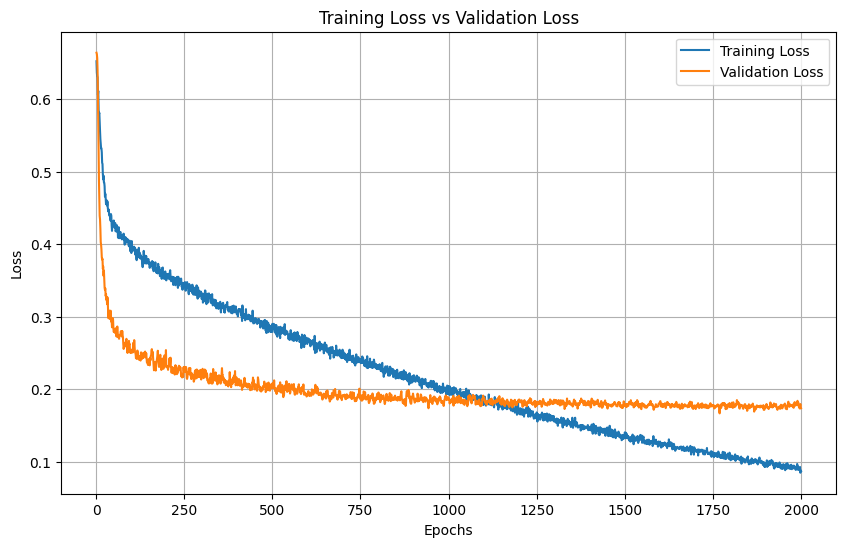

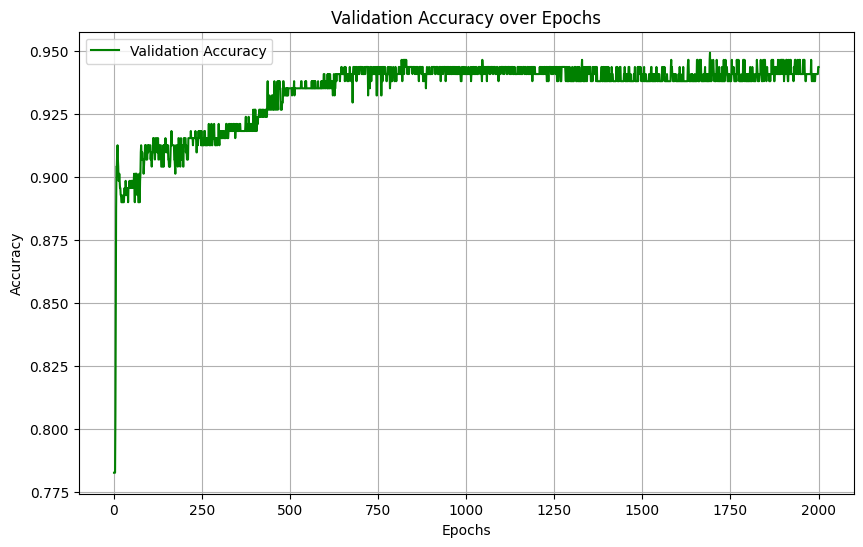

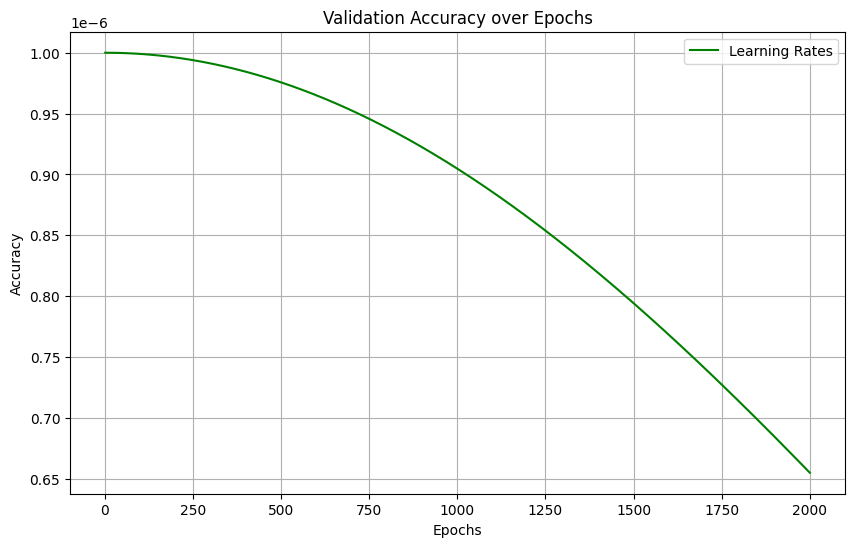

Model for bin 2 saved to GNN-5A_Exp2/model_bin_2.pth
Using 4 GPUs
Training on bin 3/50
Bin 3, Epoch 1/2000, Train Loss: 0.6686, Validation Loss: 0.6792,  Accuracy: 0.5636, LR: 0.000001
Bin 3, Epoch 101/2000, Train Loss: 0.3551, Validation Loss: 0.2614,  Accuracy: 0.8506, LR: 0.000001
Bin 3, Epoch 201/2000, Train Loss: 0.3093, Validation Loss: 0.2352,  Accuracy: 0.8623, LR: 0.000001
Bin 3, Epoch 301/2000, Train Loss: 0.2819, Validation Loss: 0.2103,  Accuracy: 0.8922, LR: 0.000001
Bin 3, Epoch 401/2000, Train Loss: 0.2730, Validation Loss: 0.2071,  Accuracy: 0.8909, LR: 0.000001
Bin 3, Epoch 501/2000, Train Loss: 0.2425, Validation Loss: 0.2030,  Accuracy: 0.9065, LR: 0.000001
Bin 3, Epoch 601/2000, Train Loss: 0.2275, Validation Loss: 0.1987,  Accuracy: 0.9104, LR: 0.000001
Bin 3, Epoch 701/2000, Train Loss: 0.2044, Validation Loss: 0.1894,  Accuracy: 0.9221, LR: 0.000001
Bin 3, Epoch 801/2000, Train Loss: 0.1882, Validation Loss: 0.1944,  Accuracy: 0.9325, LR: 0.000001
Bin 3, Epoch 90

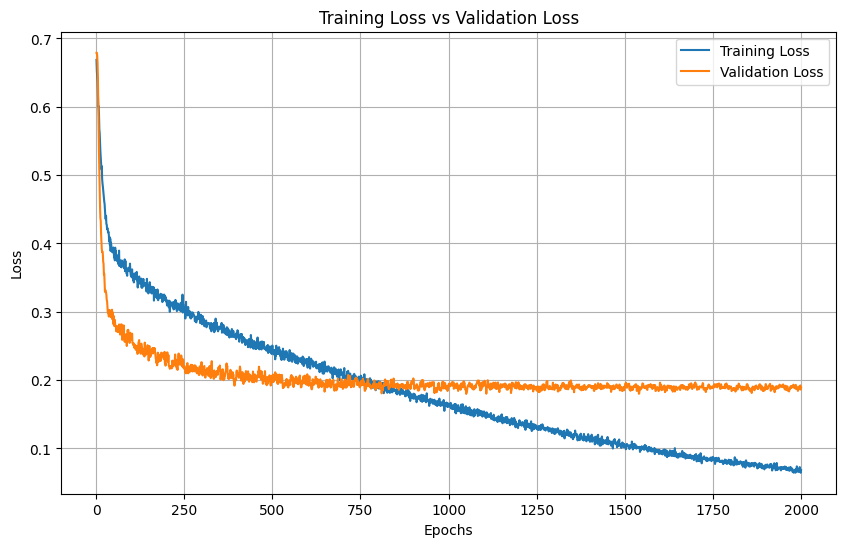

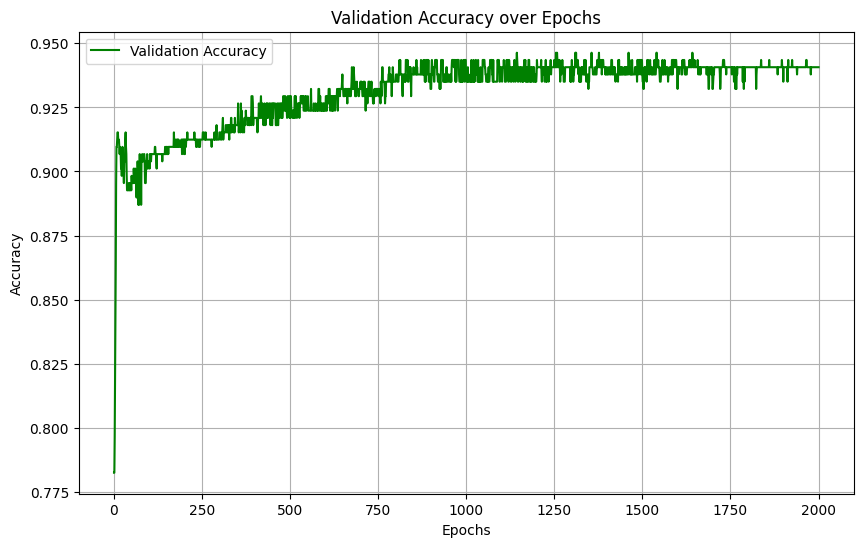

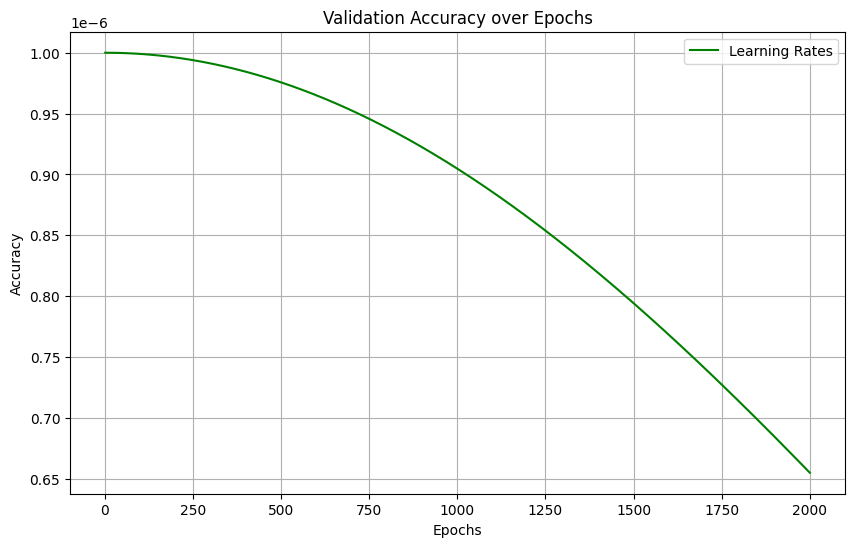

Model for bin 3 saved to GNN-5A_Exp2/model_bin_3.pth
Using 4 GPUs
Training on bin 4/50
Bin 4, Epoch 1/2000, Train Loss: 0.7020, Validation Loss: 0.7136,  Accuracy: 0.5273, LR: 0.000001
Bin 4, Epoch 101/2000, Train Loss: 0.3862, Validation Loss: 0.2603,  Accuracy: 0.8351, LR: 0.000001
Bin 4, Epoch 201/2000, Train Loss: 0.3474, Validation Loss: 0.2203,  Accuracy: 0.8584, LR: 0.000001
Bin 4, Epoch 301/2000, Train Loss: 0.3109, Validation Loss: 0.2143,  Accuracy: 0.8792, LR: 0.000001
Bin 4, Epoch 401/2000, Train Loss: 0.2795, Validation Loss: 0.2081,  Accuracy: 0.8987, LR: 0.000001
Bin 4, Epoch 501/2000, Train Loss: 0.2686, Validation Loss: 0.1942,  Accuracy: 0.9013, LR: 0.000001
Bin 4, Epoch 601/2000, Train Loss: 0.2573, Validation Loss: 0.1969,  Accuracy: 0.9000, LR: 0.000001
Bin 4, Epoch 701/2000, Train Loss: 0.2343, Validation Loss: 0.1879,  Accuracy: 0.9143, LR: 0.000001
Bin 4, Epoch 801/2000, Train Loss: 0.2175, Validation Loss: 0.1910,  Accuracy: 0.9208, LR: 0.000001
Bin 4, Epoch 90

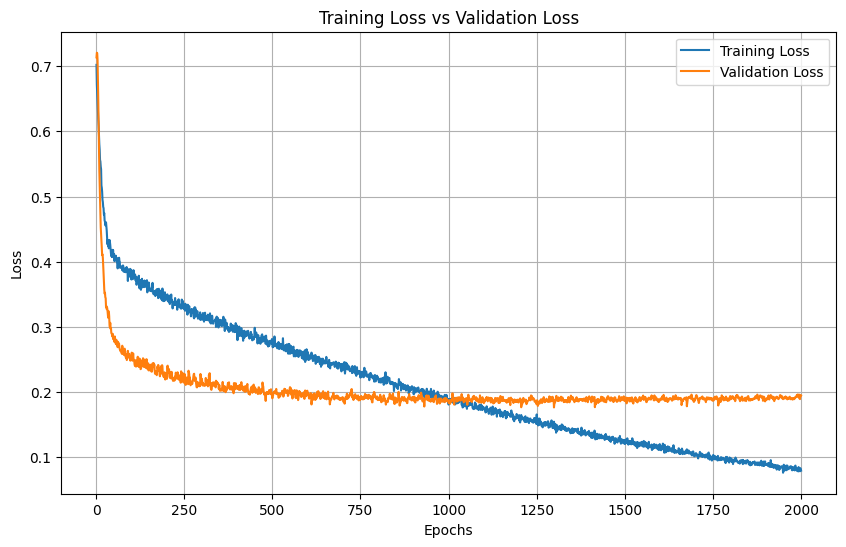

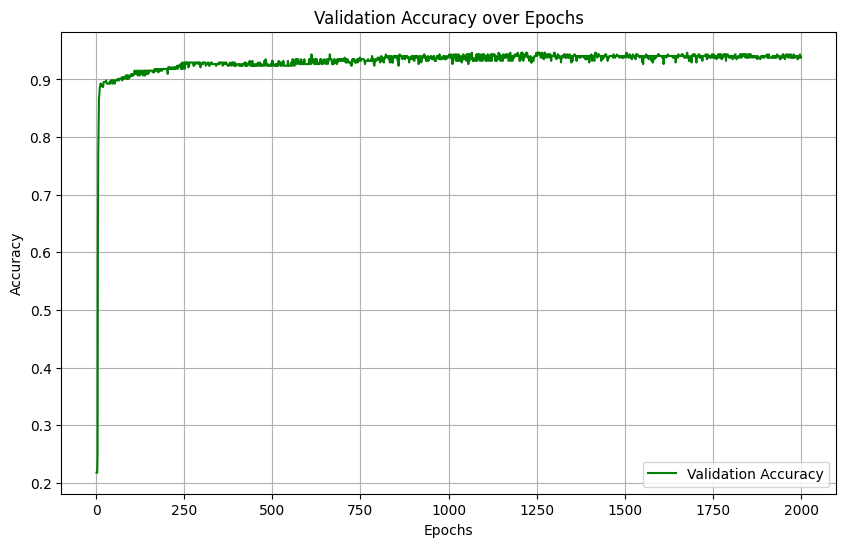

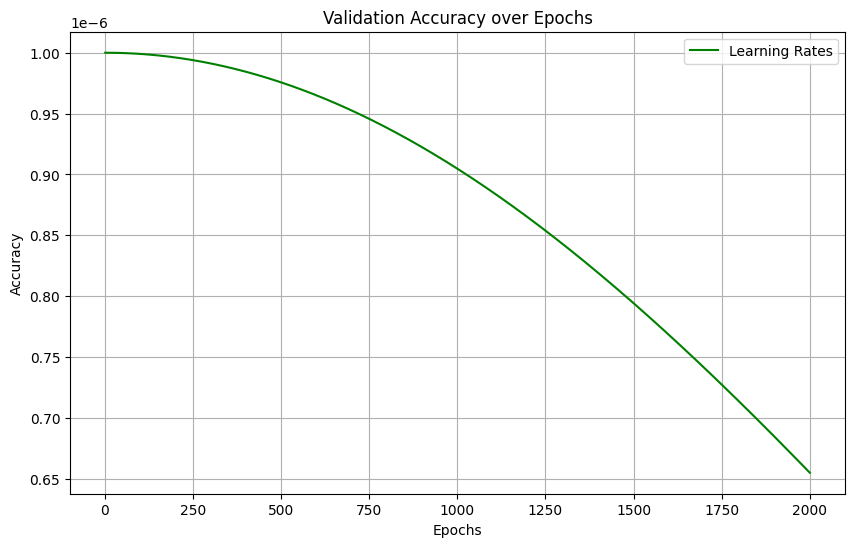

Model for bin 4 saved to GNN-5A_Exp2/model_bin_4.pth
Using 4 GPUs
Training on bin 5/50
Bin 5, Epoch 1/2000, Train Loss: 0.6780, Validation Loss: 0.7049,  Accuracy: 0.5896, LR: 0.000001
Bin 5, Epoch 101/2000, Train Loss: 0.3943, Validation Loss: 0.2709,  Accuracy: 0.8312, LR: 0.000001
Bin 5, Epoch 201/2000, Train Loss: 0.3534, Validation Loss: 0.2442,  Accuracy: 0.8532, LR: 0.000001
Bin 5, Epoch 301/2000, Train Loss: 0.3328, Validation Loss: 0.2227,  Accuracy: 0.8597, LR: 0.000001
Bin 5, Epoch 401/2000, Train Loss: 0.3075, Validation Loss: 0.2215,  Accuracy: 0.8779, LR: 0.000001
Bin 5, Epoch 501/2000, Train Loss: 0.2883, Validation Loss: 0.2085,  Accuracy: 0.8935, LR: 0.000001
Bin 5, Epoch 601/2000, Train Loss: 0.2608, Validation Loss: 0.2010,  Accuracy: 0.9000, LR: 0.000001
Bin 5, Epoch 701/2000, Train Loss: 0.2556, Validation Loss: 0.1984,  Accuracy: 0.9000, LR: 0.000001
Bin 5, Epoch 801/2000, Train Loss: 0.2359, Validation Loss: 0.1934,  Accuracy: 0.9169, LR: 0.000001
Bin 5, Epoch 90

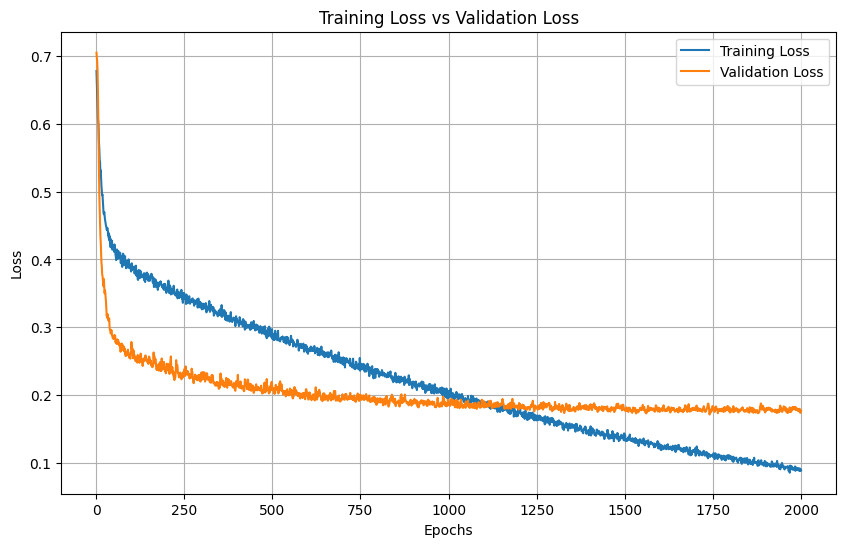

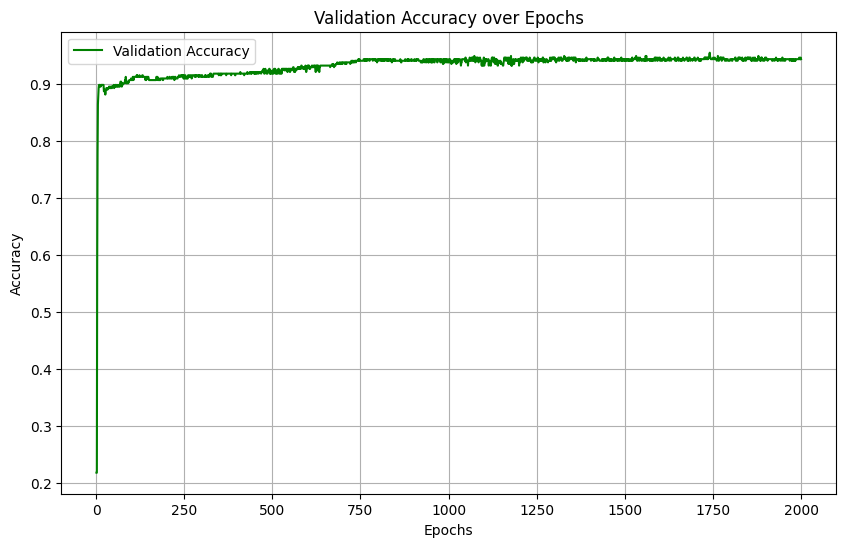

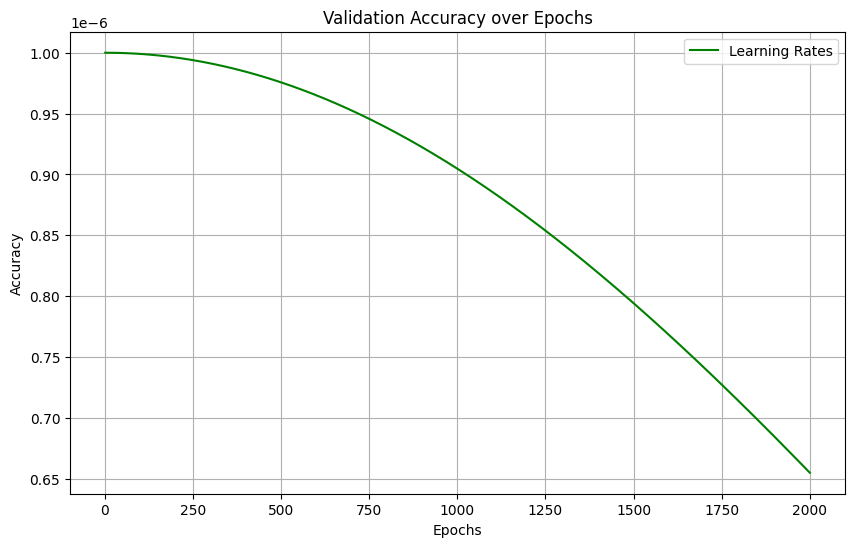

Model for bin 5 saved to GNN-5A_Exp2/model_bin_5.pth
Using 4 GPUs
Training on bin 6/50
Bin 6, Epoch 1/2000, Train Loss: 0.7067, Validation Loss: 0.6912,  Accuracy: 0.4805, LR: 0.000001
Bin 6, Epoch 101/2000, Train Loss: 0.3573, Validation Loss: 0.2652,  Accuracy: 0.8494, LR: 0.000001
Bin 6, Epoch 201/2000, Train Loss: 0.3237, Validation Loss: 0.2324,  Accuracy: 0.8623, LR: 0.000001
Bin 6, Epoch 301/2000, Train Loss: 0.3021, Validation Loss: 0.2160,  Accuracy: 0.8766, LR: 0.000001
Bin 6, Epoch 401/2000, Train Loss: 0.2717, Validation Loss: 0.2147,  Accuracy: 0.8909, LR: 0.000001
Bin 6, Epoch 501/2000, Train Loss: 0.2508, Validation Loss: 0.2071,  Accuracy: 0.9104, LR: 0.000001
Bin 6, Epoch 601/2000, Train Loss: 0.2328, Validation Loss: 0.1936,  Accuracy: 0.9169, LR: 0.000001
Bin 6, Epoch 701/2000, Train Loss: 0.2233, Validation Loss: 0.1930,  Accuracy: 0.9325, LR: 0.000001
Bin 6, Epoch 801/2000, Train Loss: 0.2042, Validation Loss: 0.1928,  Accuracy: 0.9325, LR: 0.000001
Bin 6, Epoch 90

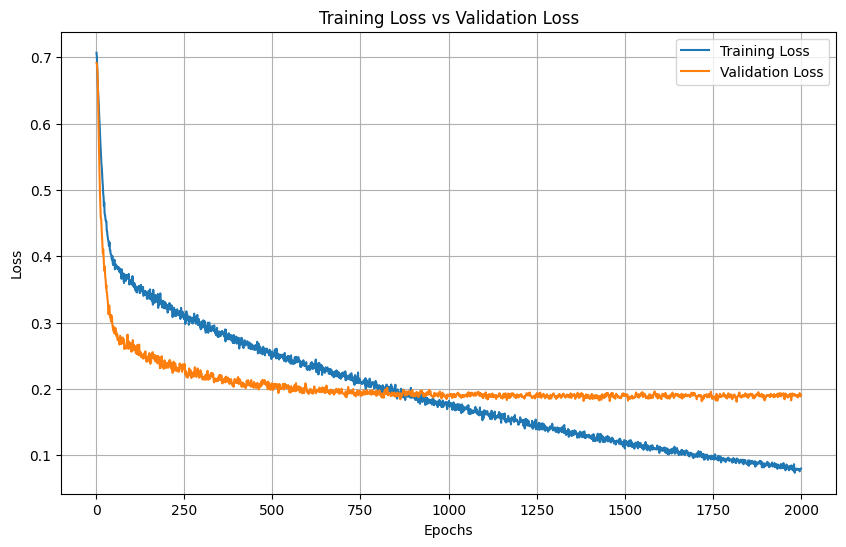

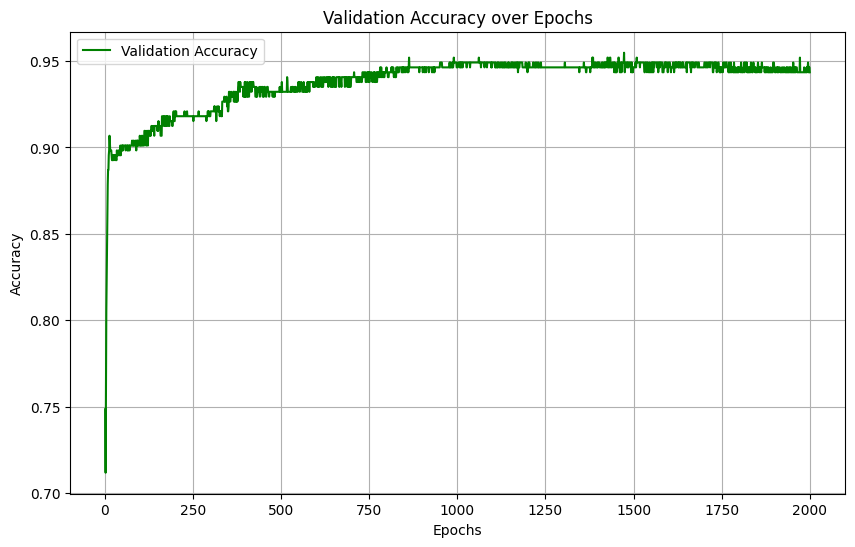

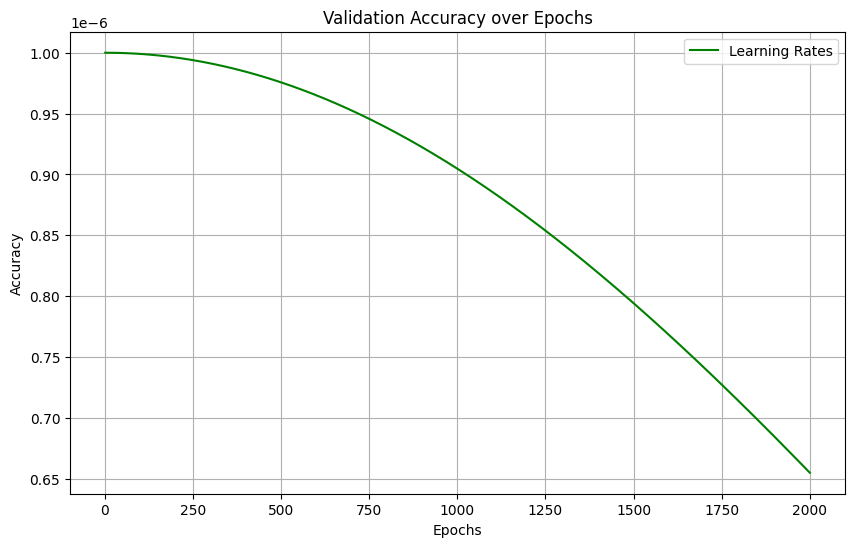

Model for bin 6 saved to GNN-5A_Exp2/model_bin_6.pth
Using 4 GPUs
Training on bin 7/50
Bin 7, Epoch 1/2000, Train Loss: 0.7076, Validation Loss: 0.6684,  Accuracy: 0.4948, LR: 0.000001
Bin 7, Epoch 101/2000, Train Loss: 0.3572, Validation Loss: 0.2717,  Accuracy: 0.8429, LR: 0.000001
Bin 7, Epoch 201/2000, Train Loss: 0.3292, Validation Loss: 0.2409,  Accuracy: 0.8558, LR: 0.000001
Bin 7, Epoch 301/2000, Train Loss: 0.3015, Validation Loss: 0.2333,  Accuracy: 0.8857, LR: 0.000001
Bin 7, Epoch 401/2000, Train Loss: 0.2688, Validation Loss: 0.2109,  Accuracy: 0.8974, LR: 0.000001
Bin 7, Epoch 501/2000, Train Loss: 0.2533, Validation Loss: 0.2149,  Accuracy: 0.8974, LR: 0.000001
Bin 7, Epoch 601/2000, Train Loss: 0.2399, Validation Loss: 0.1982,  Accuracy: 0.9104, LR: 0.000001
Bin 7, Epoch 701/2000, Train Loss: 0.2187, Validation Loss: 0.1942,  Accuracy: 0.9247, LR: 0.000001
Bin 7, Epoch 801/2000, Train Loss: 0.2041, Validation Loss: 0.1929,  Accuracy: 0.9325, LR: 0.000001
Bin 7, Epoch 90

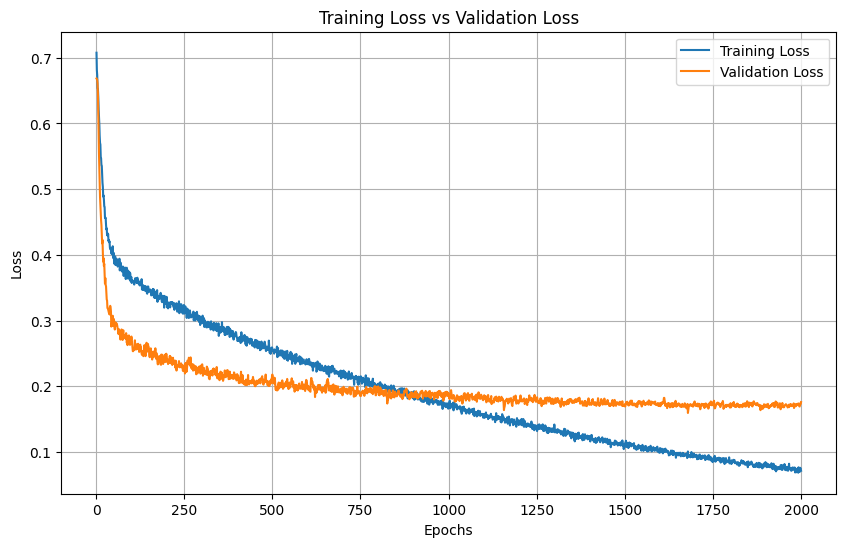

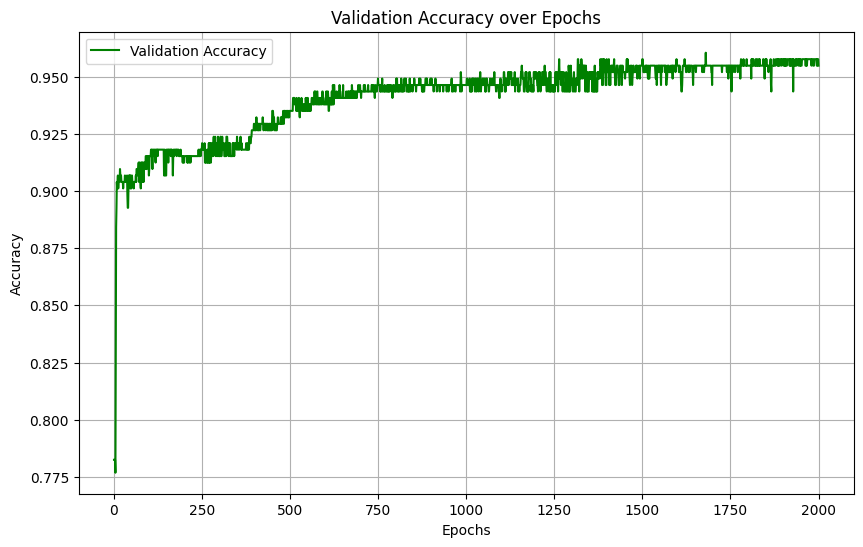

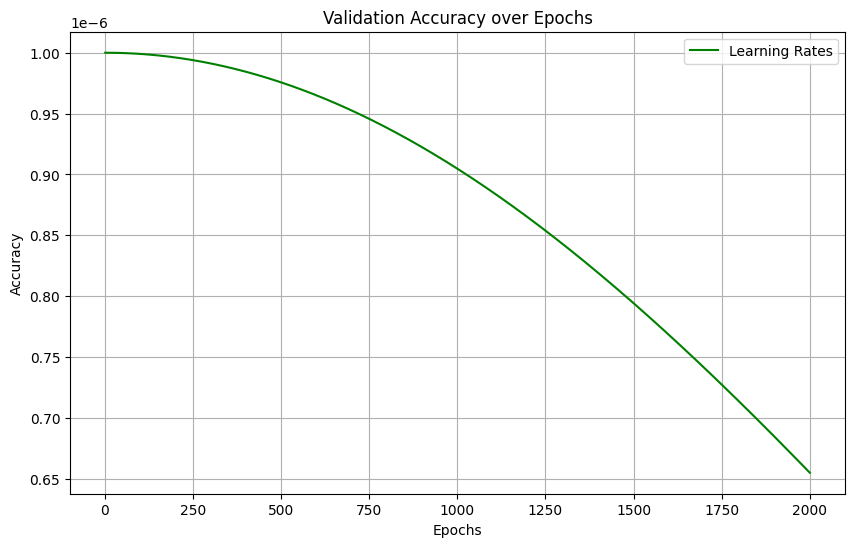

Model for bin 7 saved to GNN-5A_Exp2/model_bin_7.pth
Using 4 GPUs
Training on bin 8/50
Bin 8, Epoch 1/2000, Train Loss: 0.7079, Validation Loss: 0.6999,  Accuracy: 0.5442, LR: 0.000001
Bin 8, Epoch 101/2000, Train Loss: 0.3699, Validation Loss: 0.2694,  Accuracy: 0.8468, LR: 0.000001
Bin 8, Epoch 201/2000, Train Loss: 0.3348, Validation Loss: 0.2362,  Accuracy: 0.8597, LR: 0.000001
Bin 8, Epoch 301/2000, Train Loss: 0.3166, Validation Loss: 0.2203,  Accuracy: 0.8740, LR: 0.000001
Bin 8, Epoch 401/2000, Train Loss: 0.2899, Validation Loss: 0.2165,  Accuracy: 0.8896, LR: 0.000001
Bin 8, Epoch 501/2000, Train Loss: 0.2684, Validation Loss: 0.2010,  Accuracy: 0.8961, LR: 0.000001
Bin 8, Epoch 601/2000, Train Loss: 0.2572, Validation Loss: 0.1988,  Accuracy: 0.9065, LR: 0.000001
Bin 8, Epoch 701/2000, Train Loss: 0.2466, Validation Loss: 0.1999,  Accuracy: 0.9130, LR: 0.000001
Bin 8, Epoch 801/2000, Train Loss: 0.2257, Validation Loss: 0.1921,  Accuracy: 0.9182, LR: 0.000001
Bin 8, Epoch 90

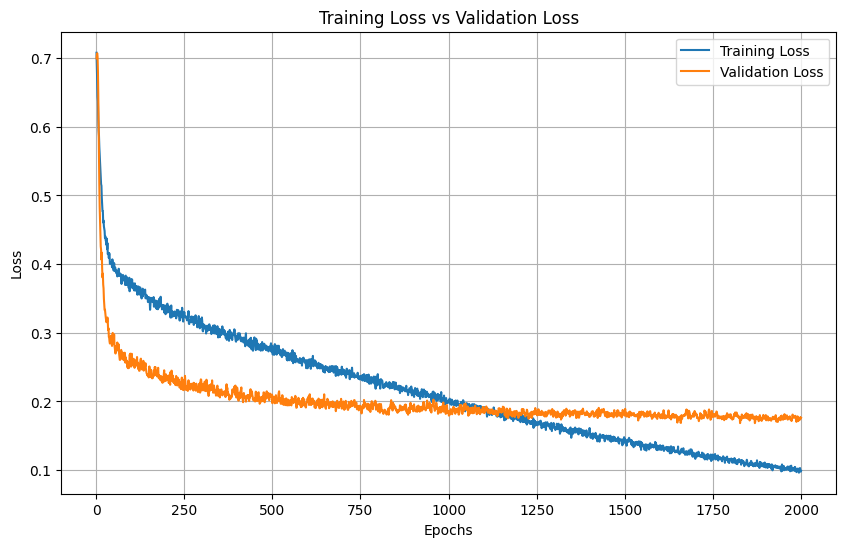

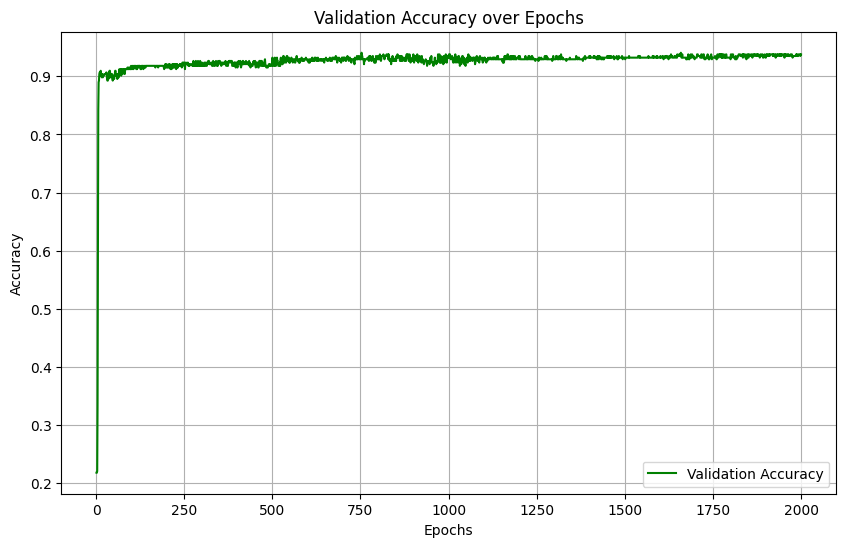

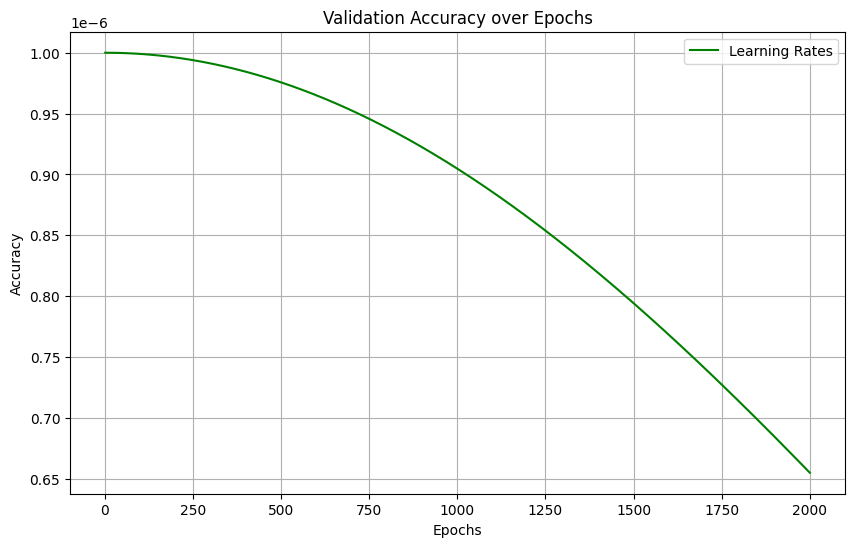

Model for bin 8 saved to GNN-5A_Exp2/model_bin_8.pth
Using 4 GPUs
Training on bin 9/50
Bin 9, Epoch 1/2000, Train Loss: 0.7205, Validation Loss: 0.6995,  Accuracy: 0.4870, LR: 0.000001
Bin 9, Epoch 101/2000, Train Loss: 0.3918, Validation Loss: 0.2876,  Accuracy: 0.8325, LR: 0.000001
Bin 9, Epoch 201/2000, Train Loss: 0.3496, Validation Loss: 0.2577,  Accuracy: 0.8571, LR: 0.000001
Bin 9, Epoch 301/2000, Train Loss: 0.3255, Validation Loss: 0.2302,  Accuracy: 0.8740, LR: 0.000001
Bin 9, Epoch 401/2000, Train Loss: 0.3112, Validation Loss: 0.2194,  Accuracy: 0.8714, LR: 0.000001
Bin 9, Epoch 501/2000, Train Loss: 0.2933, Validation Loss: 0.2115,  Accuracy: 0.8896, LR: 0.000001
Bin 9, Epoch 601/2000, Train Loss: 0.2764, Validation Loss: 0.2164,  Accuracy: 0.8961, LR: 0.000001
Bin 9, Epoch 701/2000, Train Loss: 0.2580, Validation Loss: 0.2096,  Accuracy: 0.8987, LR: 0.000001
Bin 9, Epoch 801/2000, Train Loss: 0.2458, Validation Loss: 0.2121,  Accuracy: 0.9065, LR: 0.000001
Bin 9, Epoch 90

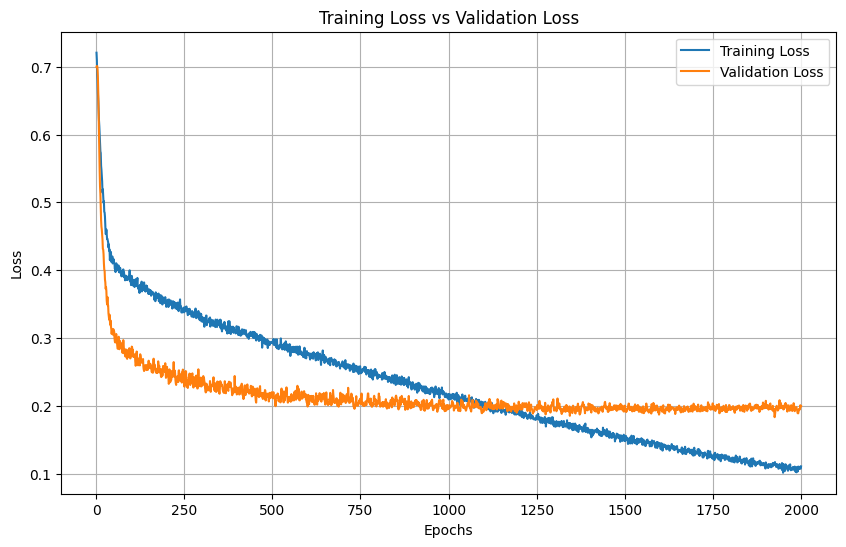

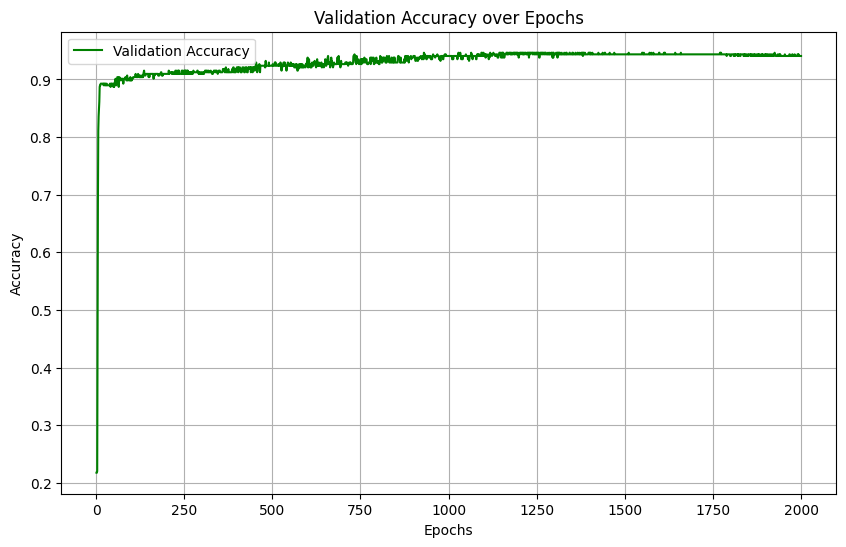

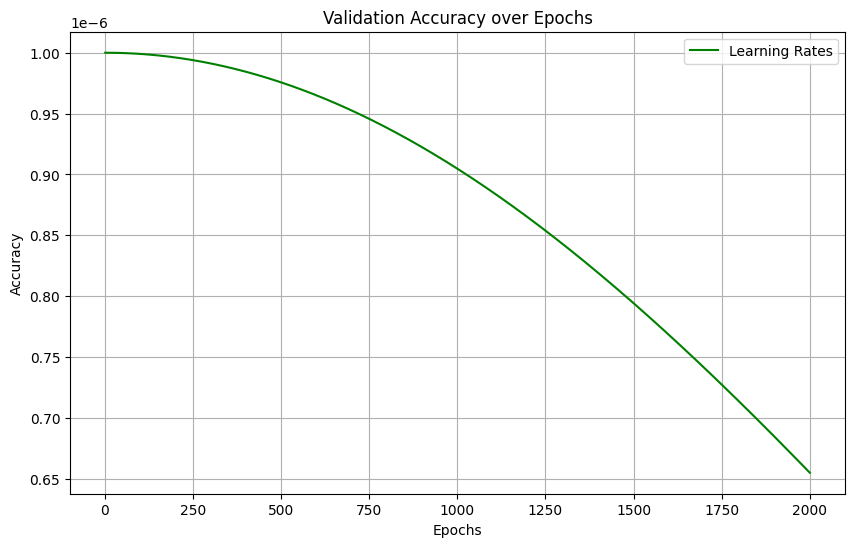

Model for bin 9 saved to GNN-5A_Exp2/model_bin_9.pth
Using 4 GPUs
Training on bin 10/50
Bin 10, Epoch 1/2000, Train Loss: 0.7417, Validation Loss: 0.6996,  Accuracy: 0.4169, LR: 0.000001
Bin 10, Epoch 101/2000, Train Loss: 0.3758, Validation Loss: 0.2537,  Accuracy: 0.8481, LR: 0.000001
Bin 10, Epoch 201/2000, Train Loss: 0.3534, Validation Loss: 0.2445,  Accuracy: 0.8584, LR: 0.000001
Bin 10, Epoch 301/2000, Train Loss: 0.3274, Validation Loss: 0.2205,  Accuracy: 0.8636, LR: 0.000001
Bin 10, Epoch 401/2000, Train Loss: 0.3016, Validation Loss: 0.2093,  Accuracy: 0.8766, LR: 0.000001
Bin 10, Epoch 501/2000, Train Loss: 0.2891, Validation Loss: 0.2110,  Accuracy: 0.8883, LR: 0.000001
Bin 10, Epoch 601/2000, Train Loss: 0.2713, Validation Loss: 0.2112,  Accuracy: 0.8948, LR: 0.000001
Bin 10, Epoch 701/2000, Train Loss: 0.2572, Validation Loss: 0.2024,  Accuracy: 0.9117, LR: 0.000001
Bin 10, Epoch 801/2000, Train Loss: 0.2399, Validation Loss: 0.1979,  Accuracy: 0.9156, LR: 0.000001
Bin 1

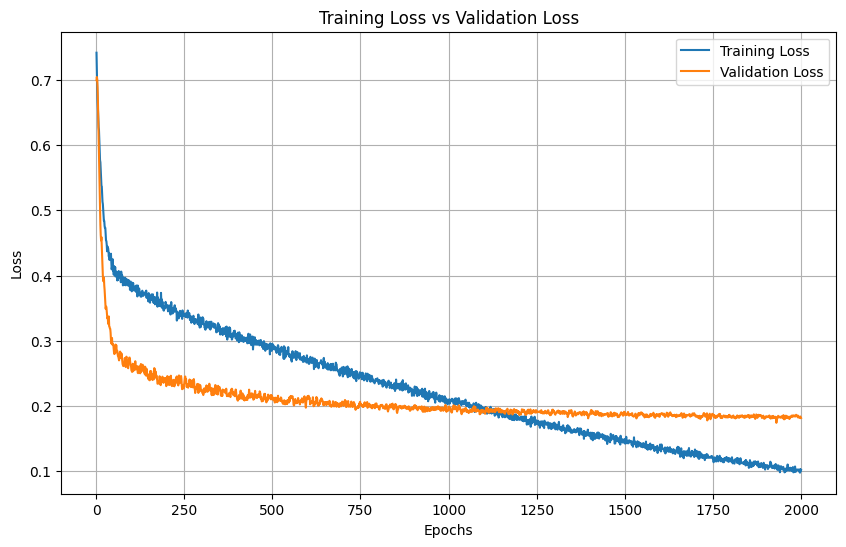

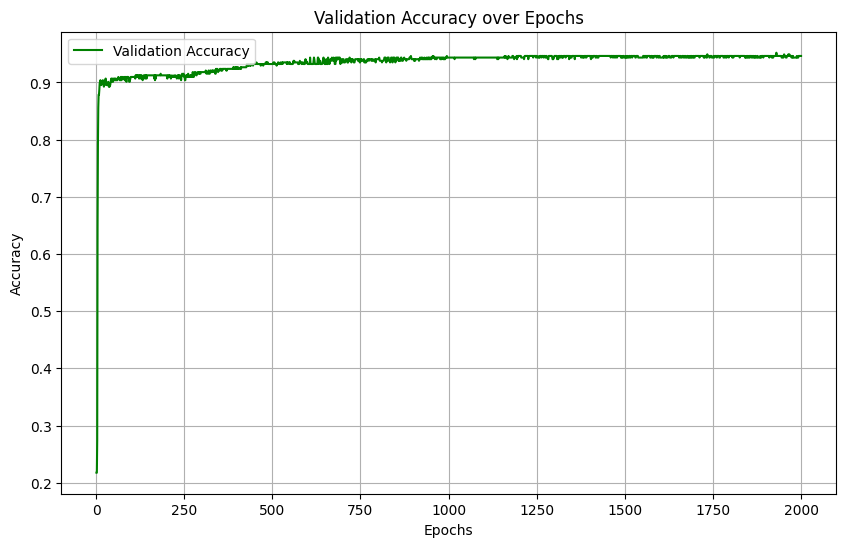

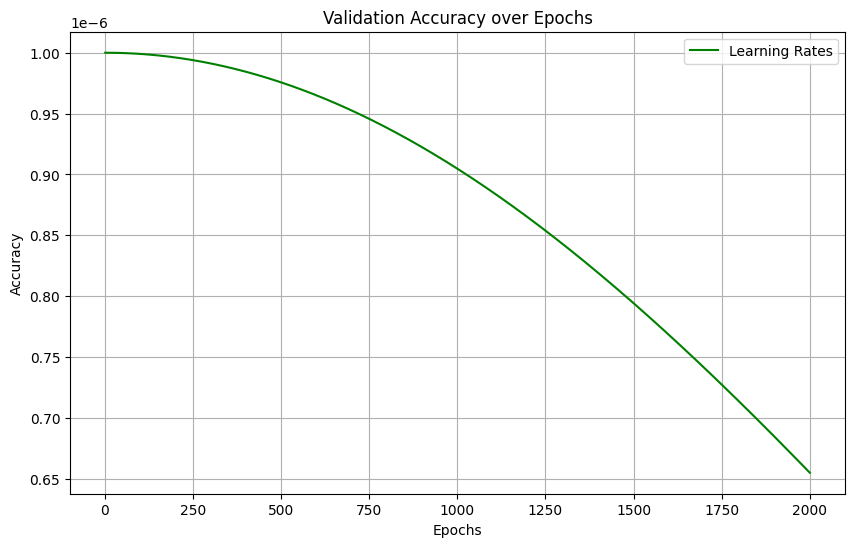

Model for bin 10 saved to GNN-5A_Exp2/model_bin_10.pth
Using 4 GPUs
Training on bin 11/50
Bin 11, Epoch 1/2000, Train Loss: 0.7509, Validation Loss: 0.7099,  Accuracy: 0.4247, LR: 0.000001
Bin 11, Epoch 101/2000, Train Loss: 0.3766, Validation Loss: 0.2640,  Accuracy: 0.8416, LR: 0.000001
Bin 11, Epoch 201/2000, Train Loss: 0.3442, Validation Loss: 0.2439,  Accuracy: 0.8494, LR: 0.000001
Bin 11, Epoch 301/2000, Train Loss: 0.3167, Validation Loss: 0.2292,  Accuracy: 0.8623, LR: 0.000001
Bin 11, Epoch 401/2000, Train Loss: 0.2926, Validation Loss: 0.2169,  Accuracy: 0.8727, LR: 0.000001
Bin 11, Epoch 501/2000, Train Loss: 0.2679, Validation Loss: 0.2087,  Accuracy: 0.8935, LR: 0.000001
Bin 11, Epoch 601/2000, Train Loss: 0.2512, Validation Loss: 0.2004,  Accuracy: 0.9000, LR: 0.000001
Bin 11, Epoch 701/2000, Train Loss: 0.2434, Validation Loss: 0.1974,  Accuracy: 0.9091, LR: 0.000001
Bin 11, Epoch 801/2000, Train Loss: 0.2205, Validation Loss: 0.2002,  Accuracy: 0.9208, LR: 0.000001
Bin

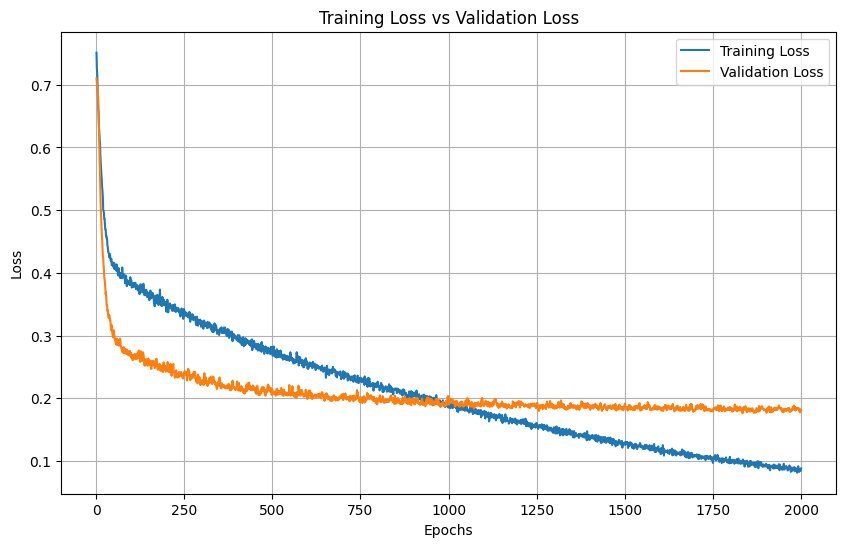

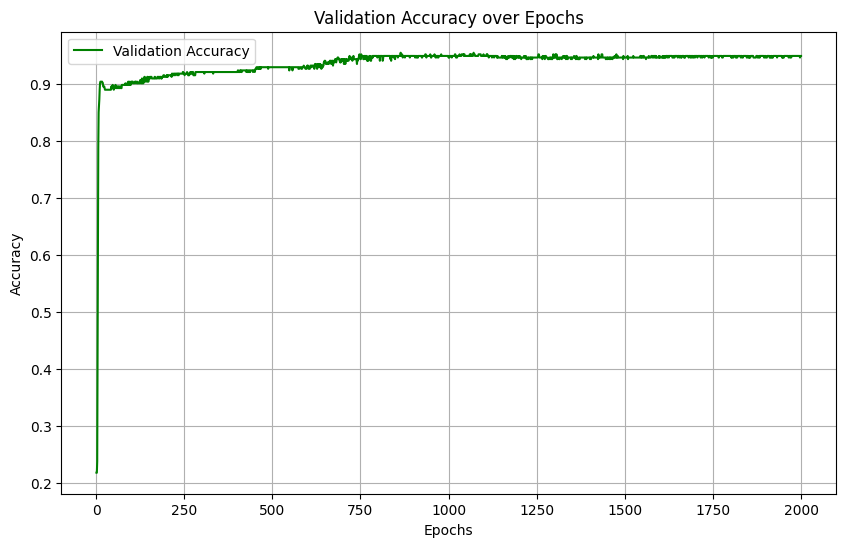

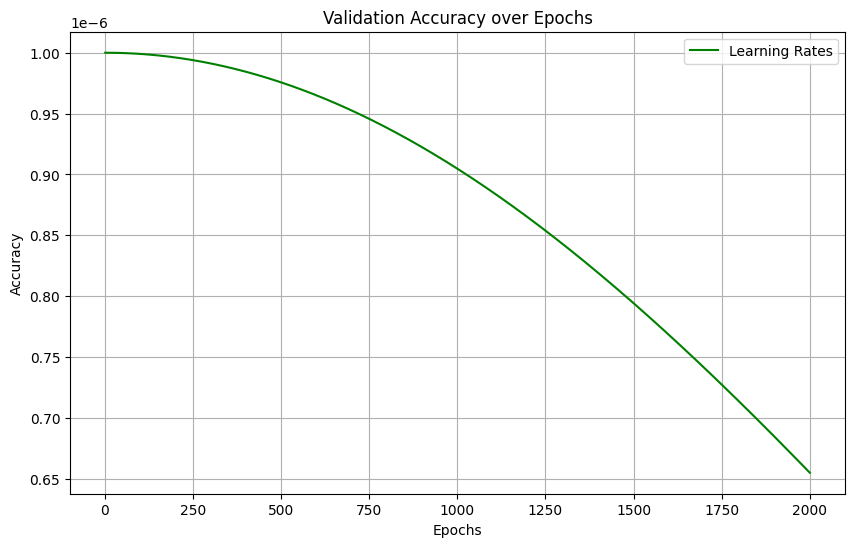

Model for bin 11 saved to GNN-5A_Exp2/model_bin_11.pth
Using 4 GPUs
Training on bin 12/50
Bin 12, Epoch 1/2000, Train Loss: 0.6919, Validation Loss: 0.7185,  Accuracy: 0.5377, LR: 0.000001
Bin 12, Epoch 101/2000, Train Loss: 0.3629, Validation Loss: 0.2642,  Accuracy: 0.8506, LR: 0.000001
Bin 12, Epoch 201/2000, Train Loss: 0.3218, Validation Loss: 0.2387,  Accuracy: 0.8662, LR: 0.000001
Bin 12, Epoch 301/2000, Train Loss: 0.3014, Validation Loss: 0.2218,  Accuracy: 0.8740, LR: 0.000001
Bin 12, Epoch 401/2000, Train Loss: 0.2837, Validation Loss: 0.2173,  Accuracy: 0.8857, LR: 0.000001
Bin 12, Epoch 501/2000, Train Loss: 0.2548, Validation Loss: 0.2076,  Accuracy: 0.9078, LR: 0.000001
Bin 12, Epoch 601/2000, Train Loss: 0.2390, Validation Loss: 0.2061,  Accuracy: 0.9156, LR: 0.000001
Bin 12, Epoch 701/2000, Train Loss: 0.2220, Validation Loss: 0.1935,  Accuracy: 0.9234, LR: 0.000001
Bin 12, Epoch 801/2000, Train Loss: 0.2114, Validation Loss: 0.1944,  Accuracy: 0.9273, LR: 0.000001
Bin

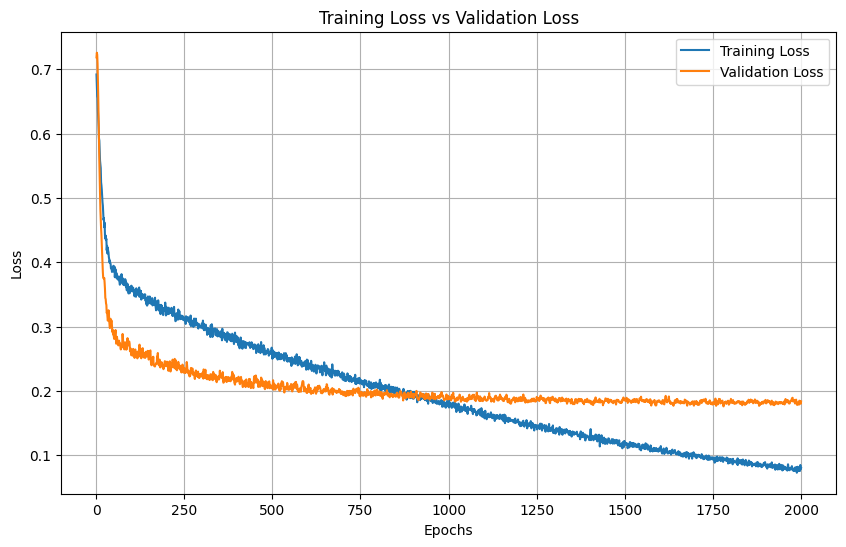

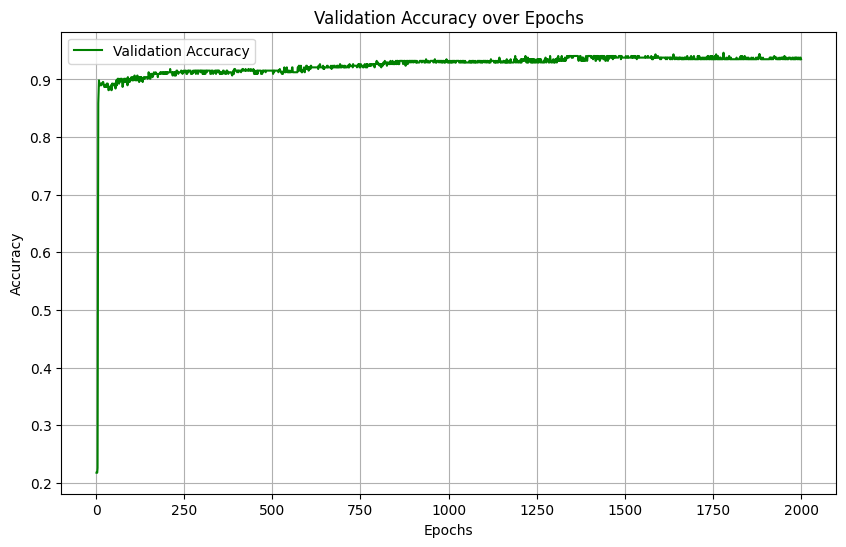

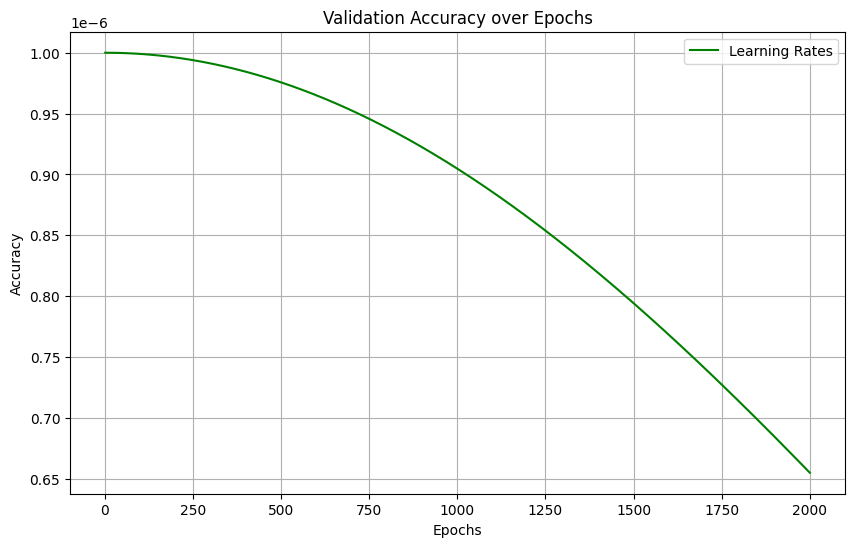

Model for bin 12 saved to GNN-5A_Exp2/model_bin_12.pth
Using 4 GPUs
Training on bin 13/50
Bin 13, Epoch 1/2000, Train Loss: 0.7171, Validation Loss: 0.6786,  Accuracy: 0.4558, LR: 0.000001
Bin 13, Epoch 101/2000, Train Loss: 0.3975, Validation Loss: 0.2676,  Accuracy: 0.8247, LR: 0.000001
Bin 13, Epoch 201/2000, Train Loss: 0.3541, Validation Loss: 0.2388,  Accuracy: 0.8455, LR: 0.000001
Bin 13, Epoch 301/2000, Train Loss: 0.3285, Validation Loss: 0.2298,  Accuracy: 0.8675, LR: 0.000001
Bin 13, Epoch 401/2000, Train Loss: 0.3018, Validation Loss: 0.2107,  Accuracy: 0.8727, LR: 0.000001
Bin 13, Epoch 501/2000, Train Loss: 0.2757, Validation Loss: 0.2153,  Accuracy: 0.8909, LR: 0.000001
Bin 13, Epoch 601/2000, Train Loss: 0.2578, Validation Loss: 0.2030,  Accuracy: 0.9078, LR: 0.000001
Bin 13, Epoch 701/2000, Train Loss: 0.2387, Validation Loss: 0.1975,  Accuracy: 0.9117, LR: 0.000001
Bin 13, Epoch 801/2000, Train Loss: 0.2243, Validation Loss: 0.1916,  Accuracy: 0.9208, LR: 0.000001
Bin

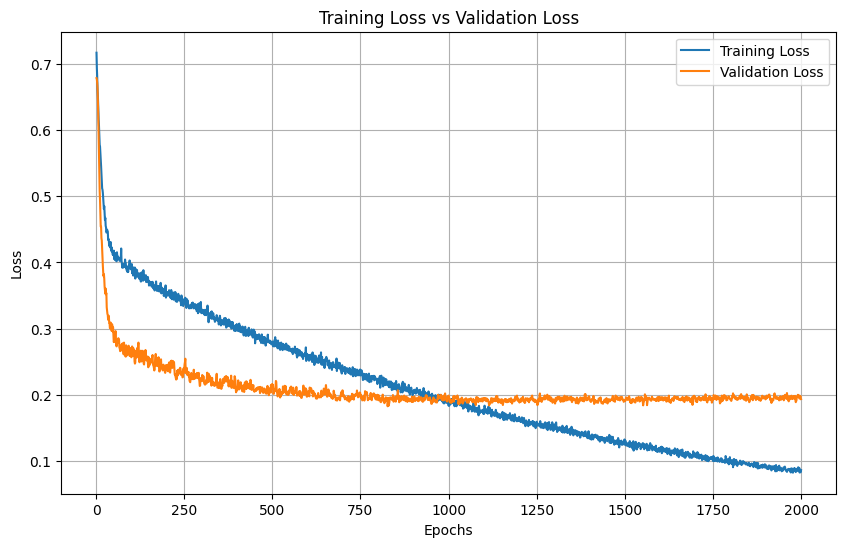

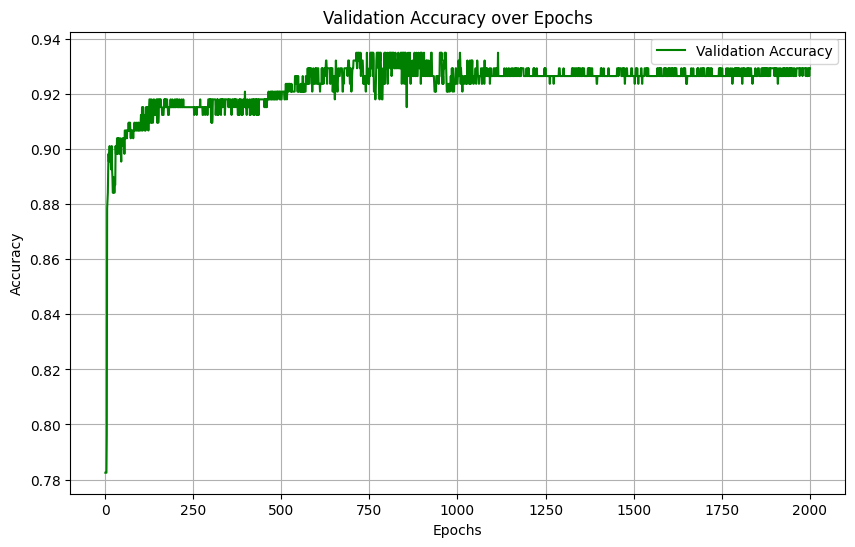

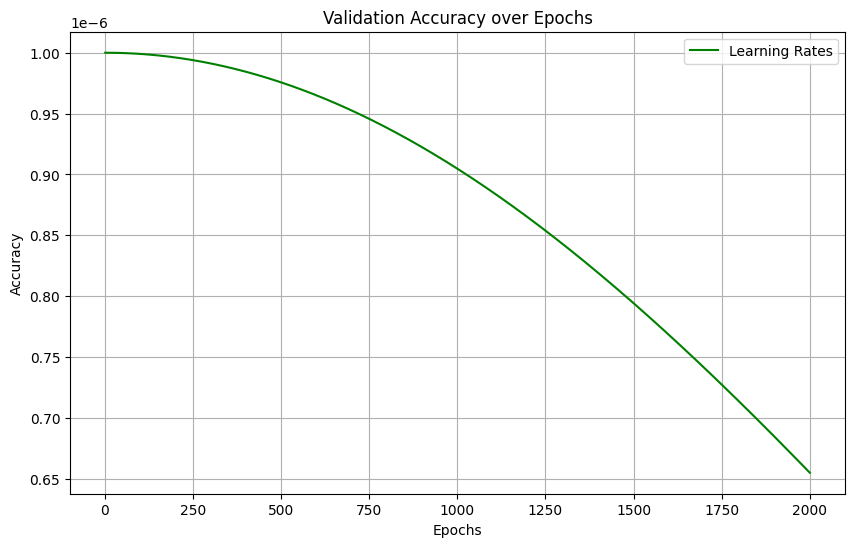

Model for bin 13 saved to GNN-5A_Exp2/model_bin_13.pth
Using 4 GPUs
Training on bin 14/50
Bin 14, Epoch 1/2000, Train Loss: 0.6893, Validation Loss: 0.7232,  Accuracy: 0.5766, LR: 0.000001
Bin 14, Epoch 101/2000, Train Loss: 0.3706, Validation Loss: 0.2454,  Accuracy: 0.8390, LR: 0.000001
Bin 14, Epoch 201/2000, Train Loss: 0.3436, Validation Loss: 0.2145,  Accuracy: 0.8571, LR: 0.000001
Bin 14, Epoch 301/2000, Train Loss: 0.3137, Validation Loss: 0.2082,  Accuracy: 0.8727, LR: 0.000001
Bin 14, Epoch 401/2000, Train Loss: 0.2814, Validation Loss: 0.1905,  Accuracy: 0.8831, LR: 0.000001
Bin 14, Epoch 501/2000, Train Loss: 0.2682, Validation Loss: 0.1913,  Accuracy: 0.8935, LR: 0.000001
Bin 14, Epoch 601/2000, Train Loss: 0.2417, Validation Loss: 0.1818,  Accuracy: 0.9052, LR: 0.000001
Bin 14, Epoch 701/2000, Train Loss: 0.2286, Validation Loss: 0.1792,  Accuracy: 0.9156, LR: 0.000001
Bin 14, Epoch 801/2000, Train Loss: 0.2127, Validation Loss: 0.1750,  Accuracy: 0.9221, LR: 0.000001
Bin

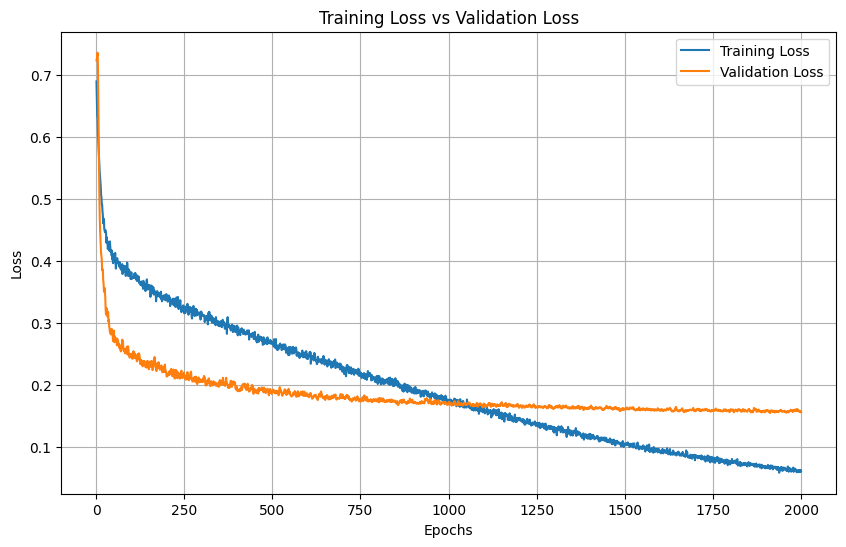

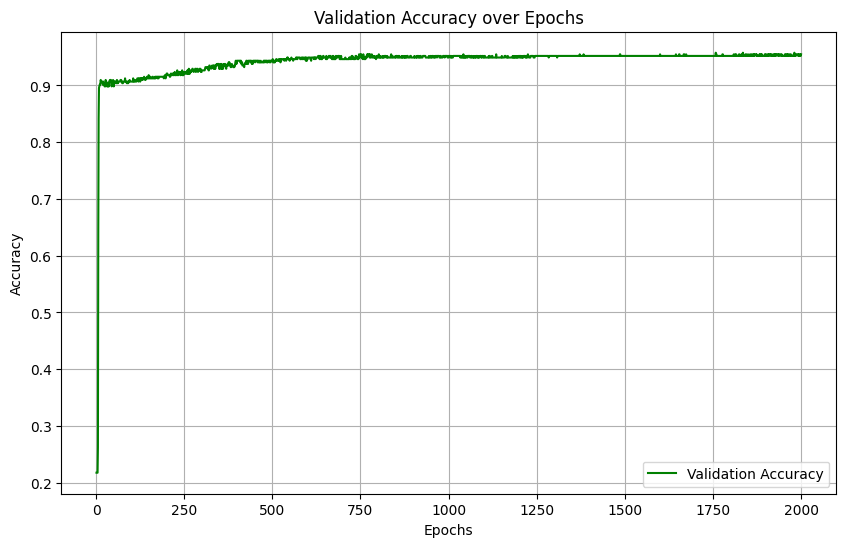

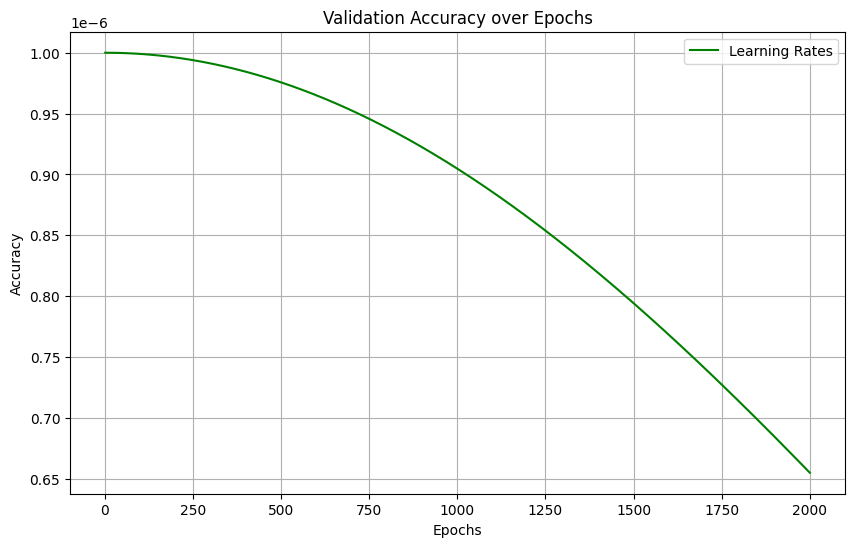

Model for bin 14 saved to GNN-5A_Exp2/model_bin_14.pth
Using 4 GPUs
Training on bin 15/50
Bin 15, Epoch 1/2000, Train Loss: 0.6952, Validation Loss: 0.7023,  Accuracy: 0.5130, LR: 0.000001
Bin 15, Epoch 101/2000, Train Loss: 0.4090, Validation Loss: 0.2593,  Accuracy: 0.8221, LR: 0.000001
Bin 15, Epoch 201/2000, Train Loss: 0.3744, Validation Loss: 0.2364,  Accuracy: 0.8377, LR: 0.000001
Bin 15, Epoch 301/2000, Train Loss: 0.3427, Validation Loss: 0.2162,  Accuracy: 0.8610, LR: 0.000001
Bin 15, Epoch 401/2000, Train Loss: 0.3099, Validation Loss: 0.2079,  Accuracy: 0.8740, LR: 0.000001
Bin 15, Epoch 501/2000, Train Loss: 0.2945, Validation Loss: 0.2011,  Accuracy: 0.8844, LR: 0.000001
Bin 15, Epoch 601/2000, Train Loss: 0.2658, Validation Loss: 0.1942,  Accuracy: 0.8961, LR: 0.000001
Bin 15, Epoch 701/2000, Train Loss: 0.2523, Validation Loss: 0.2001,  Accuracy: 0.8948, LR: 0.000001
Bin 15, Epoch 801/2000, Train Loss: 0.2332, Validation Loss: 0.1815,  Accuracy: 0.9052, LR: 0.000001
Bin

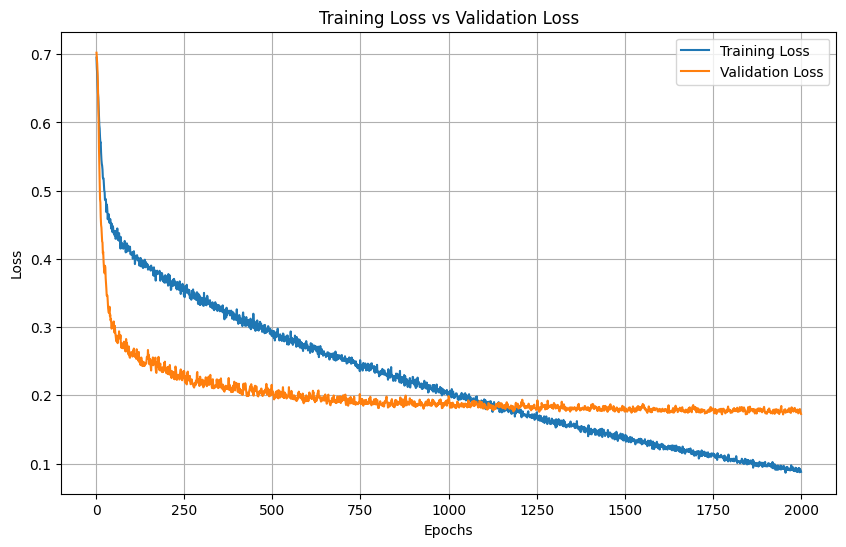

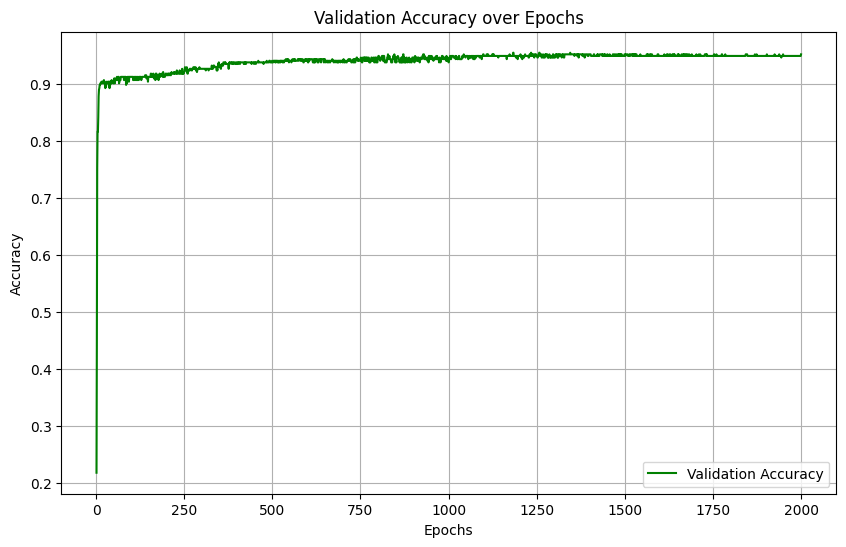

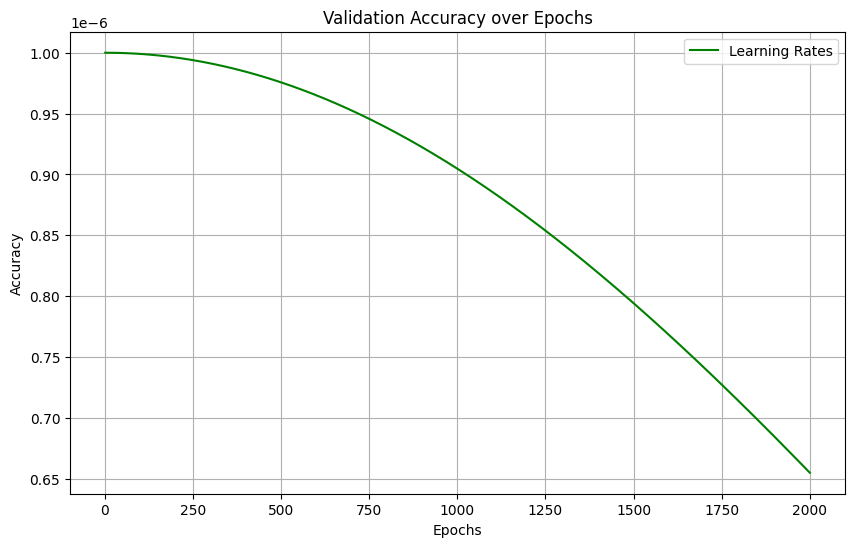

Model for bin 15 saved to GNN-5A_Exp2/model_bin_15.pth
Using 4 GPUs
Training on bin 16/50
Bin 16, Epoch 1/2000, Train Loss: 0.6766, Validation Loss: 0.6718,  Accuracy: 0.5208, LR: 0.000001
Bin 16, Epoch 101/2000, Train Loss: 0.3790, Validation Loss: 0.2613,  Accuracy: 0.8377, LR: 0.000001
Bin 16, Epoch 201/2000, Train Loss: 0.3550, Validation Loss: 0.2350,  Accuracy: 0.8481, LR: 0.000001
Bin 16, Epoch 301/2000, Train Loss: 0.3313, Validation Loss: 0.2480,  Accuracy: 0.8610, LR: 0.000001
Bin 16, Epoch 401/2000, Train Loss: 0.3123, Validation Loss: 0.2259,  Accuracy: 0.8753, LR: 0.000001
Bin 16, Epoch 501/2000, Train Loss: 0.2930, Validation Loss: 0.2157,  Accuracy: 0.8883, LR: 0.000001
Bin 16, Epoch 601/2000, Train Loss: 0.2770, Validation Loss: 0.2138,  Accuracy: 0.8987, LR: 0.000001
Bin 16, Epoch 701/2000, Train Loss: 0.2630, Validation Loss: 0.2061,  Accuracy: 0.9013, LR: 0.000001
Bin 16, Epoch 801/2000, Train Loss: 0.2474, Validation Loss: 0.2099,  Accuracy: 0.9078, LR: 0.000001
Bin

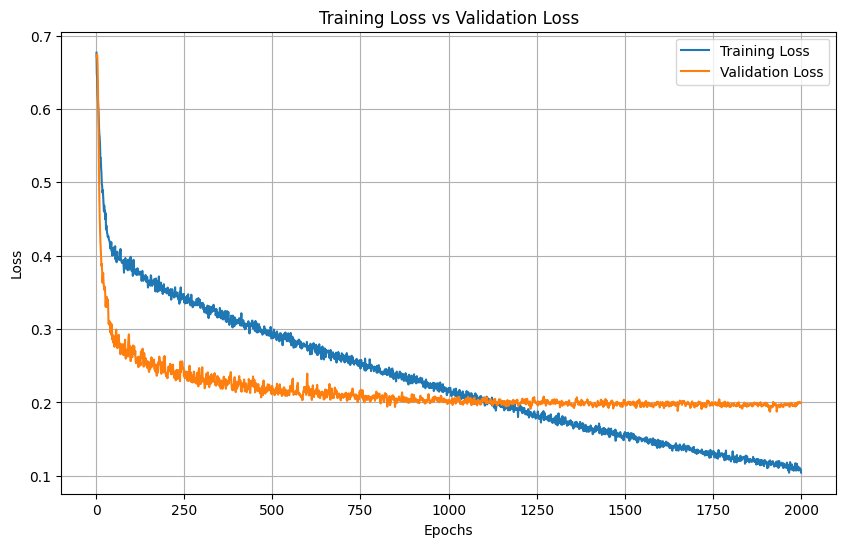

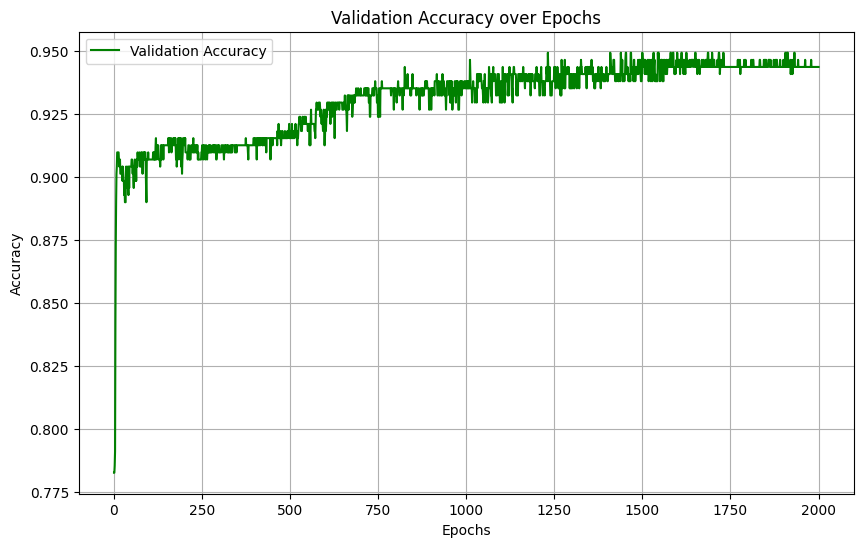

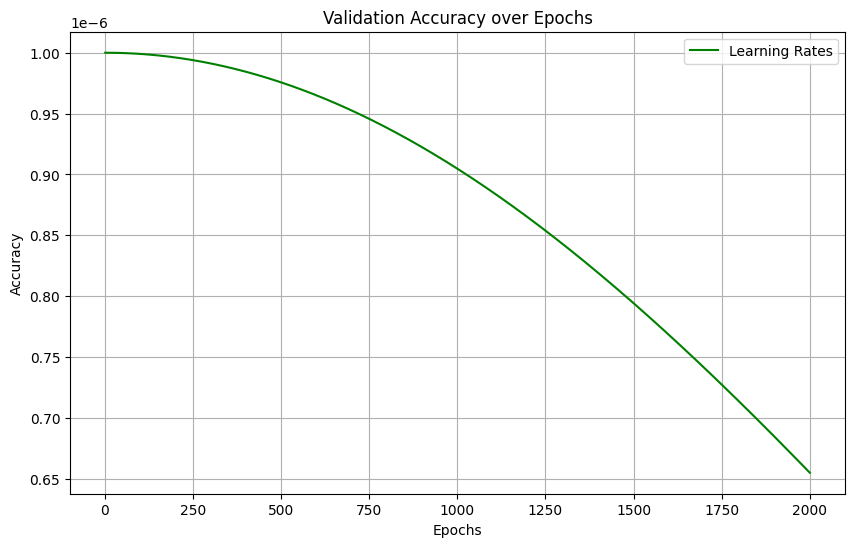

Model for bin 16 saved to GNN-5A_Exp2/model_bin_16.pth
Using 4 GPUs
Training on bin 17/50
Bin 17, Epoch 1/2000, Train Loss: 0.6721, Validation Loss: 0.7063,  Accuracy: 0.5597, LR: 0.000001
Bin 17, Epoch 101/2000, Train Loss: 0.3837, Validation Loss: 0.2648,  Accuracy: 0.8390, LR: 0.000001
Bin 17, Epoch 201/2000, Train Loss: 0.3428, Validation Loss: 0.2465,  Accuracy: 0.8584, LR: 0.000001
Bin 17, Epoch 301/2000, Train Loss: 0.3188, Validation Loss: 0.2292,  Accuracy: 0.8818, LR: 0.000001
Bin 17, Epoch 401/2000, Train Loss: 0.3024, Validation Loss: 0.2146,  Accuracy: 0.8896, LR: 0.000001
Bin 17, Epoch 501/2000, Train Loss: 0.2773, Validation Loss: 0.2222,  Accuracy: 0.9000, LR: 0.000001
Bin 17, Epoch 601/2000, Train Loss: 0.2627, Validation Loss: 0.2121,  Accuracy: 0.8987, LR: 0.000001
Bin 17, Epoch 701/2000, Train Loss: 0.2450, Validation Loss: 0.2033,  Accuracy: 0.9156, LR: 0.000001
Bin 17, Epoch 801/2000, Train Loss: 0.2360, Validation Loss: 0.2048,  Accuracy: 0.9117, LR: 0.000001
Bin

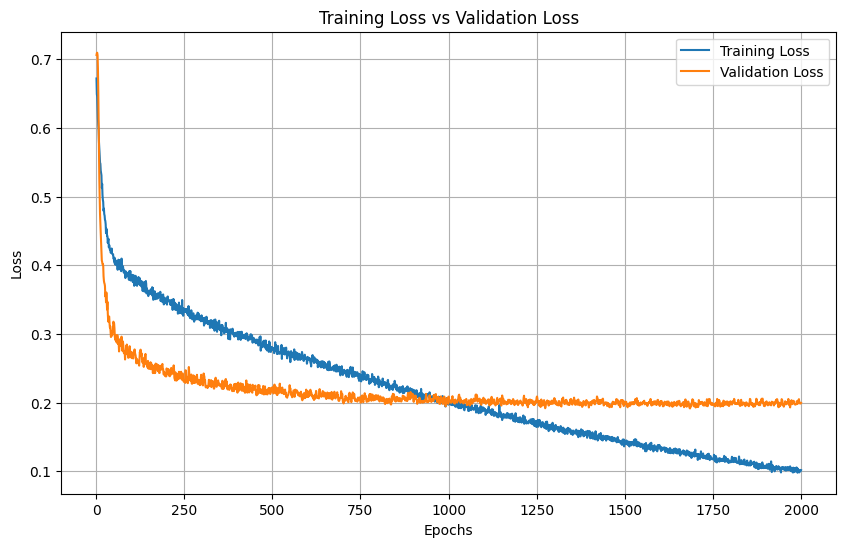

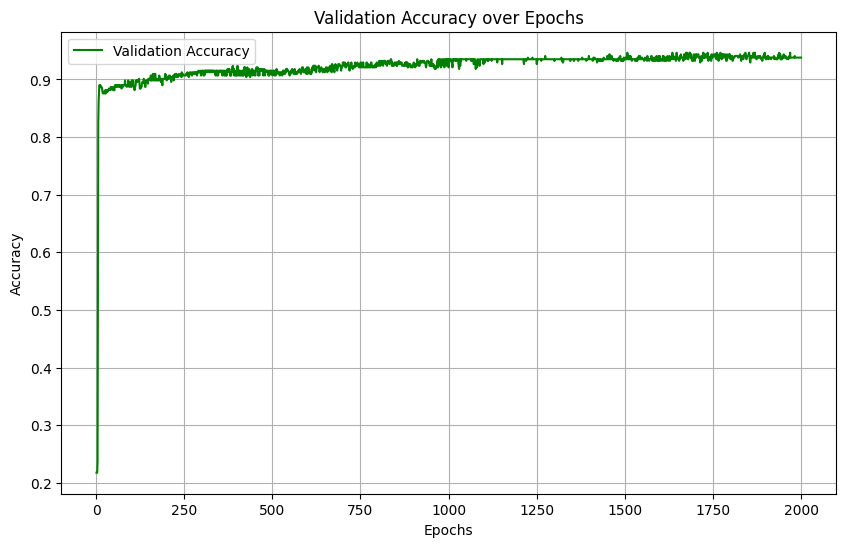

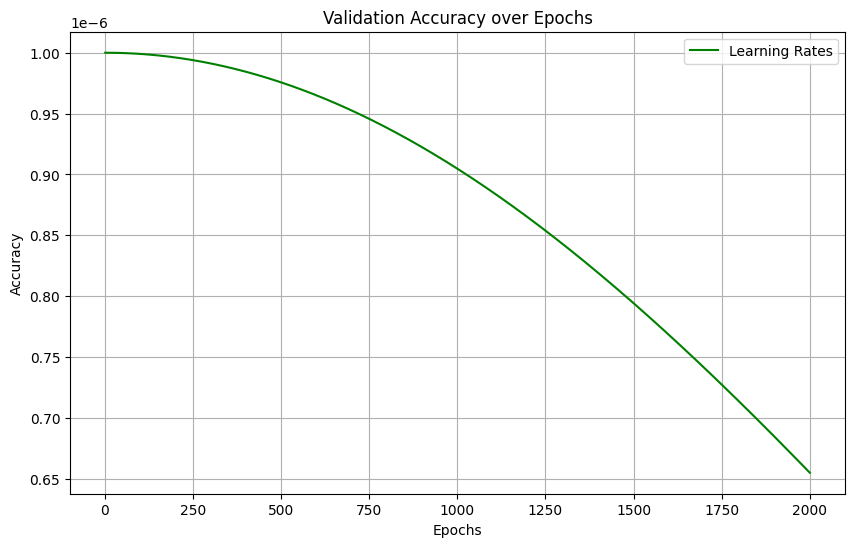

Model for bin 17 saved to GNN-5A_Exp2/model_bin_17.pth
Using 4 GPUs
Training on bin 18/50
Bin 18, Epoch 1/2000, Train Loss: 0.6812, Validation Loss: 0.6901,  Accuracy: 0.5571, LR: 0.000001
Bin 18, Epoch 101/2000, Train Loss: 0.3990, Validation Loss: 0.2665,  Accuracy: 0.8273, LR: 0.000001
Bin 18, Epoch 201/2000, Train Loss: 0.3635, Validation Loss: 0.2392,  Accuracy: 0.8429, LR: 0.000001
Bin 18, Epoch 301/2000, Train Loss: 0.3379, Validation Loss: 0.2332,  Accuracy: 0.8675, LR: 0.000001
Bin 18, Epoch 401/2000, Train Loss: 0.3160, Validation Loss: 0.2145,  Accuracy: 0.8753, LR: 0.000001
Bin 18, Epoch 501/2000, Train Loss: 0.3030, Validation Loss: 0.2095,  Accuracy: 0.8805, LR: 0.000001
Bin 18, Epoch 601/2000, Train Loss: 0.2743, Validation Loss: 0.2063,  Accuracy: 0.8909, LR: 0.000001
Bin 18, Epoch 701/2000, Train Loss: 0.2609, Validation Loss: 0.1991,  Accuracy: 0.9078, LR: 0.000001
Bin 18, Epoch 801/2000, Train Loss: 0.2412, Validation Loss: 0.2035,  Accuracy: 0.9117, LR: 0.000001
Bin

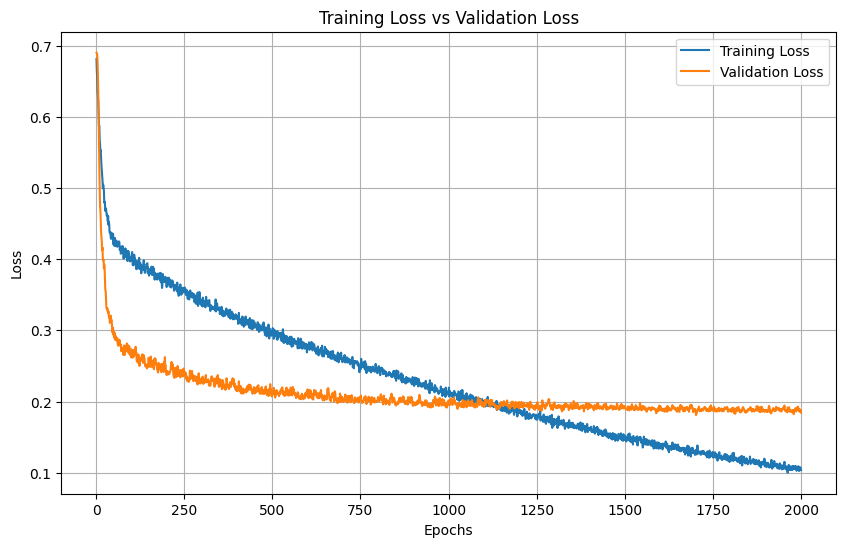

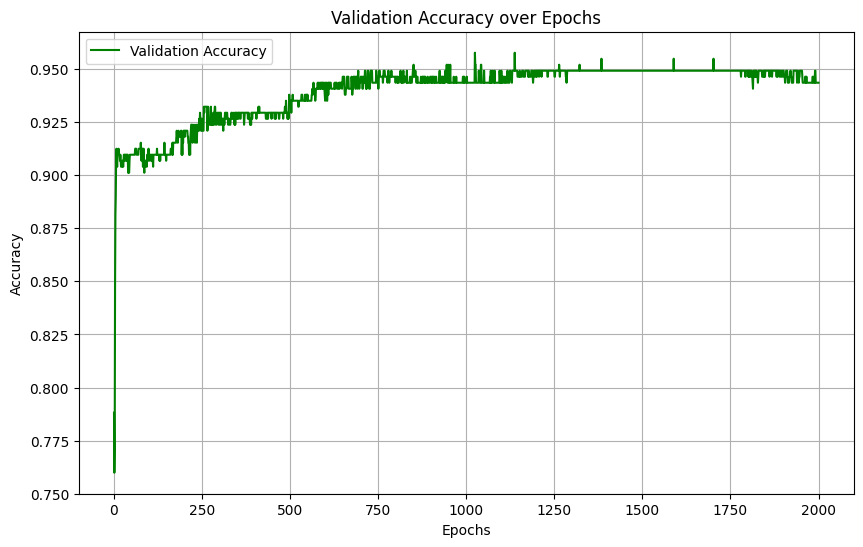

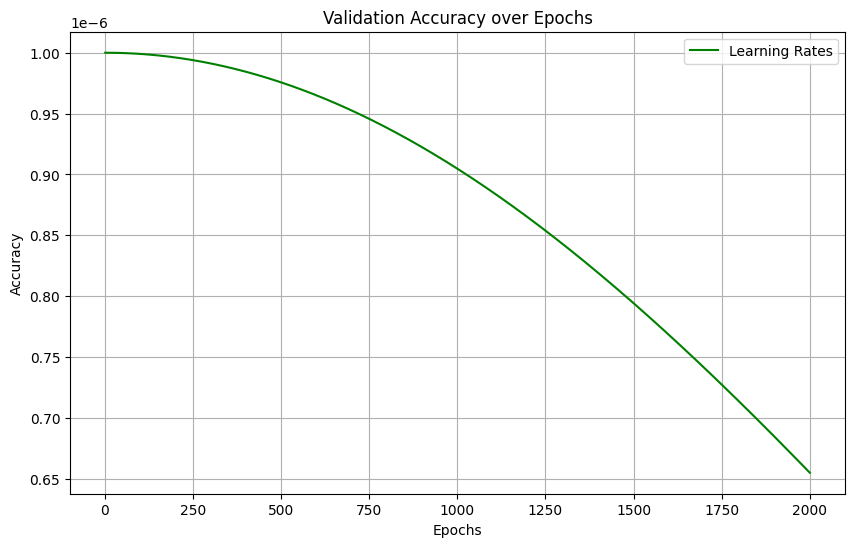

Model for bin 18 saved to GNN-5A_Exp2/model_bin_18.pth
Using 4 GPUs
Training on bin 19/50
Bin 19, Epoch 1/2000, Train Loss: 0.6561, Validation Loss: 0.7008,  Accuracy: 0.6130, LR: 0.000001
Bin 19, Epoch 101/2000, Train Loss: 0.3848, Validation Loss: 0.2550,  Accuracy: 0.8312, LR: 0.000001
Bin 19, Epoch 201/2000, Train Loss: 0.3413, Validation Loss: 0.2267,  Accuracy: 0.8519, LR: 0.000001
Bin 19, Epoch 301/2000, Train Loss: 0.3098, Validation Loss: 0.2182,  Accuracy: 0.8740, LR: 0.000001
Bin 19, Epoch 401/2000, Train Loss: 0.2913, Validation Loss: 0.2065,  Accuracy: 0.8883, LR: 0.000001
Bin 19, Epoch 501/2000, Train Loss: 0.2719, Validation Loss: 0.1950,  Accuracy: 0.8922, LR: 0.000001
Bin 19, Epoch 601/2000, Train Loss: 0.2501, Validation Loss: 0.2001,  Accuracy: 0.9039, LR: 0.000001
Bin 19, Epoch 701/2000, Train Loss: 0.2325, Validation Loss: 0.2004,  Accuracy: 0.9117, LR: 0.000001
Bin 19, Epoch 801/2000, Train Loss: 0.2119, Validation Loss: 0.1941,  Accuracy: 0.9234, LR: 0.000001
Bin

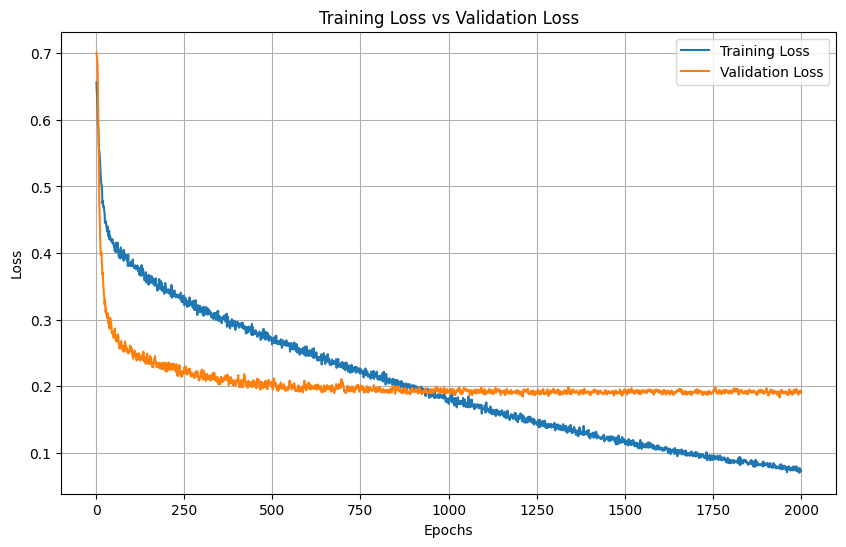

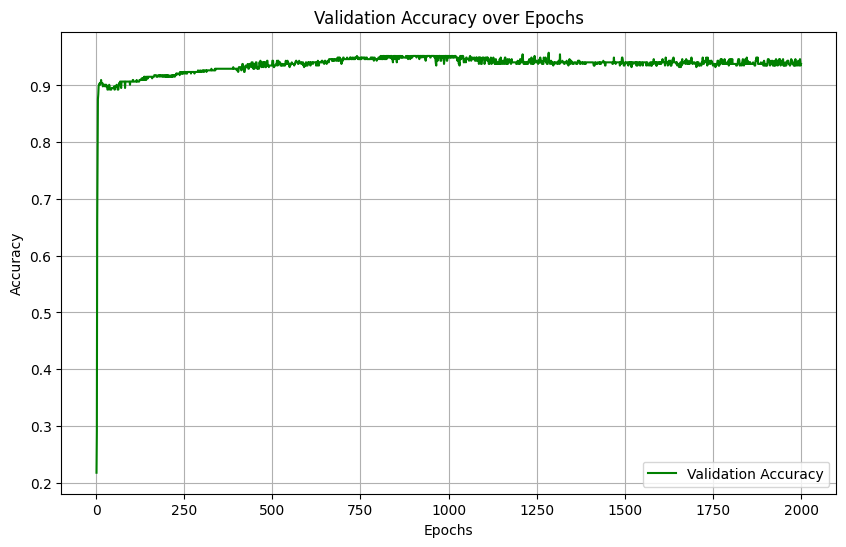

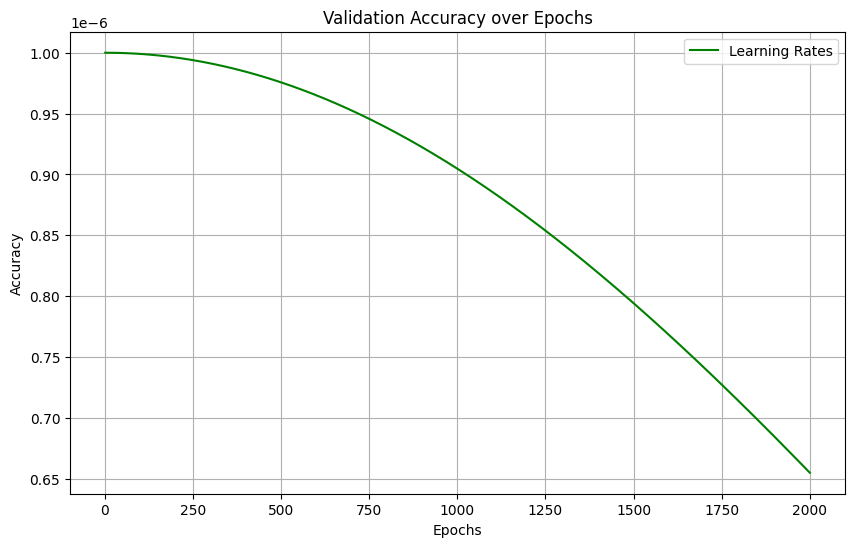

Model for bin 19 saved to GNN-5A_Exp2/model_bin_19.pth
Using 4 GPUs
Training on bin 20/50
Bin 20, Epoch 1/2000, Train Loss: 0.7138, Validation Loss: 0.6816,  Accuracy: 0.4740, LR: 0.000001
Bin 20, Epoch 101/2000, Train Loss: 0.3743, Validation Loss: 0.2727,  Accuracy: 0.8416, LR: 0.000001
Bin 20, Epoch 201/2000, Train Loss: 0.3375, Validation Loss: 0.2420,  Accuracy: 0.8610, LR: 0.000001
Bin 20, Epoch 301/2000, Train Loss: 0.3047, Validation Loss: 0.2214,  Accuracy: 0.8688, LR: 0.000001
Bin 20, Epoch 401/2000, Train Loss: 0.2865, Validation Loss: 0.2109,  Accuracy: 0.8766, LR: 0.000001
Bin 20, Epoch 501/2000, Train Loss: 0.2618, Validation Loss: 0.1978,  Accuracy: 0.8935, LR: 0.000001
Bin 20, Epoch 601/2000, Train Loss: 0.2543, Validation Loss: 0.2017,  Accuracy: 0.9039, LR: 0.000001
Bin 20, Epoch 701/2000, Train Loss: 0.2300, Validation Loss: 0.1881,  Accuracy: 0.9091, LR: 0.000001
Bin 20, Epoch 801/2000, Train Loss: 0.2118, Validation Loss: 0.1878,  Accuracy: 0.9156, LR: 0.000001
Bin

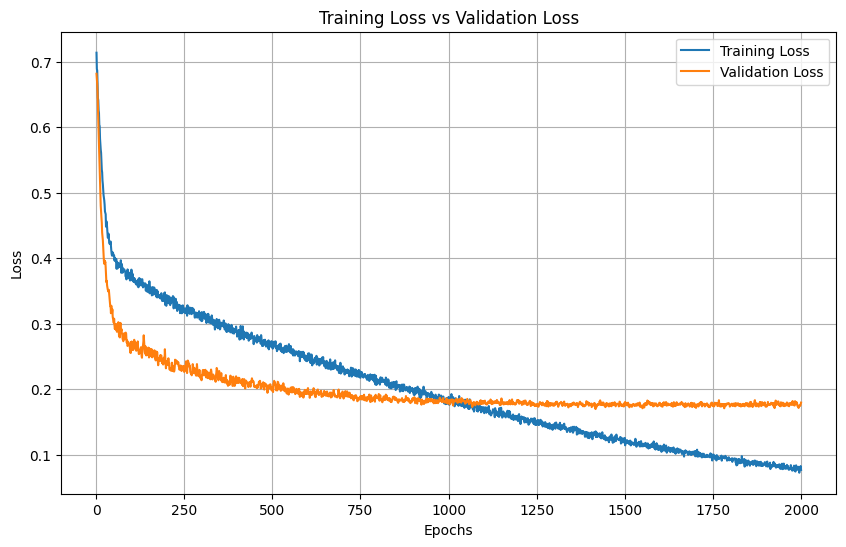

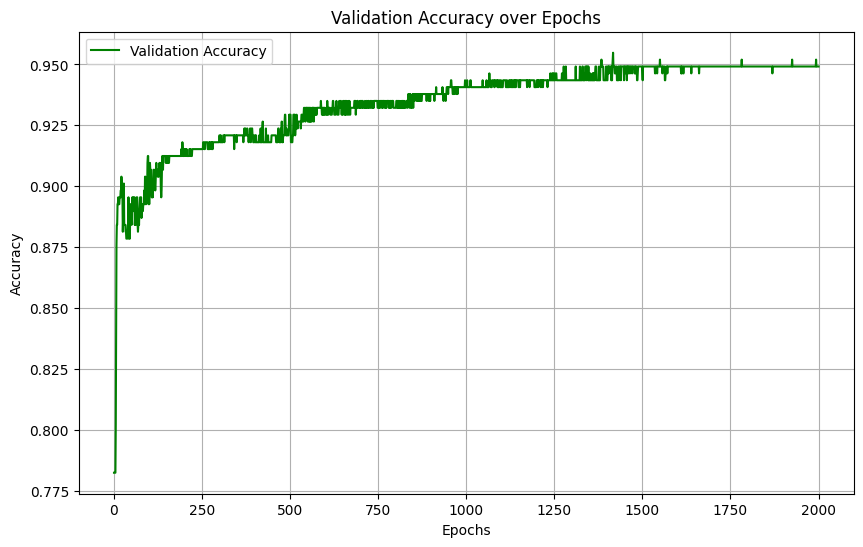

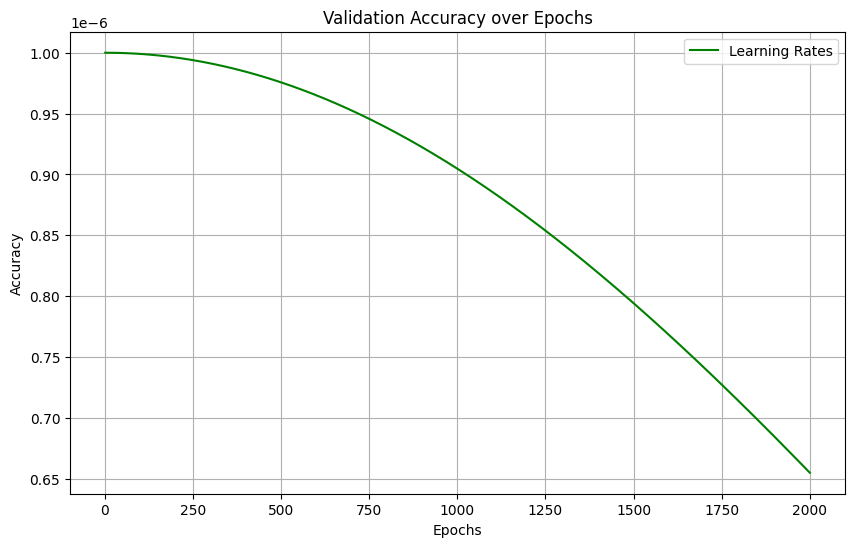

Model for bin 20 saved to GNN-5A_Exp2/model_bin_20.pth
Using 4 GPUs
Training on bin 21/50
Bin 21, Epoch 1/2000, Train Loss: 0.7140, Validation Loss: 0.6890,  Accuracy: 0.4519, LR: 0.000001
Bin 21, Epoch 101/2000, Train Loss: 0.3775, Validation Loss: 0.2590,  Accuracy: 0.8468, LR: 0.000001
Bin 21, Epoch 201/2000, Train Loss: 0.3478, Validation Loss: 0.2357,  Accuracy: 0.8494, LR: 0.000001
Bin 21, Epoch 301/2000, Train Loss: 0.3173, Validation Loss: 0.2285,  Accuracy: 0.8779, LR: 0.000001
Bin 21, Epoch 401/2000, Train Loss: 0.2950, Validation Loss: 0.2092,  Accuracy: 0.8844, LR: 0.000001
Bin 21, Epoch 501/2000, Train Loss: 0.2650, Validation Loss: 0.1989,  Accuracy: 0.9013, LR: 0.000001
Bin 21, Epoch 601/2000, Train Loss: 0.2492, Validation Loss: 0.1942,  Accuracy: 0.9052, LR: 0.000001
Bin 21, Epoch 701/2000, Train Loss: 0.2337, Validation Loss: 0.1920,  Accuracy: 0.9156, LR: 0.000001
Bin 21, Epoch 801/2000, Train Loss: 0.2105, Validation Loss: 0.1982,  Accuracy: 0.9247, LR: 0.000001
Bin

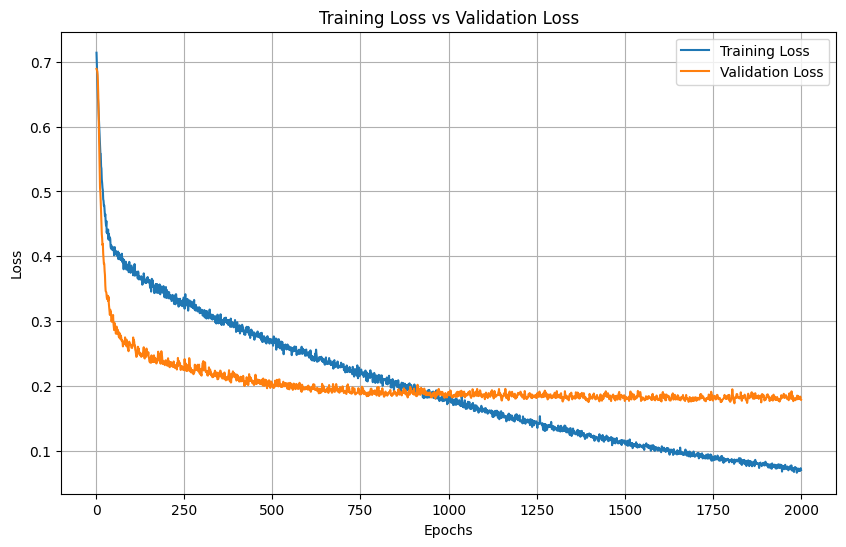

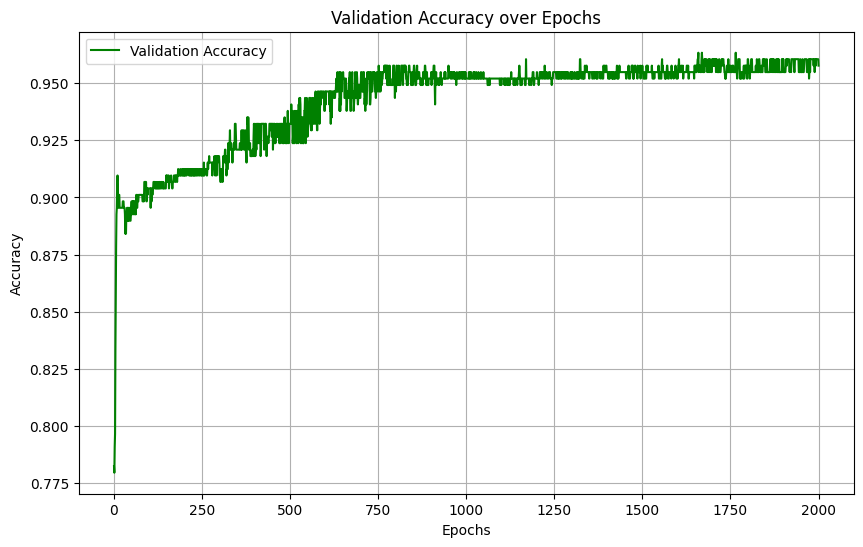

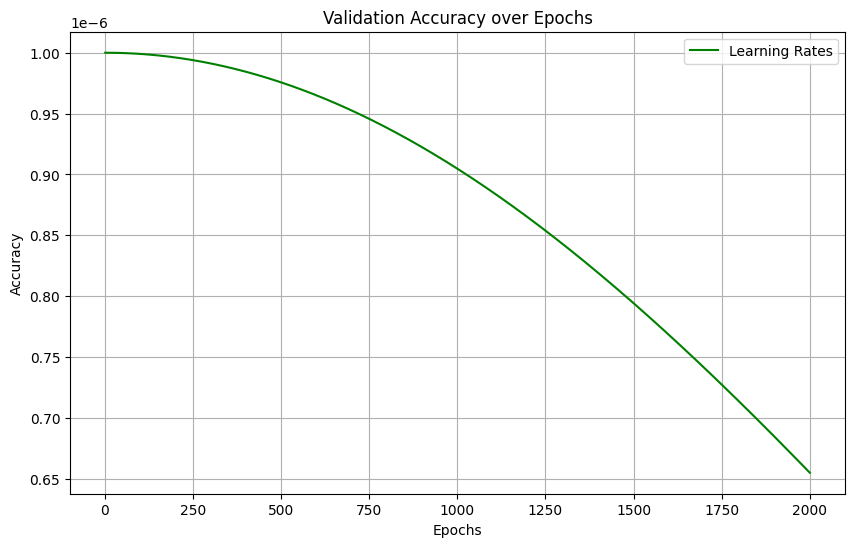

Model for bin 21 saved to GNN-5A_Exp2/model_bin_21.pth
Using 4 GPUs
Training on bin 22/50
Bin 22, Epoch 1/2000, Train Loss: 0.7135, Validation Loss: 0.6915,  Accuracy: 0.4714, LR: 0.000001
Bin 22, Epoch 101/2000, Train Loss: 0.3730, Validation Loss: 0.2536,  Accuracy: 0.8468, LR: 0.000001
Bin 22, Epoch 201/2000, Train Loss: 0.3362, Validation Loss: 0.2291,  Accuracy: 0.8494, LR: 0.000001
Bin 22, Epoch 301/2000, Train Loss: 0.3014, Validation Loss: 0.2179,  Accuracy: 0.8766, LR: 0.000001
Bin 22, Epoch 401/2000, Train Loss: 0.2742, Validation Loss: 0.2049,  Accuracy: 0.8935, LR: 0.000001
Bin 22, Epoch 501/2000, Train Loss: 0.2585, Validation Loss: 0.1994,  Accuracy: 0.9013, LR: 0.000001
Bin 22, Epoch 601/2000, Train Loss: 0.2315, Validation Loss: 0.1903,  Accuracy: 0.9091, LR: 0.000001
Bin 22, Epoch 701/2000, Train Loss: 0.2152, Validation Loss: 0.1874,  Accuracy: 0.9338, LR: 0.000001
Bin 22, Epoch 801/2000, Train Loss: 0.1929, Validation Loss: 0.1955,  Accuracy: 0.9299, LR: 0.000001
Bin

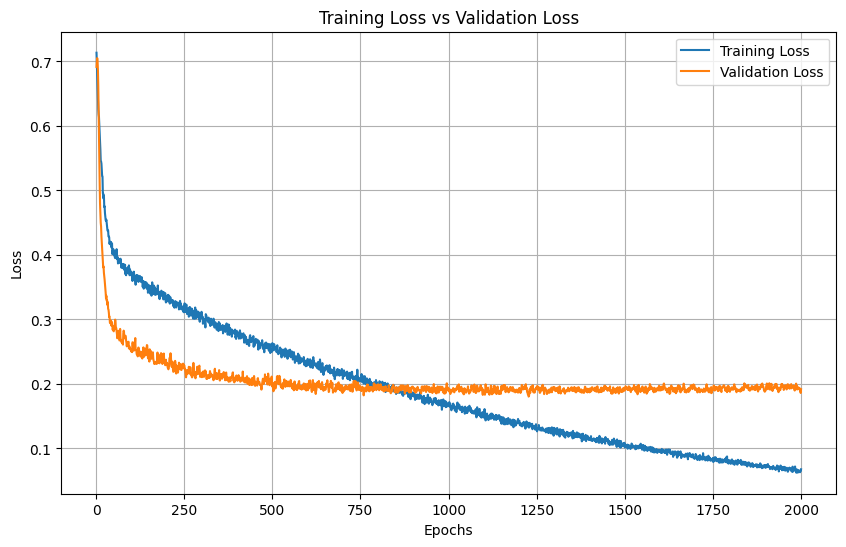

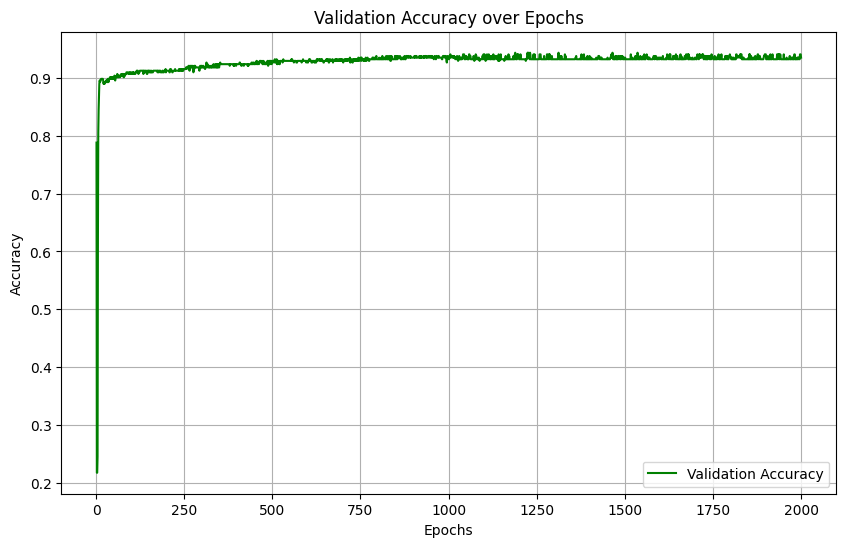

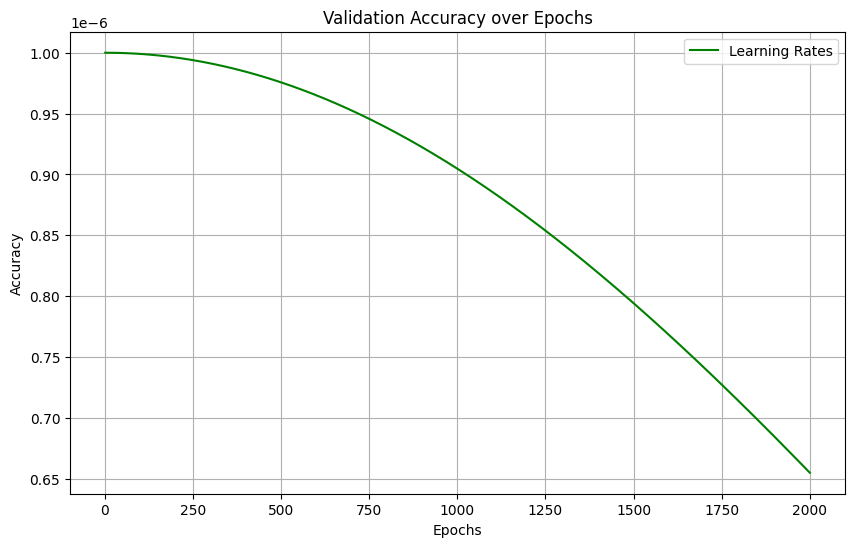

Model for bin 22 saved to GNN-5A_Exp2/model_bin_22.pth
Using 4 GPUs
Training on bin 23/50
Bin 23, Epoch 1/2000, Train Loss: 0.6933, Validation Loss: 0.7077,  Accuracy: 0.5442, LR: 0.000001
Bin 23, Epoch 101/2000, Train Loss: 0.3864, Validation Loss: 0.2512,  Accuracy: 0.8429, LR: 0.000001
Bin 23, Epoch 201/2000, Train Loss: 0.3416, Validation Loss: 0.2328,  Accuracy: 0.8519, LR: 0.000001
Bin 23, Epoch 301/2000, Train Loss: 0.3208, Validation Loss: 0.2098,  Accuracy: 0.8636, LR: 0.000001
Bin 23, Epoch 401/2000, Train Loss: 0.2964, Validation Loss: 0.2019,  Accuracy: 0.8857, LR: 0.000001
Bin 23, Epoch 501/2000, Train Loss: 0.2736, Validation Loss: 0.1912,  Accuracy: 0.8948, LR: 0.000001
Bin 23, Epoch 601/2000, Train Loss: 0.2561, Validation Loss: 0.1931,  Accuracy: 0.9000, LR: 0.000001
Bin 23, Epoch 701/2000, Train Loss: 0.2323, Validation Loss: 0.1903,  Accuracy: 0.9143, LR: 0.000001
Bin 23, Epoch 801/2000, Train Loss: 0.2162, Validation Loss: 0.1833,  Accuracy: 0.9260, LR: 0.000001
Bin

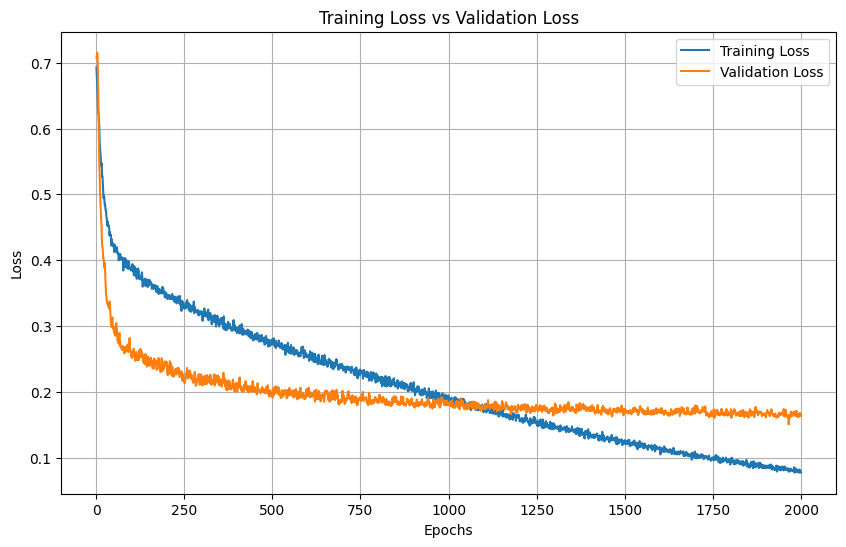

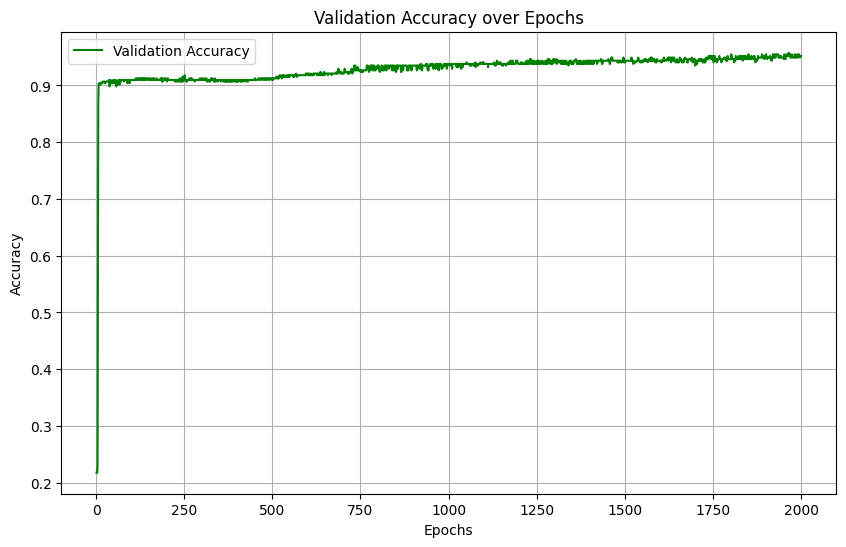

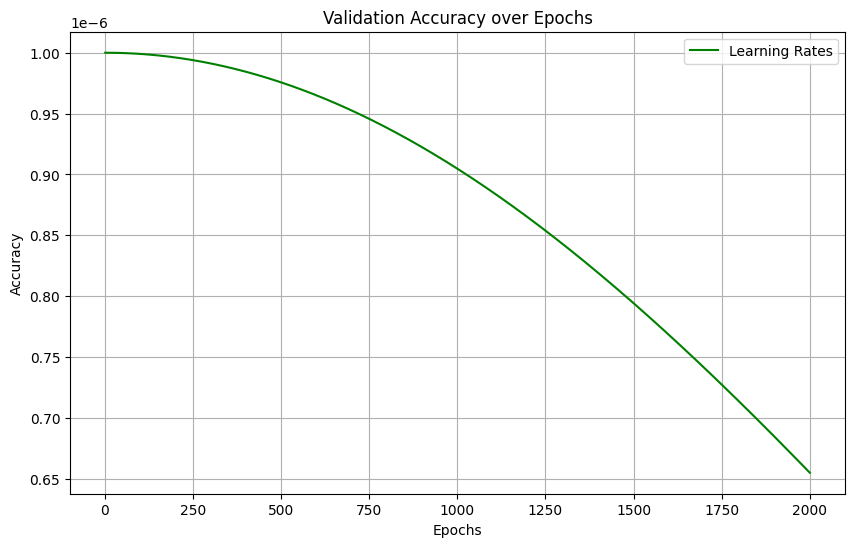

Model for bin 23 saved to GNN-5A_Exp2/model_bin_23.pth
Using 4 GPUs
Training on bin 24/50
Bin 24, Epoch 1/2000, Train Loss: 0.7318, Validation Loss: 0.6804,  Accuracy: 0.4506, LR: 0.000001
Bin 24, Epoch 101/2000, Train Loss: 0.3795, Validation Loss: 0.2505,  Accuracy: 0.8377, LR: 0.000001
Bin 24, Epoch 201/2000, Train Loss: 0.3420, Validation Loss: 0.2256,  Accuracy: 0.8519, LR: 0.000001
Bin 24, Epoch 301/2000, Train Loss: 0.3160, Validation Loss: 0.2267,  Accuracy: 0.8727, LR: 0.000001
Bin 24, Epoch 401/2000, Train Loss: 0.2966, Validation Loss: 0.2147,  Accuracy: 0.8779, LR: 0.000001
Bin 24, Epoch 501/2000, Train Loss: 0.2661, Validation Loss: 0.1959,  Accuracy: 0.8974, LR: 0.000001
Bin 24, Epoch 601/2000, Train Loss: 0.2502, Validation Loss: 0.1899,  Accuracy: 0.9117, LR: 0.000001
Bin 24, Epoch 701/2000, Train Loss: 0.2298, Validation Loss: 0.1867,  Accuracy: 0.9130, LR: 0.000001
Bin 24, Epoch 801/2000, Train Loss: 0.2155, Validation Loss: 0.1866,  Accuracy: 0.9247, LR: 0.000001
Bin

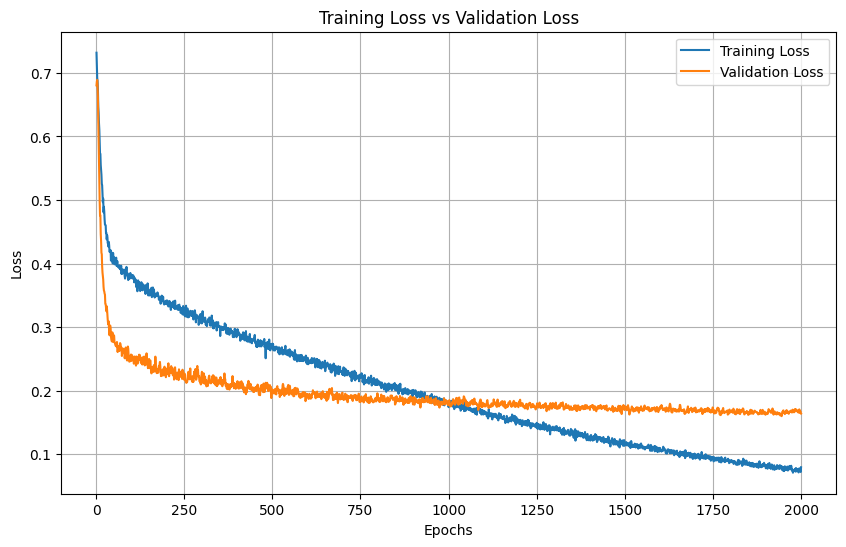

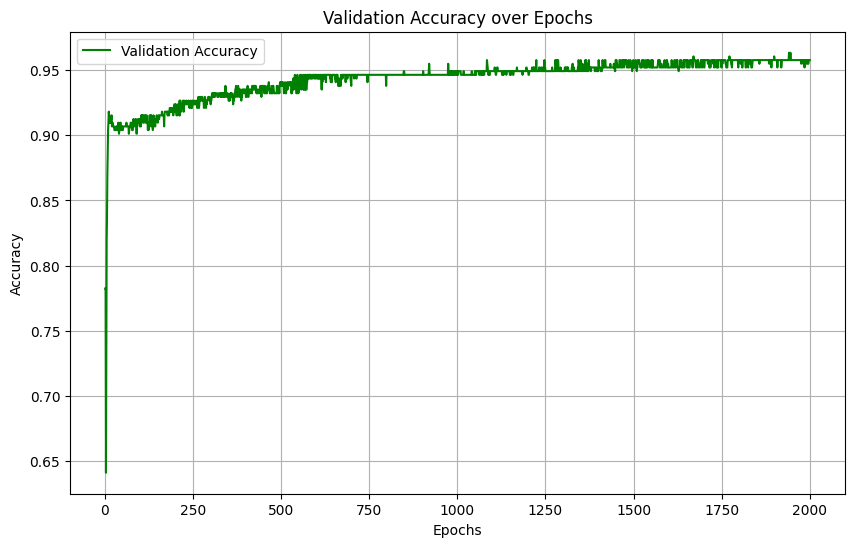

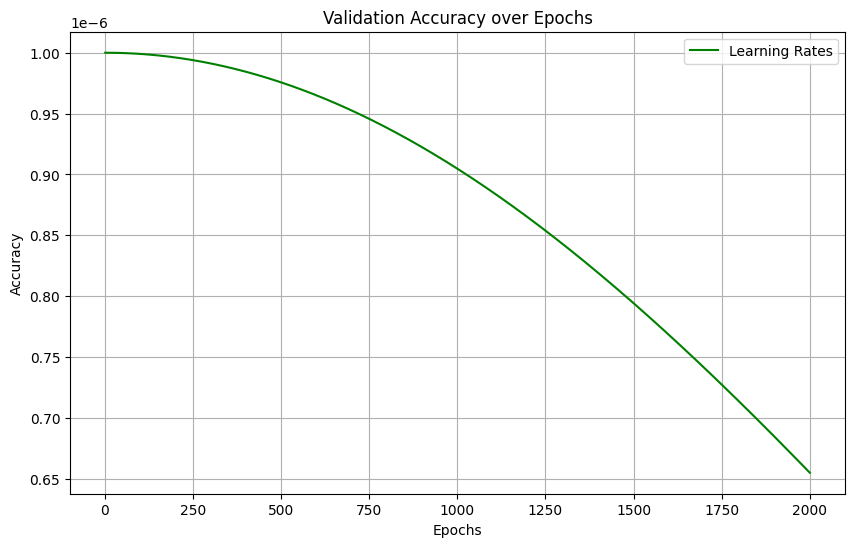

Model for bin 24 saved to GNN-5A_Exp2/model_bin_24.pth
Using 4 GPUs
Training on bin 25/50
Bin 25, Epoch 1/2000, Train Loss: 0.6734, Validation Loss: 0.7116,  Accuracy: 0.5948, LR: 0.000001
Bin 25, Epoch 101/2000, Train Loss: 0.3790, Validation Loss: 0.2522,  Accuracy: 0.8377, LR: 0.000001
Bin 25, Epoch 201/2000, Train Loss: 0.3491, Validation Loss: 0.2339,  Accuracy: 0.8506, LR: 0.000001
Bin 25, Epoch 301/2000, Train Loss: 0.3098, Validation Loss: 0.2118,  Accuracy: 0.8636, LR: 0.000001
Bin 25, Epoch 401/2000, Train Loss: 0.2942, Validation Loss: 0.2109,  Accuracy: 0.8805, LR: 0.000001
Bin 25, Epoch 501/2000, Train Loss: 0.2720, Validation Loss: 0.1939,  Accuracy: 0.8935, LR: 0.000001
Bin 25, Epoch 601/2000, Train Loss: 0.2544, Validation Loss: 0.1950,  Accuracy: 0.9039, LR: 0.000001
Bin 25, Epoch 701/2000, Train Loss: 0.2420, Validation Loss: 0.1860,  Accuracy: 0.9052, LR: 0.000001
Bin 25, Epoch 801/2000, Train Loss: 0.2213, Validation Loss: 0.1918,  Accuracy: 0.9156, LR: 0.000001
Bin

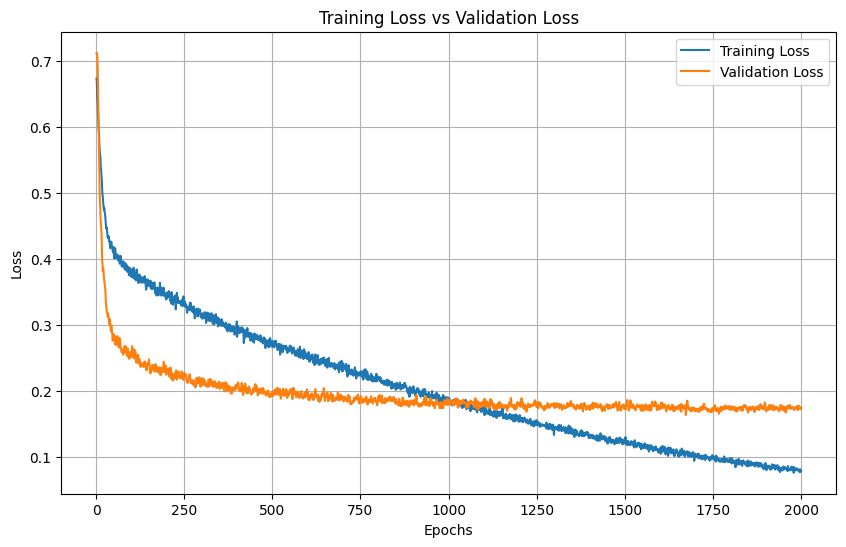

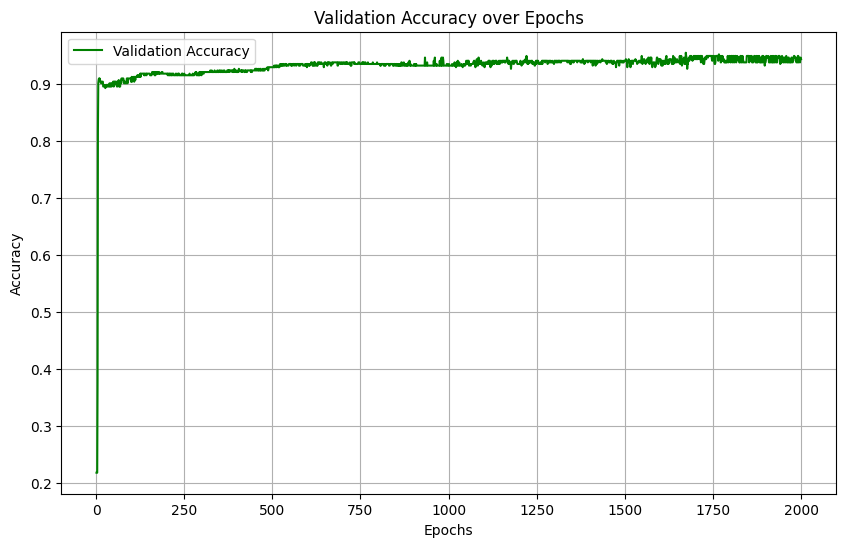

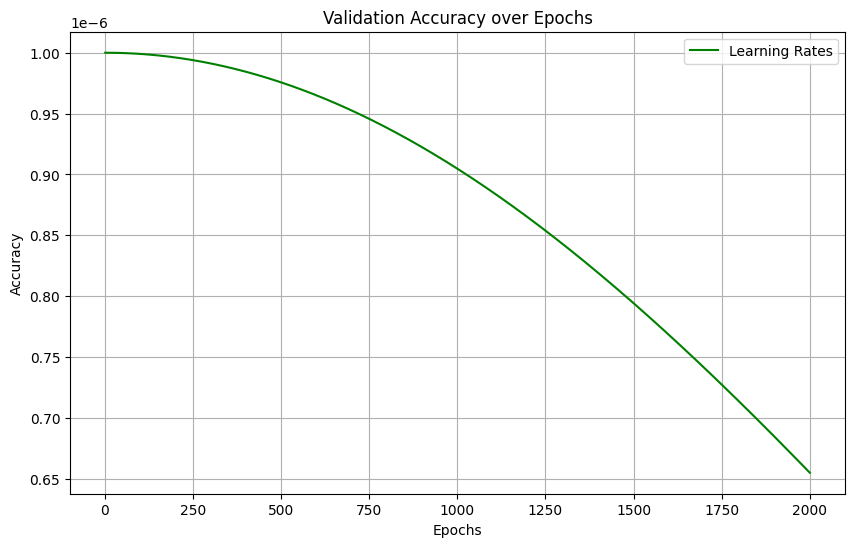

Model for bin 25 saved to GNN-5A_Exp2/model_bin_25.pth
Using 4 GPUs
Training on bin 26/50
Bin 26, Epoch 1/2000, Train Loss: 0.6699, Validation Loss: 0.6956,  Accuracy: 0.5688, LR: 0.000001
Bin 26, Epoch 101/2000, Train Loss: 0.3934, Validation Loss: 0.2481,  Accuracy: 0.8273, LR: 0.000001
Bin 26, Epoch 201/2000, Train Loss: 0.3588, Validation Loss: 0.2282,  Accuracy: 0.8468, LR: 0.000001
Bin 26, Epoch 301/2000, Train Loss: 0.3409, Validation Loss: 0.2283,  Accuracy: 0.8532, LR: 0.000001
Bin 26, Epoch 401/2000, Train Loss: 0.3086, Validation Loss: 0.2129,  Accuracy: 0.8727, LR: 0.000001
Bin 26, Epoch 501/2000, Train Loss: 0.2945, Validation Loss: 0.2152,  Accuracy: 0.8779, LR: 0.000001
Bin 26, Epoch 601/2000, Train Loss: 0.2696, Validation Loss: 0.2058,  Accuracy: 0.8948, LR: 0.000001
Bin 26, Epoch 701/2000, Train Loss: 0.2592, Validation Loss: 0.1996,  Accuracy: 0.8987, LR: 0.000001
Bin 26, Epoch 801/2000, Train Loss: 0.2400, Validation Loss: 0.2005,  Accuracy: 0.9117, LR: 0.000001
Bin

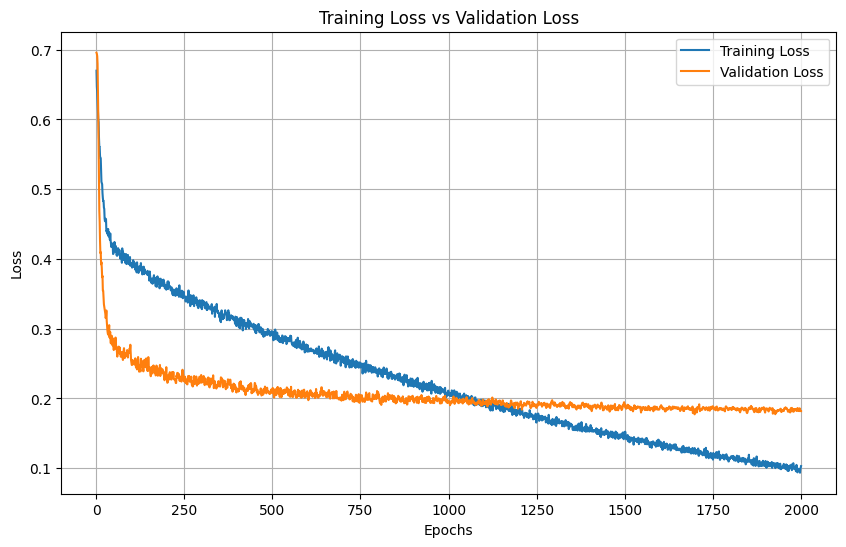

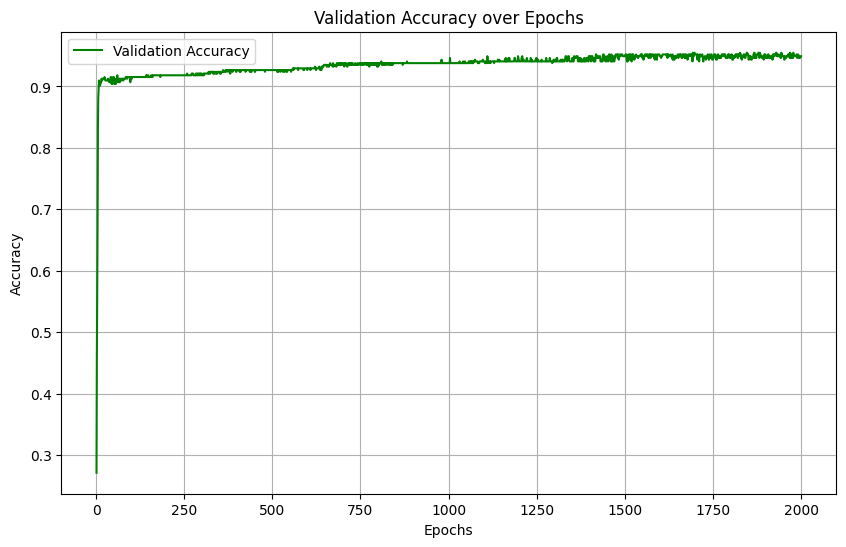

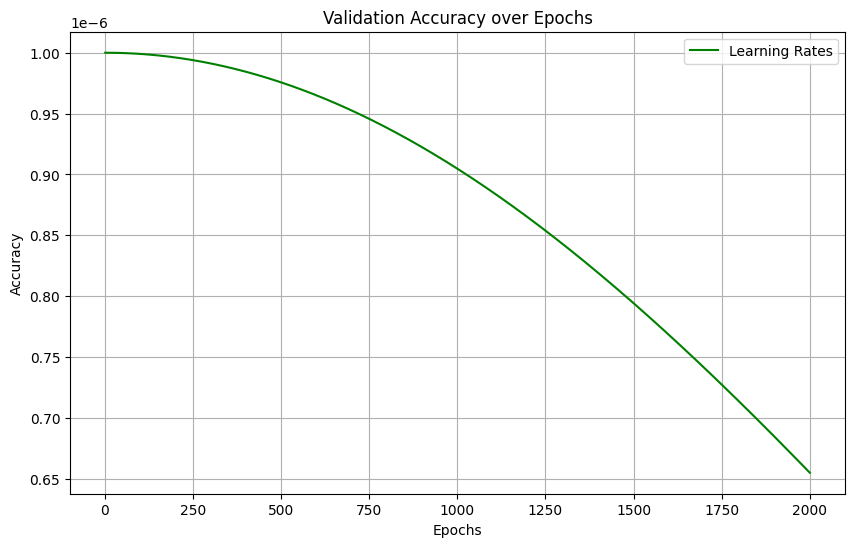

Model for bin 26 saved to GNN-5A_Exp2/model_bin_26.pth
Using 4 GPUs
Training on bin 27/50
Bin 27, Epoch 1/2000, Train Loss: 0.6664, Validation Loss: 0.7002,  Accuracy: 0.6052, LR: 0.000001
Bin 27, Epoch 101/2000, Train Loss: 0.3747, Validation Loss: 0.2564,  Accuracy: 0.8351, LR: 0.000001
Bin 27, Epoch 201/2000, Train Loss: 0.3443, Validation Loss: 0.2375,  Accuracy: 0.8545, LR: 0.000001
Bin 27, Epoch 301/2000, Train Loss: 0.3165, Validation Loss: 0.2180,  Accuracy: 0.8779, LR: 0.000001
Bin 27, Epoch 401/2000, Train Loss: 0.2934, Validation Loss: 0.2020,  Accuracy: 0.8844, LR: 0.000001
Bin 27, Epoch 501/2000, Train Loss: 0.2651, Validation Loss: 0.2001,  Accuracy: 0.8987, LR: 0.000001
Bin 27, Epoch 601/2000, Train Loss: 0.2512, Validation Loss: 0.1911,  Accuracy: 0.9104, LR: 0.000001
Bin 27, Epoch 701/2000, Train Loss: 0.2334, Validation Loss: 0.1839,  Accuracy: 0.9065, LR: 0.000001
Bin 27, Epoch 801/2000, Train Loss: 0.2159, Validation Loss: 0.1813,  Accuracy: 0.9247, LR: 0.000001
Bin

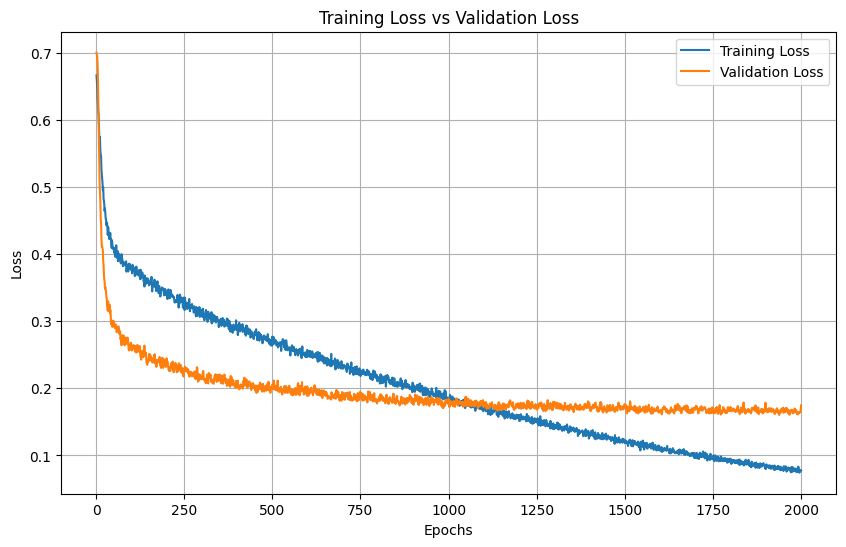

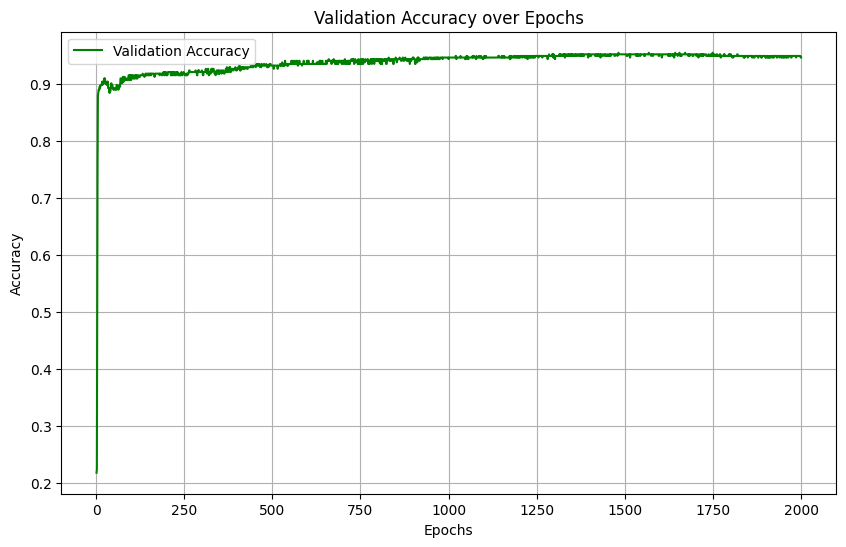

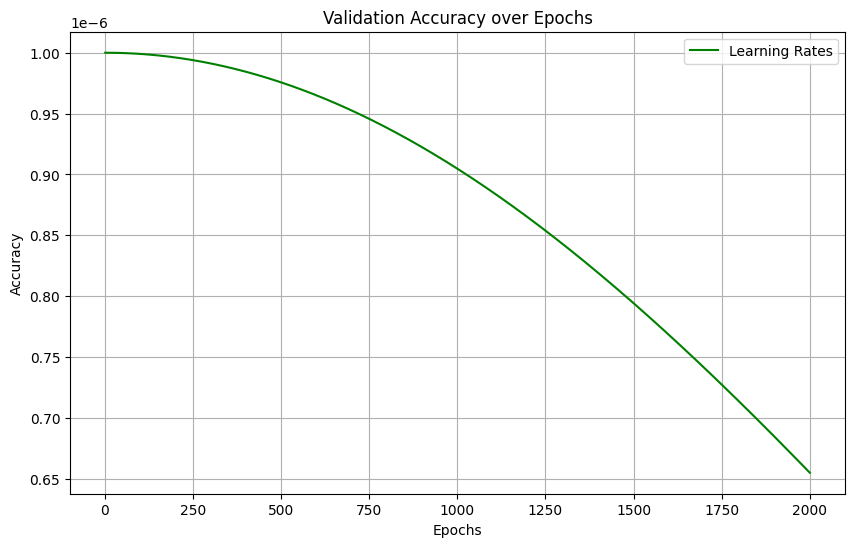

Model for bin 27 saved to GNN-5A_Exp2/model_bin_27.pth
Using 4 GPUs
Training on bin 28/50
Bin 28, Epoch 1/2000, Train Loss: 0.7114, Validation Loss: 0.6952,  Accuracy: 0.5052, LR: 0.000001
Bin 28, Epoch 101/2000, Train Loss: 0.3703, Validation Loss: 0.2647,  Accuracy: 0.8273, LR: 0.000001
Bin 28, Epoch 201/2000, Train Loss: 0.3348, Validation Loss: 0.2371,  Accuracy: 0.8519, LR: 0.000001
Bin 28, Epoch 301/2000, Train Loss: 0.3063, Validation Loss: 0.2181,  Accuracy: 0.8766, LR: 0.000001
Bin 28, Epoch 401/2000, Train Loss: 0.2757, Validation Loss: 0.2021,  Accuracy: 0.8909, LR: 0.000001
Bin 28, Epoch 501/2000, Train Loss: 0.2594, Validation Loss: 0.1983,  Accuracy: 0.8961, LR: 0.000001
Bin 28, Epoch 601/2000, Train Loss: 0.2361, Validation Loss: 0.1920,  Accuracy: 0.9091, LR: 0.000001
Bin 28, Epoch 701/2000, Train Loss: 0.2123, Validation Loss: 0.1867,  Accuracy: 0.9182, LR: 0.000001
Bin 28, Epoch 801/2000, Train Loss: 0.1999, Validation Loss: 0.1848,  Accuracy: 0.9299, LR: 0.000001
Bin

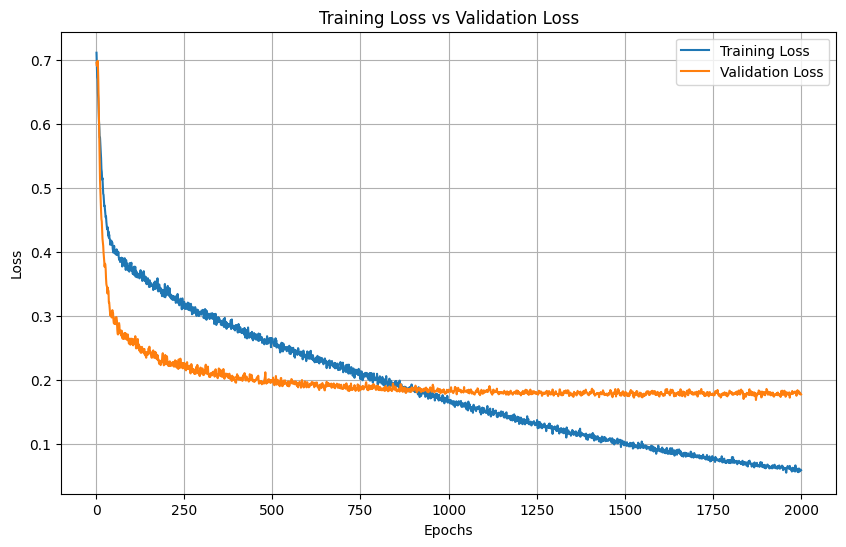

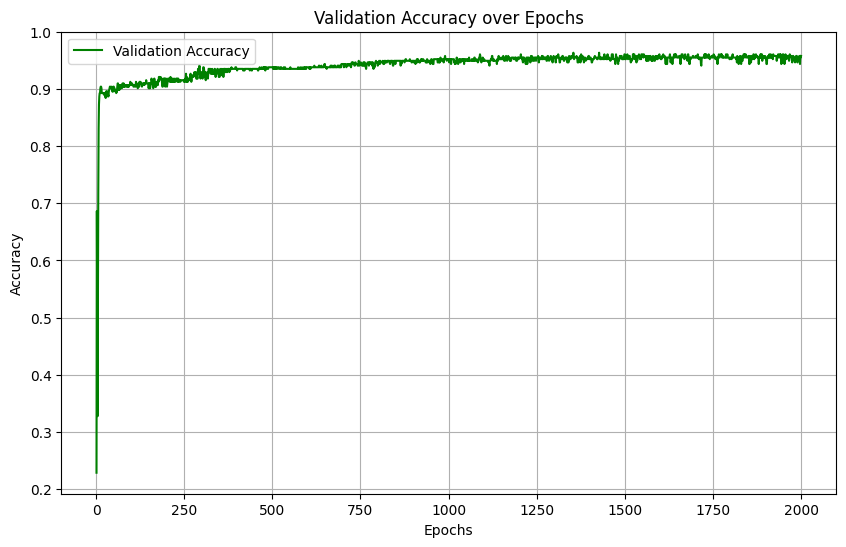

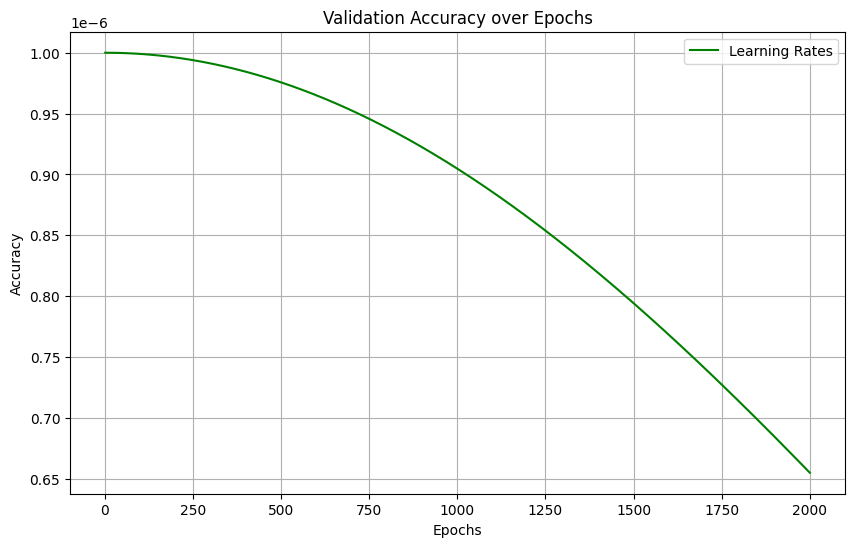

Model for bin 28 saved to GNN-5A_Exp2/model_bin_28.pth
Using 4 GPUs
Training on bin 29/50
Bin 29, Epoch 1/2000, Train Loss: 0.6817, Validation Loss: 0.7165,  Accuracy: 0.5727, LR: 0.000001
Bin 29, Epoch 101/2000, Train Loss: 0.3952, Validation Loss: 0.2586,  Accuracy: 0.8403, LR: 0.000001
Bin 29, Epoch 201/2000, Train Loss: 0.3555, Validation Loss: 0.2226,  Accuracy: 0.8519, LR: 0.000001
Bin 29, Epoch 301/2000, Train Loss: 0.3341, Validation Loss: 0.2242,  Accuracy: 0.8714, LR: 0.000001
Bin 29, Epoch 401/2000, Train Loss: 0.2993, Validation Loss: 0.2044,  Accuracy: 0.8935, LR: 0.000001
Bin 29, Epoch 501/2000, Train Loss: 0.2868, Validation Loss: 0.1936,  Accuracy: 0.8922, LR: 0.000001
Bin 29, Epoch 601/2000, Train Loss: 0.2650, Validation Loss: 0.1859,  Accuracy: 0.9065, LR: 0.000001
Bin 29, Epoch 701/2000, Train Loss: 0.2532, Validation Loss: 0.1880,  Accuracy: 0.9078, LR: 0.000001
Bin 29, Epoch 801/2000, Train Loss: 0.2253, Validation Loss: 0.1742,  Accuracy: 0.9156, LR: 0.000001
Bin

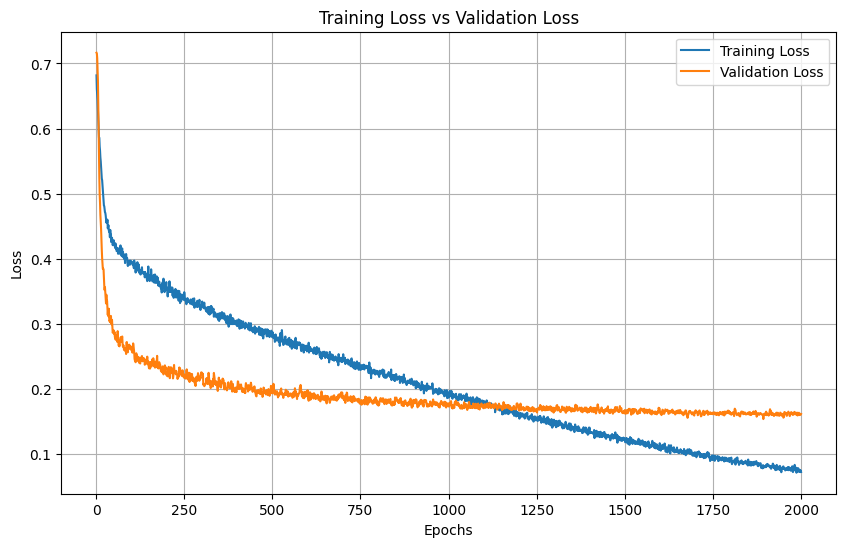

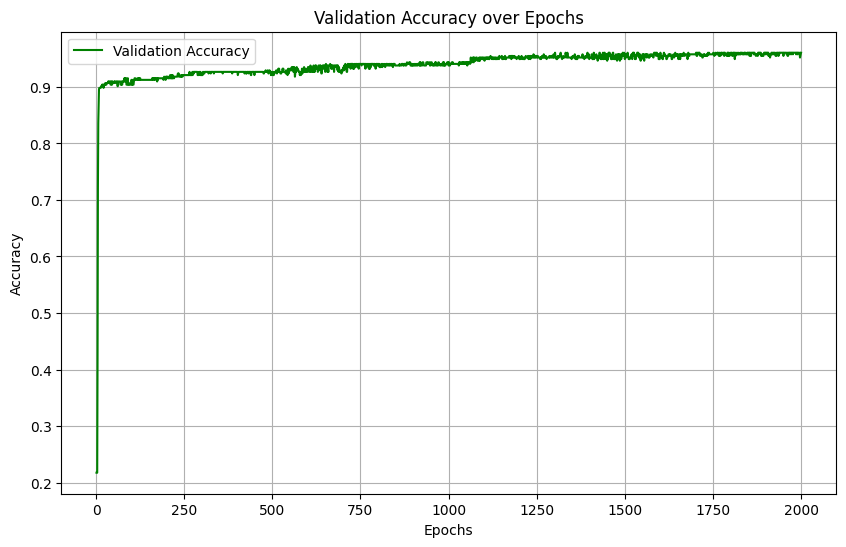

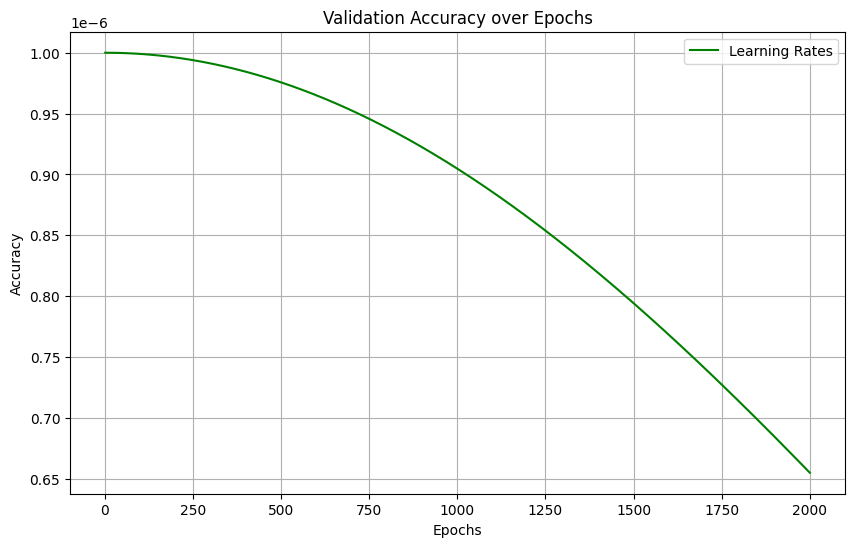

Model for bin 29 saved to GNN-5A_Exp2/model_bin_29.pth
Using 4 GPUs
Training on bin 30/50
Bin 30, Epoch 1/2000, Train Loss: 0.6947, Validation Loss: 0.6972,  Accuracy: 0.5169, LR: 0.000001
Bin 30, Epoch 101/2000, Train Loss: 0.3971, Validation Loss: 0.2685,  Accuracy: 0.8325, LR: 0.000001
Bin 30, Epoch 201/2000, Train Loss: 0.3666, Validation Loss: 0.2296,  Accuracy: 0.8468, LR: 0.000001
Bin 30, Epoch 301/2000, Train Loss: 0.3347, Validation Loss: 0.2211,  Accuracy: 0.8623, LR: 0.000001
Bin 30, Epoch 401/2000, Train Loss: 0.3096, Validation Loss: 0.2163,  Accuracy: 0.8766, LR: 0.000001
Bin 30, Epoch 501/2000, Train Loss: 0.2932, Validation Loss: 0.2009,  Accuracy: 0.8844, LR: 0.000001
Bin 30, Epoch 601/2000, Train Loss: 0.2791, Validation Loss: 0.1993,  Accuracy: 0.8857, LR: 0.000001
Bin 30, Epoch 701/2000, Train Loss: 0.2537, Validation Loss: 0.2040,  Accuracy: 0.9039, LR: 0.000001
Bin 30, Epoch 801/2000, Train Loss: 0.2406, Validation Loss: 0.1969,  Accuracy: 0.9117, LR: 0.000001
Bin

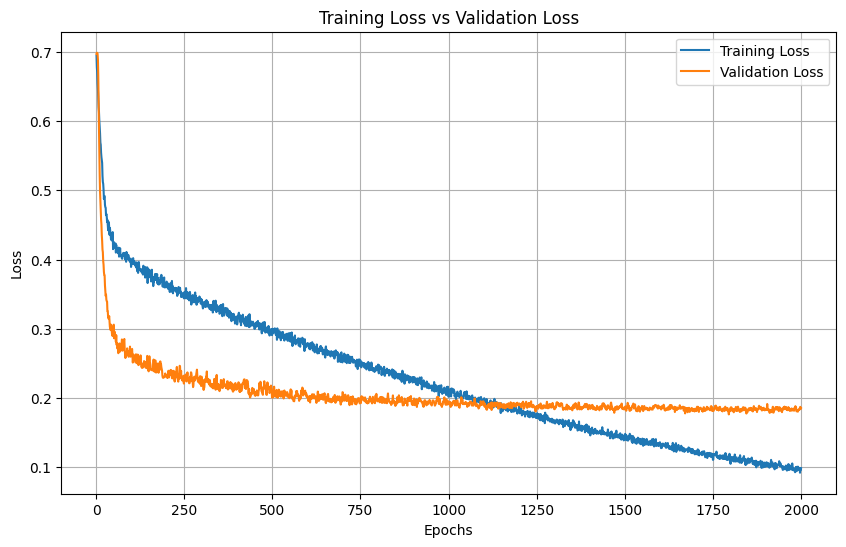

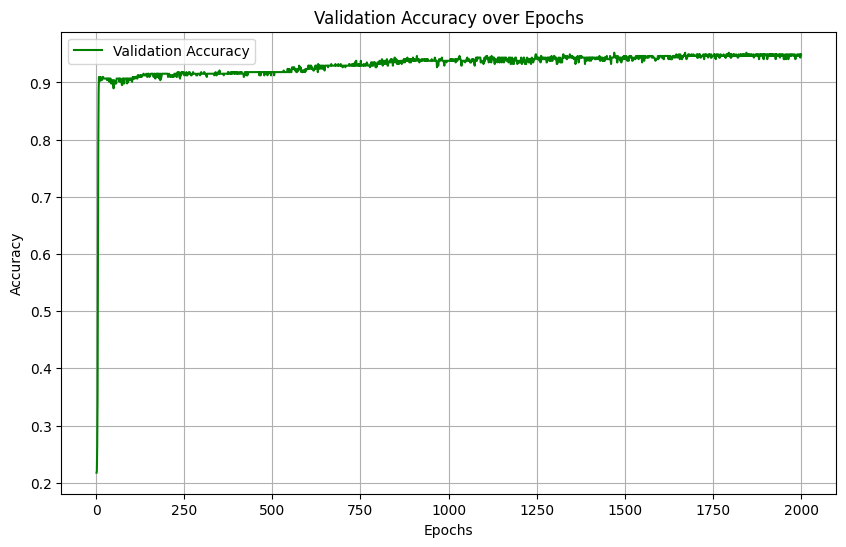

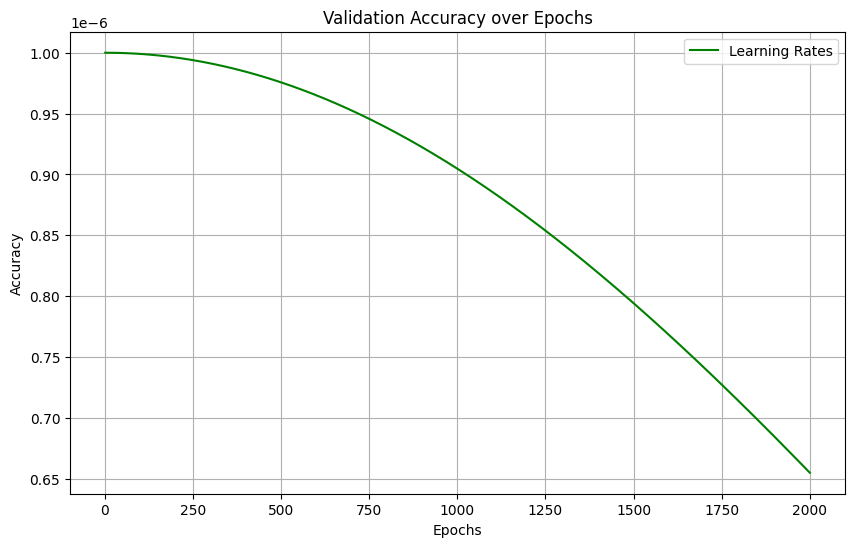

Model for bin 30 saved to GNN-5A_Exp2/model_bin_30.pth
Using 4 GPUs
Training on bin 31/50
Bin 31, Epoch 1/2000, Train Loss: 0.7052, Validation Loss: 0.7033,  Accuracy: 0.5026, LR: 0.000001
Bin 31, Epoch 101/2000, Train Loss: 0.3873, Validation Loss: 0.2577,  Accuracy: 0.8325, LR: 0.000001
Bin 31, Epoch 201/2000, Train Loss: 0.3452, Validation Loss: 0.2315,  Accuracy: 0.8468, LR: 0.000001
Bin 31, Epoch 301/2000, Train Loss: 0.3196, Validation Loss: 0.2128,  Accuracy: 0.8636, LR: 0.000001
Bin 31, Epoch 401/2000, Train Loss: 0.2979, Validation Loss: 0.2149,  Accuracy: 0.8714, LR: 0.000001
Bin 31, Epoch 501/2000, Train Loss: 0.2747, Validation Loss: 0.1959,  Accuracy: 0.8857, LR: 0.000001
Bin 31, Epoch 601/2000, Train Loss: 0.2628, Validation Loss: 0.1908,  Accuracy: 0.9000, LR: 0.000001
Bin 31, Epoch 701/2000, Train Loss: 0.2414, Validation Loss: 0.1858,  Accuracy: 0.9091, LR: 0.000001
Bin 31, Epoch 801/2000, Train Loss: 0.2199, Validation Loss: 0.1755,  Accuracy: 0.9182, LR: 0.000001
Bin

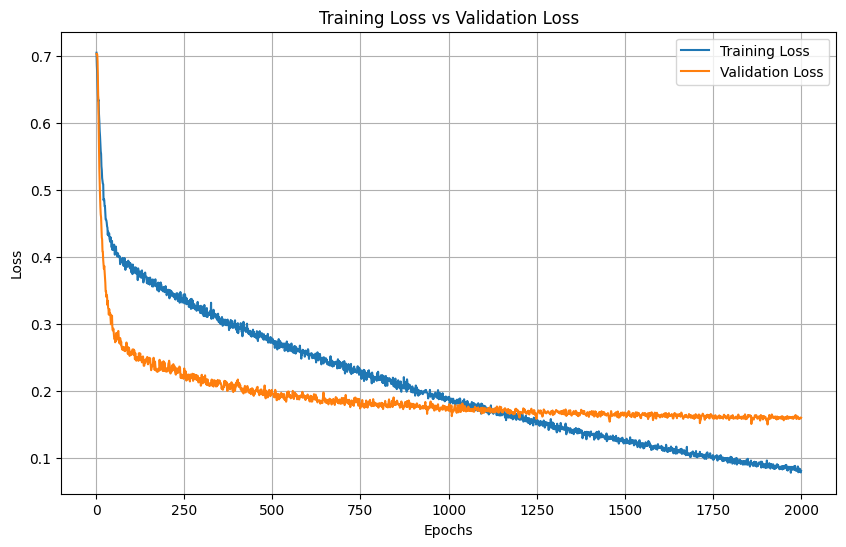

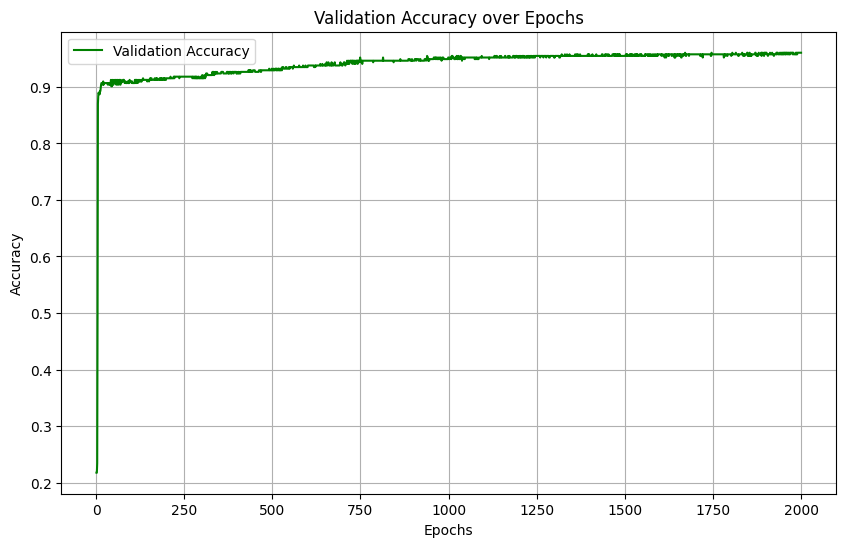

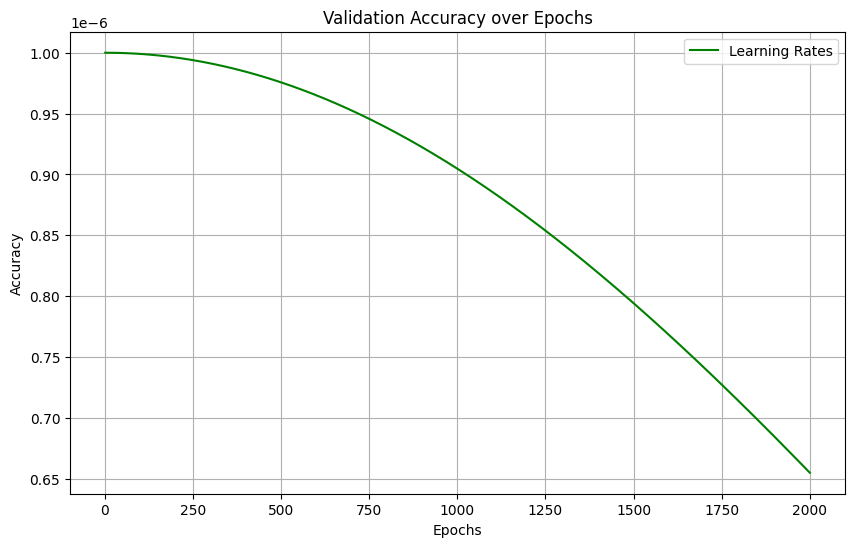

Model for bin 31 saved to GNN-5A_Exp2/model_bin_31.pth
Using 4 GPUs
Training on bin 32/50
Bin 32, Epoch 1/2000, Train Loss: 0.6988, Validation Loss: 0.6800,  Accuracy: 0.5182, LR: 0.000001
Bin 32, Epoch 101/2000, Train Loss: 0.3838, Validation Loss: 0.2724,  Accuracy: 0.8416, LR: 0.000001
Bin 32, Epoch 201/2000, Train Loss: 0.3577, Validation Loss: 0.2435,  Accuracy: 0.8532, LR: 0.000001
Bin 32, Epoch 301/2000, Train Loss: 0.3313, Validation Loss: 0.2411,  Accuracy: 0.8584, LR: 0.000001
Bin 32, Epoch 401/2000, Train Loss: 0.3111, Validation Loss: 0.2212,  Accuracy: 0.8792, LR: 0.000001
Bin 32, Epoch 501/2000, Train Loss: 0.2893, Validation Loss: 0.2240,  Accuracy: 0.8870, LR: 0.000001
Bin 32, Epoch 601/2000, Train Loss: 0.2724, Validation Loss: 0.2072,  Accuracy: 0.8987, LR: 0.000001
Bin 32, Epoch 701/2000, Train Loss: 0.2536, Validation Loss: 0.2062,  Accuracy: 0.9078, LR: 0.000001
Bin 32, Epoch 801/2000, Train Loss: 0.2368, Validation Loss: 0.2021,  Accuracy: 0.9169, LR: 0.000001
Bin

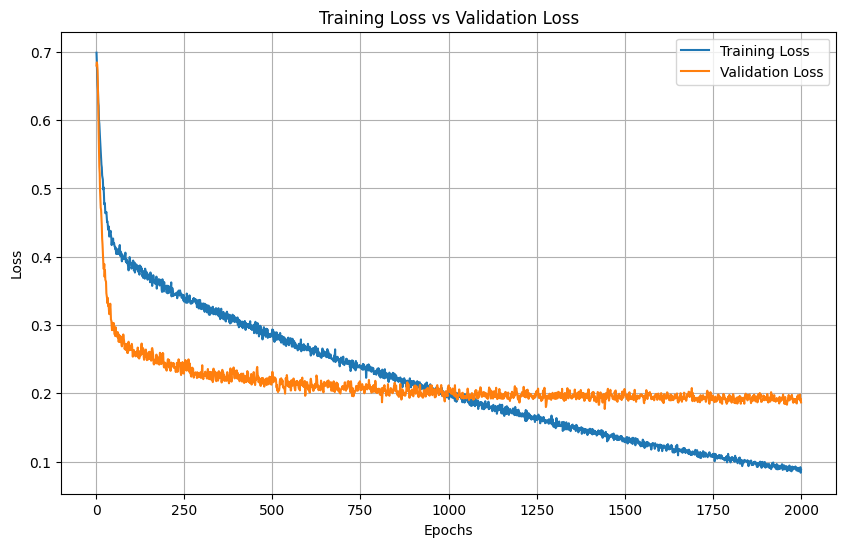

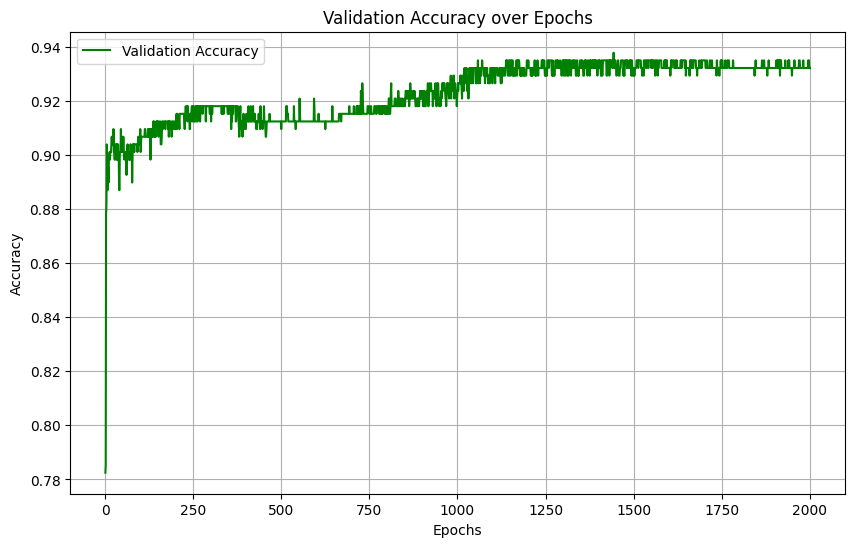

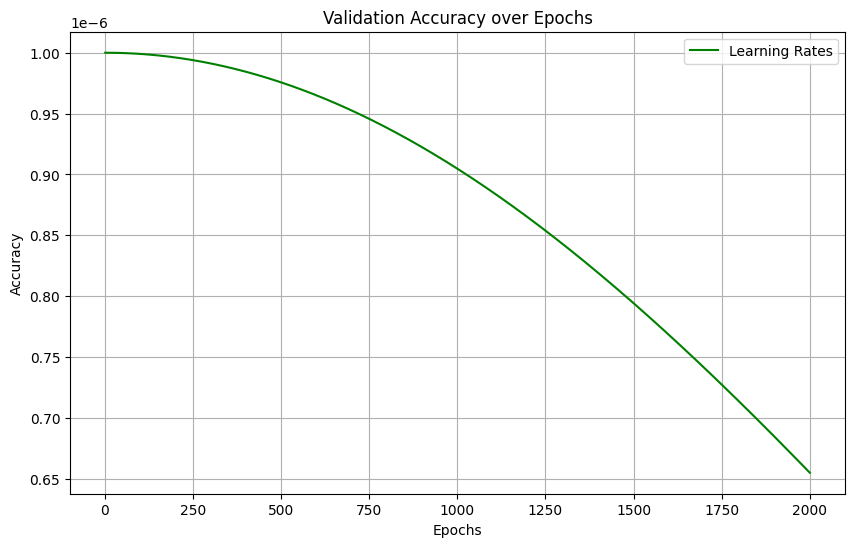

Model for bin 32 saved to GNN-5A_Exp2/model_bin_32.pth
Using 4 GPUs
Training on bin 33/50
Bin 33, Epoch 1/2000, Train Loss: 0.7231, Validation Loss: 0.6639,  Accuracy: 0.4805, LR: 0.000001
Bin 33, Epoch 101/2000, Train Loss: 0.3812, Validation Loss: 0.2657,  Accuracy: 0.8429, LR: 0.000001
Bin 33, Epoch 201/2000, Train Loss: 0.3404, Validation Loss: 0.2399,  Accuracy: 0.8494, LR: 0.000001
Bin 33, Epoch 301/2000, Train Loss: 0.3118, Validation Loss: 0.2323,  Accuracy: 0.8688, LR: 0.000001
Bin 33, Epoch 401/2000, Train Loss: 0.2927, Validation Loss: 0.2282,  Accuracy: 0.8844, LR: 0.000001
Bin 33, Epoch 501/2000, Train Loss: 0.2726, Validation Loss: 0.2151,  Accuracy: 0.8896, LR: 0.000001
Bin 33, Epoch 601/2000, Train Loss: 0.2463, Validation Loss: 0.2050,  Accuracy: 0.9130, LR: 0.000001
Bin 33, Epoch 701/2000, Train Loss: 0.2299, Validation Loss: 0.2018,  Accuracy: 0.9169, LR: 0.000001
Bin 33, Epoch 801/2000, Train Loss: 0.2192, Validation Loss: 0.2045,  Accuracy: 0.9208, LR: 0.000001
Bin

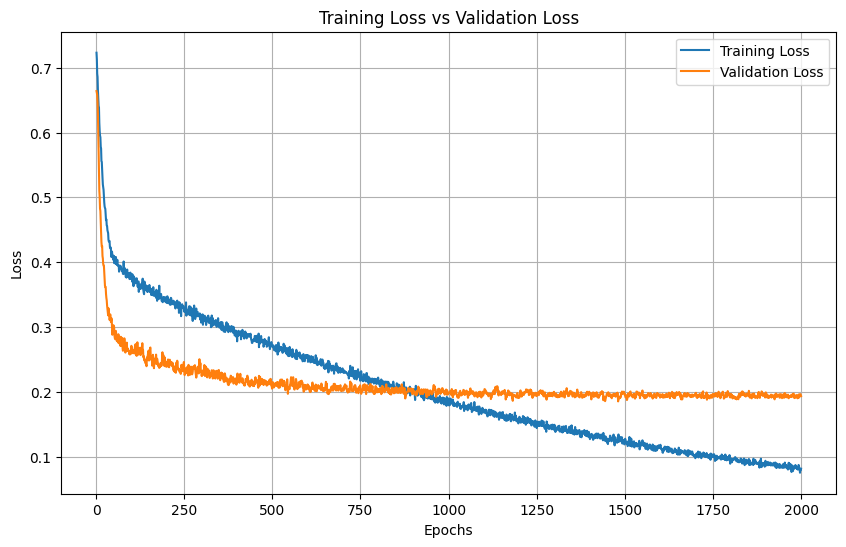

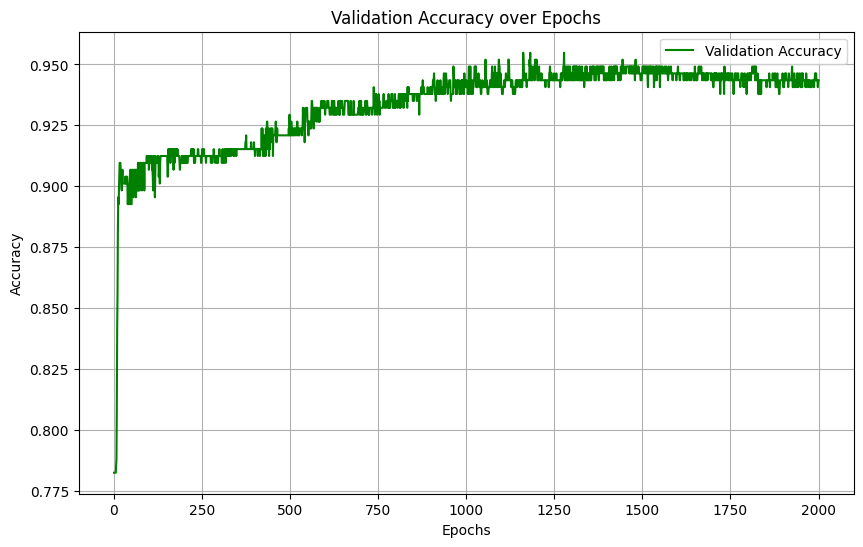

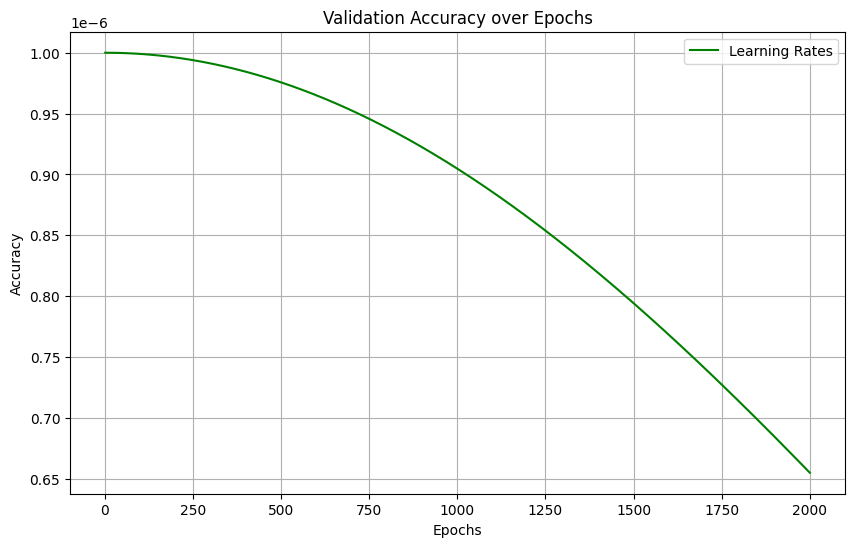

Model for bin 33 saved to GNN-5A_Exp2/model_bin_33.pth
Using 4 GPUs
Training on bin 34/50
Bin 34, Epoch 1/2000, Train Loss: 0.6868, Validation Loss: 0.7055,  Accuracy: 0.5260, LR: 0.000001
Bin 34, Epoch 101/2000, Train Loss: 0.3592, Validation Loss: 0.2510,  Accuracy: 0.8468, LR: 0.000001
Bin 34, Epoch 201/2000, Train Loss: 0.3345, Validation Loss: 0.2249,  Accuracy: 0.8571, LR: 0.000001
Bin 34, Epoch 301/2000, Train Loss: 0.2945, Validation Loss: 0.2077,  Accuracy: 0.8779, LR: 0.000001
Bin 34, Epoch 401/2000, Train Loss: 0.2786, Validation Loss: 0.1987,  Accuracy: 0.8844, LR: 0.000001
Bin 34, Epoch 501/2000, Train Loss: 0.2589, Validation Loss: 0.1913,  Accuracy: 0.9052, LR: 0.000001
Bin 34, Epoch 601/2000, Train Loss: 0.2385, Validation Loss: 0.1845,  Accuracy: 0.9078, LR: 0.000001
Bin 34, Epoch 701/2000, Train Loss: 0.2113, Validation Loss: 0.1778,  Accuracy: 0.9286, LR: 0.000001
Bin 34, Epoch 801/2000, Train Loss: 0.1969, Validation Loss: 0.1845,  Accuracy: 0.9364, LR: 0.000001
Bin

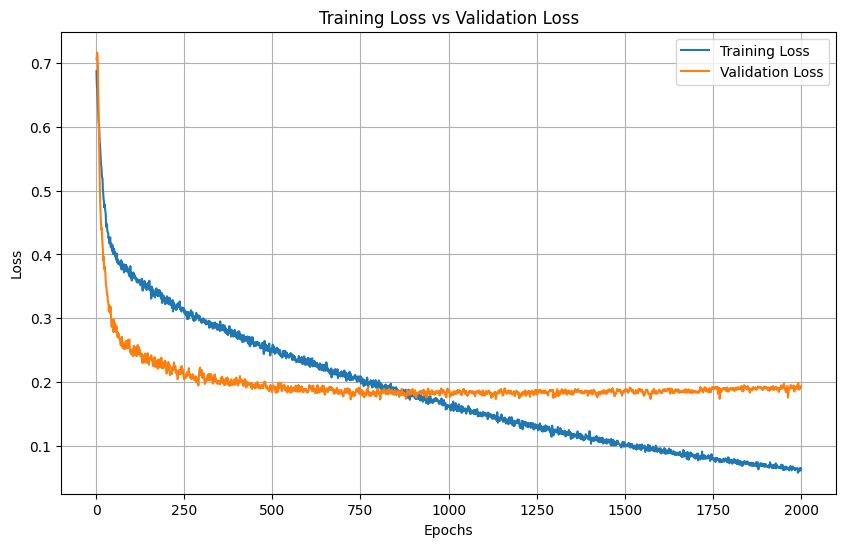

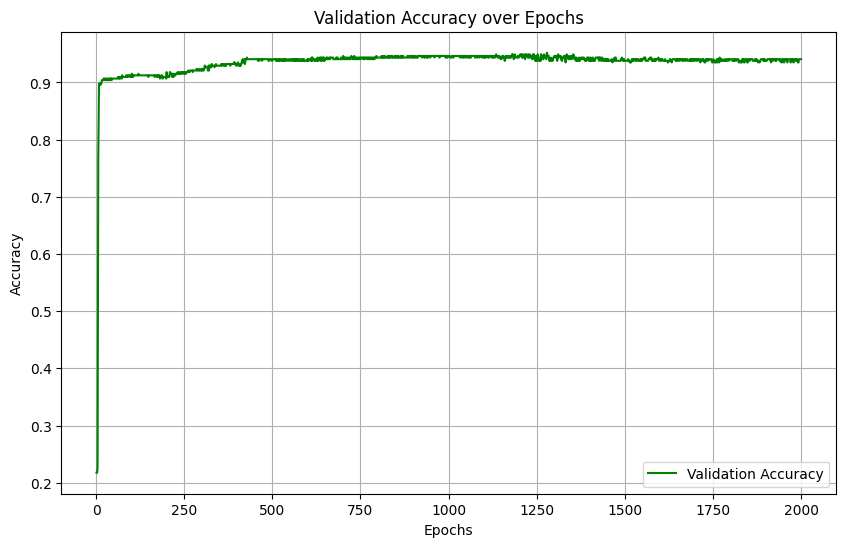

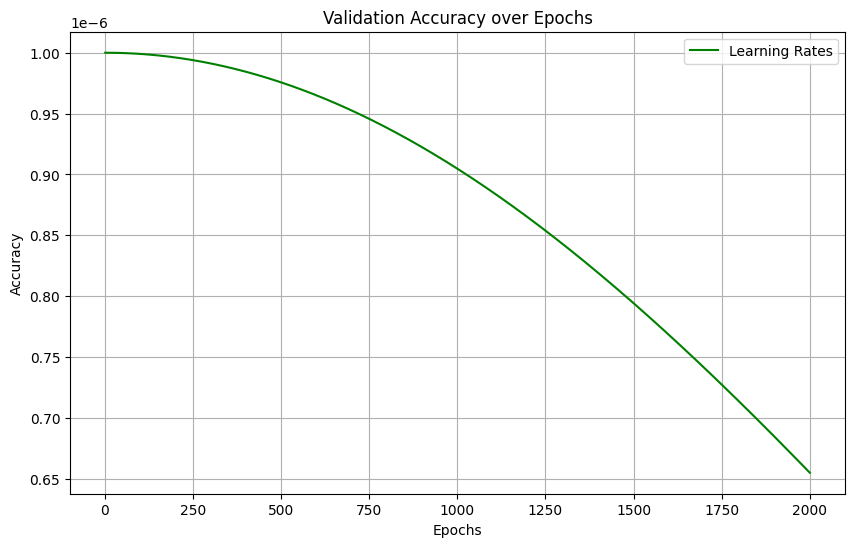

Model for bin 34 saved to GNN-5A_Exp2/model_bin_34.pth
Using 4 GPUs
Training on bin 35/50
Bin 35, Epoch 1/2000, Train Loss: 0.7170, Validation Loss: 0.6789,  Accuracy: 0.5000, LR: 0.000001
Bin 35, Epoch 101/2000, Train Loss: 0.4021, Validation Loss: 0.2481,  Accuracy: 0.8247, LR: 0.000001
Bin 35, Epoch 201/2000, Train Loss: 0.3643, Validation Loss: 0.2413,  Accuracy: 0.8377, LR: 0.000001
Bin 35, Epoch 301/2000, Train Loss: 0.3438, Validation Loss: 0.2146,  Accuracy: 0.8649, LR: 0.000001
Bin 35, Epoch 401/2000, Train Loss: 0.3194, Validation Loss: 0.2034,  Accuracy: 0.8701, LR: 0.000001
Bin 35, Epoch 501/2000, Train Loss: 0.2985, Validation Loss: 0.1999,  Accuracy: 0.8779, LR: 0.000001
Bin 35, Epoch 601/2000, Train Loss: 0.2821, Validation Loss: 0.1895,  Accuracy: 0.8909, LR: 0.000001
Bin 35, Epoch 701/2000, Train Loss: 0.2689, Validation Loss: 0.1867,  Accuracy: 0.8974, LR: 0.000001
Bin 35, Epoch 801/2000, Train Loss: 0.2551, Validation Loss: 0.1828,  Accuracy: 0.9052, LR: 0.000001
Bin

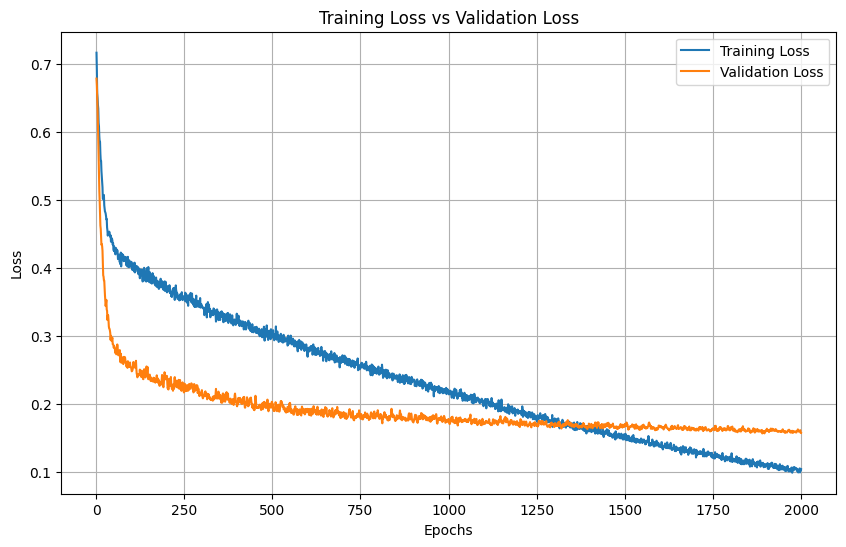

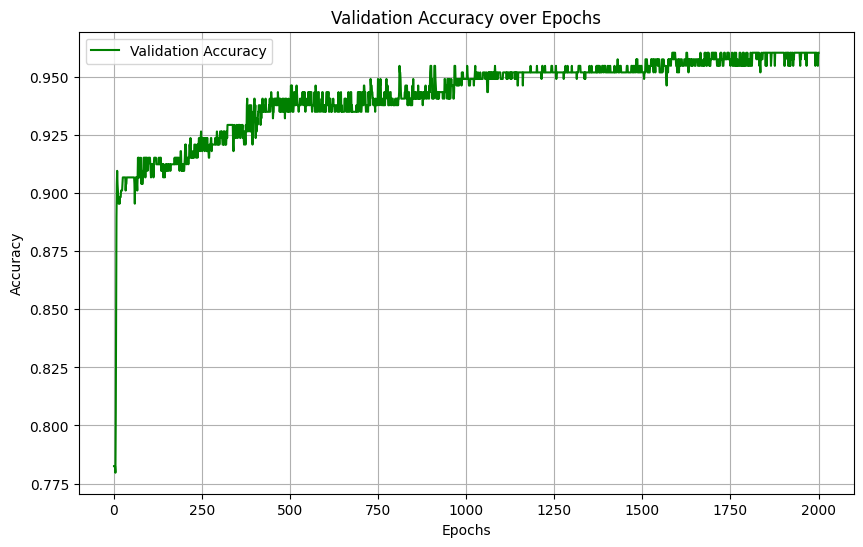

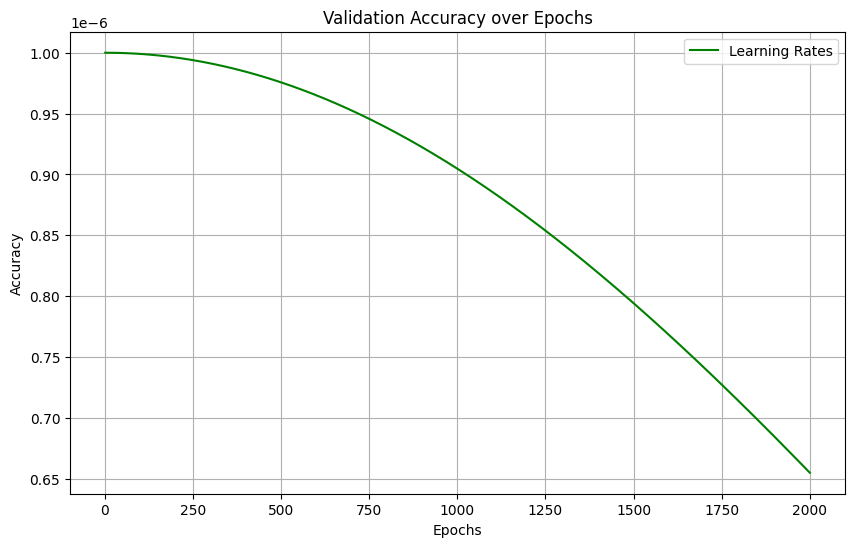

Model for bin 35 saved to GNN-5A_Exp2/model_bin_35.pth
Using 4 GPUs
Training on bin 36/50
Bin 36, Epoch 1/2000, Train Loss: 0.6779, Validation Loss: 0.6799,  Accuracy: 0.5571, LR: 0.000001
Bin 36, Epoch 101/2000, Train Loss: 0.3810, Validation Loss: 0.2545,  Accuracy: 0.8377, LR: 0.000001
Bin 36, Epoch 201/2000, Train Loss: 0.3469, Validation Loss: 0.2387,  Accuracy: 0.8558, LR: 0.000001
Bin 36, Epoch 301/2000, Train Loss: 0.3130, Validation Loss: 0.2186,  Accuracy: 0.8740, LR: 0.000001
Bin 36, Epoch 401/2000, Train Loss: 0.2827, Validation Loss: 0.2102,  Accuracy: 0.8792, LR: 0.000001
Bin 36, Epoch 501/2000, Train Loss: 0.2682, Validation Loss: 0.1956,  Accuracy: 0.8909, LR: 0.000001
Bin 36, Epoch 601/2000, Train Loss: 0.2479, Validation Loss: 0.2047,  Accuracy: 0.9026, LR: 0.000001
Bin 36, Epoch 701/2000, Train Loss: 0.2304, Validation Loss: 0.1943,  Accuracy: 0.9104, LR: 0.000001
Bin 36, Epoch 801/2000, Train Loss: 0.2158, Validation Loss: 0.1935,  Accuracy: 0.9208, LR: 0.000001
Bin

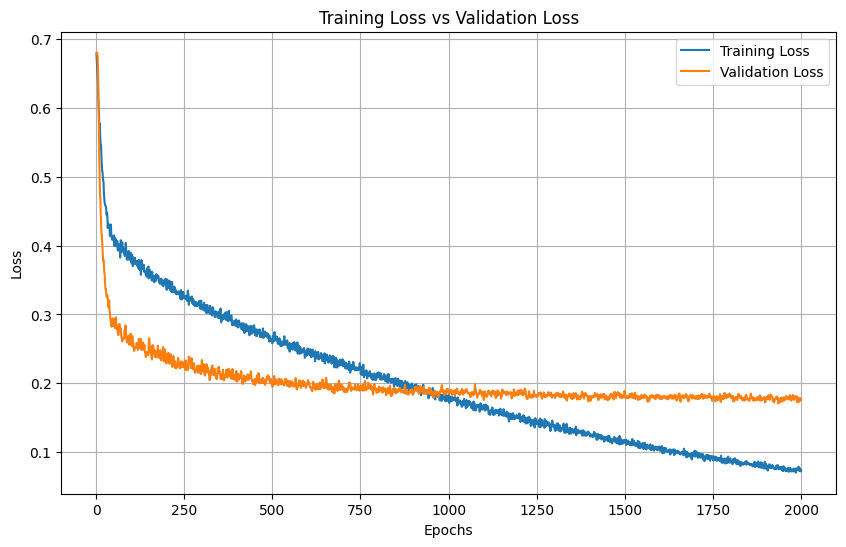

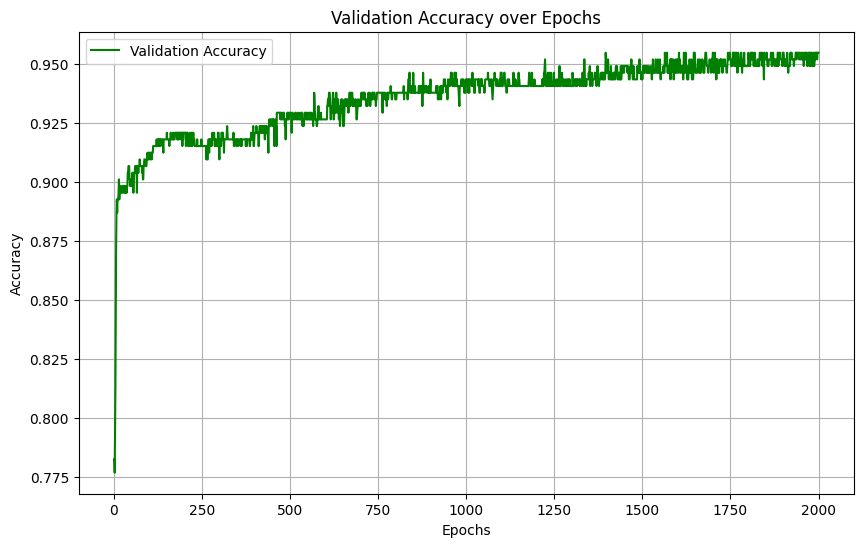

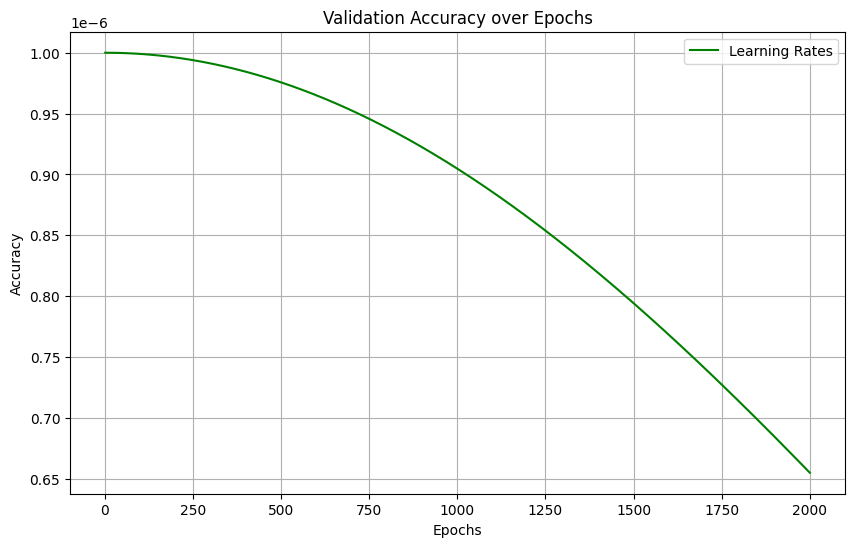

Model for bin 36 saved to GNN-5A_Exp2/model_bin_36.pth
Using 4 GPUs
Training on bin 37/50
Bin 37, Epoch 1/2000, Train Loss: 0.6675, Validation Loss: 0.6724,  Accuracy: 0.5896, LR: 0.000001
Bin 37, Epoch 101/2000, Train Loss: 0.3920, Validation Loss: 0.2688,  Accuracy: 0.8377, LR: 0.000001
Bin 37, Epoch 201/2000, Train Loss: 0.3609, Validation Loss: 0.2488,  Accuracy: 0.8455, LR: 0.000001
Bin 37, Epoch 301/2000, Train Loss: 0.3257, Validation Loss: 0.2175,  Accuracy: 0.8688, LR: 0.000001
Bin 37, Epoch 401/2000, Train Loss: 0.3050, Validation Loss: 0.2098,  Accuracy: 0.8753, LR: 0.000001
Bin 37, Epoch 501/2000, Train Loss: 0.2869, Validation Loss: 0.2024,  Accuracy: 0.8805, LR: 0.000001
Bin 37, Epoch 601/2000, Train Loss: 0.2637, Validation Loss: 0.1948,  Accuracy: 0.8922, LR: 0.000001
Bin 37, Epoch 701/2000, Train Loss: 0.2368, Validation Loss: 0.1923,  Accuracy: 0.9091, LR: 0.000001
Bin 37, Epoch 801/2000, Train Loss: 0.2122, Validation Loss: 0.1868,  Accuracy: 0.9182, LR: 0.000001
Bin

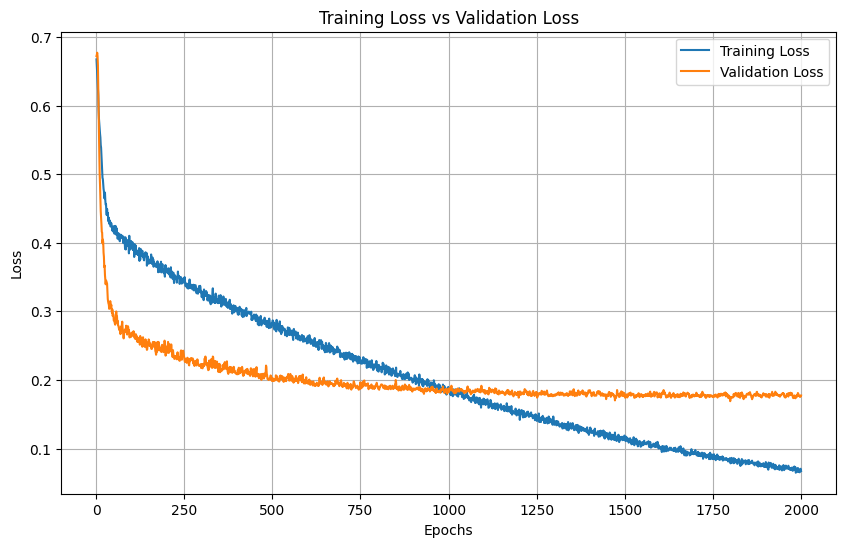

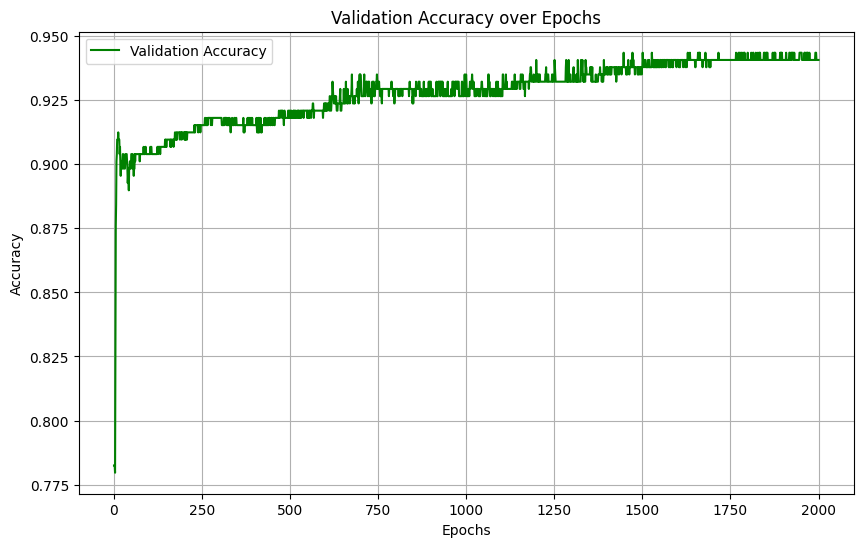

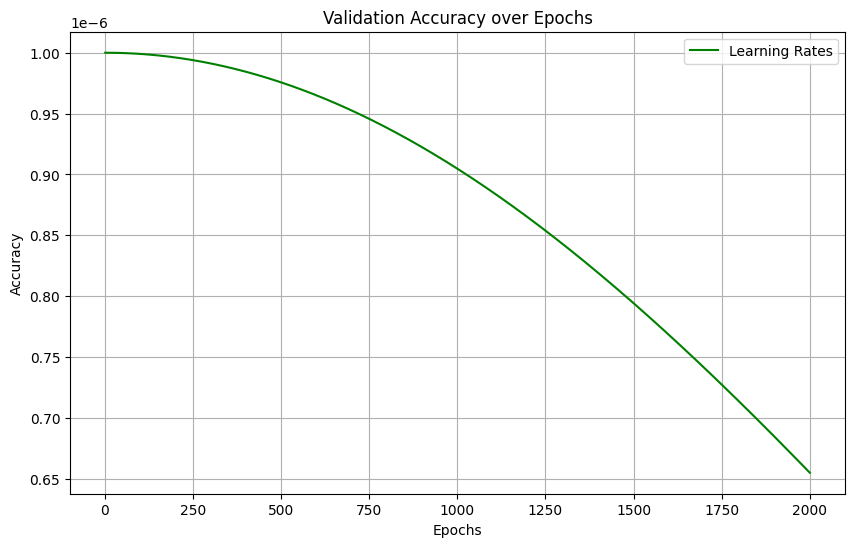

Model for bin 37 saved to GNN-5A_Exp2/model_bin_37.pth
Using 4 GPUs
Training on bin 38/50
Bin 38, Epoch 1/2000, Train Loss: 0.7196, Validation Loss: 0.6705,  Accuracy: 0.4688, LR: 0.000001
Bin 38, Epoch 101/2000, Train Loss: 0.3849, Validation Loss: 0.2711,  Accuracy: 0.8364, LR: 0.000001
Bin 38, Epoch 201/2000, Train Loss: 0.3484, Validation Loss: 0.2346,  Accuracy: 0.8558, LR: 0.000001
Bin 38, Epoch 301/2000, Train Loss: 0.3342, Validation Loss: 0.2243,  Accuracy: 0.8714, LR: 0.000001
Bin 38, Epoch 401/2000, Train Loss: 0.3121, Validation Loss: 0.2046,  Accuracy: 0.8701, LR: 0.000001
Bin 38, Epoch 501/2000, Train Loss: 0.2961, Validation Loss: 0.2021,  Accuracy: 0.8818, LR: 0.000001
Bin 38, Epoch 601/2000, Train Loss: 0.2747, Validation Loss: 0.1983,  Accuracy: 0.8948, LR: 0.000001
Bin 38, Epoch 701/2000, Train Loss: 0.2527, Validation Loss: 0.1939,  Accuracy: 0.9039, LR: 0.000001
Bin 38, Epoch 801/2000, Train Loss: 0.2448, Validation Loss: 0.1876,  Accuracy: 0.9052, LR: 0.000001
Bin

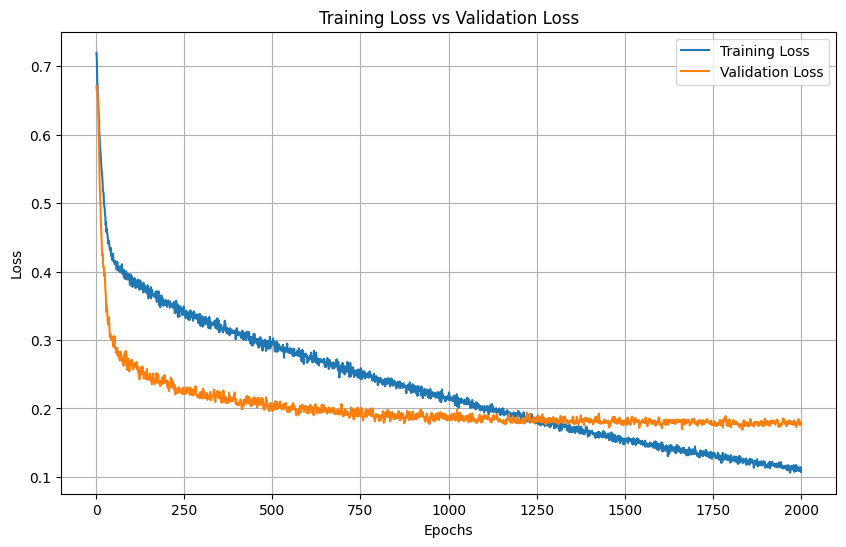

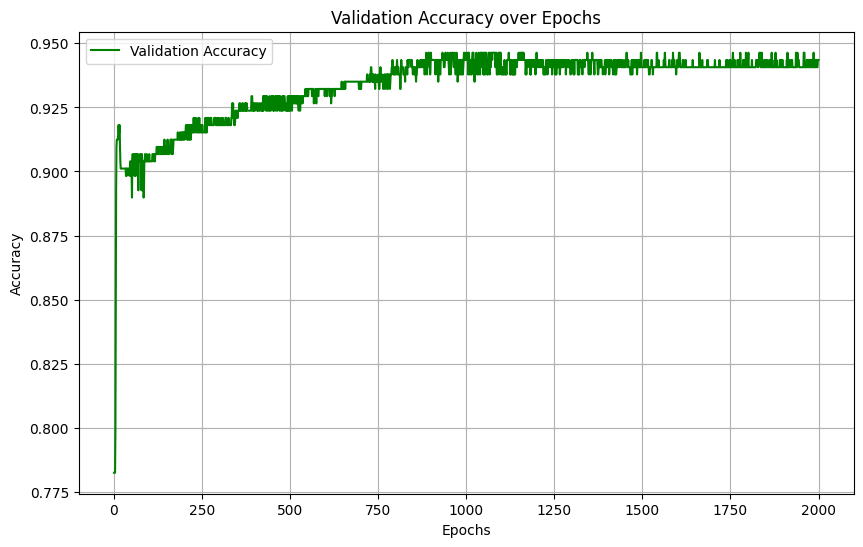

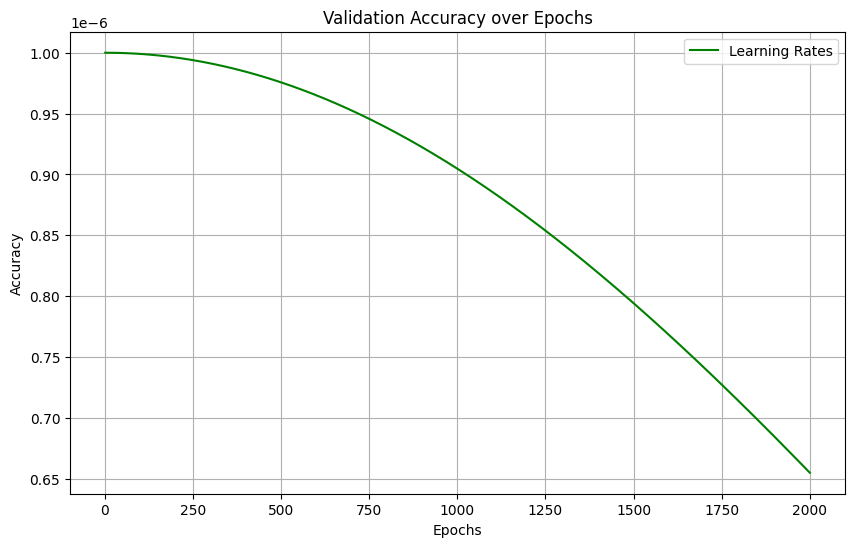

Model for bin 38 saved to GNN-5A_Exp2/model_bin_38.pth
Using 4 GPUs
Training on bin 39/50
Bin 39, Epoch 1/2000, Train Loss: 0.6924, Validation Loss: 0.6897,  Accuracy: 0.5299, LR: 0.000001
Bin 39, Epoch 101/2000, Train Loss: 0.3872, Validation Loss: 0.2606,  Accuracy: 0.8364, LR: 0.000001
Bin 39, Epoch 201/2000, Train Loss: 0.3407, Validation Loss: 0.2380,  Accuracy: 0.8506, LR: 0.000001
Bin 39, Epoch 301/2000, Train Loss: 0.3227, Validation Loss: 0.2209,  Accuracy: 0.8701, LR: 0.000001
Bin 39, Epoch 401/2000, Train Loss: 0.2888, Validation Loss: 0.2036,  Accuracy: 0.8870, LR: 0.000001
Bin 39, Epoch 501/2000, Train Loss: 0.2737, Validation Loss: 0.2047,  Accuracy: 0.9000, LR: 0.000001
Bin 39, Epoch 601/2000, Train Loss: 0.2569, Validation Loss: 0.1973,  Accuracy: 0.9026, LR: 0.000001
Bin 39, Epoch 701/2000, Train Loss: 0.2359, Validation Loss: 0.1896,  Accuracy: 0.9195, LR: 0.000001
Bin 39, Epoch 801/2000, Train Loss: 0.2188, Validation Loss: 0.1857,  Accuracy: 0.9234, LR: 0.000001
Bin

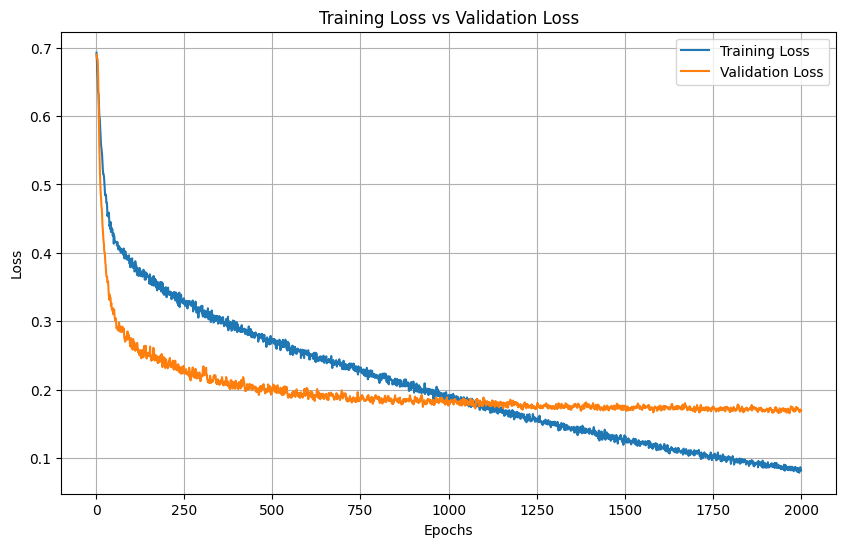

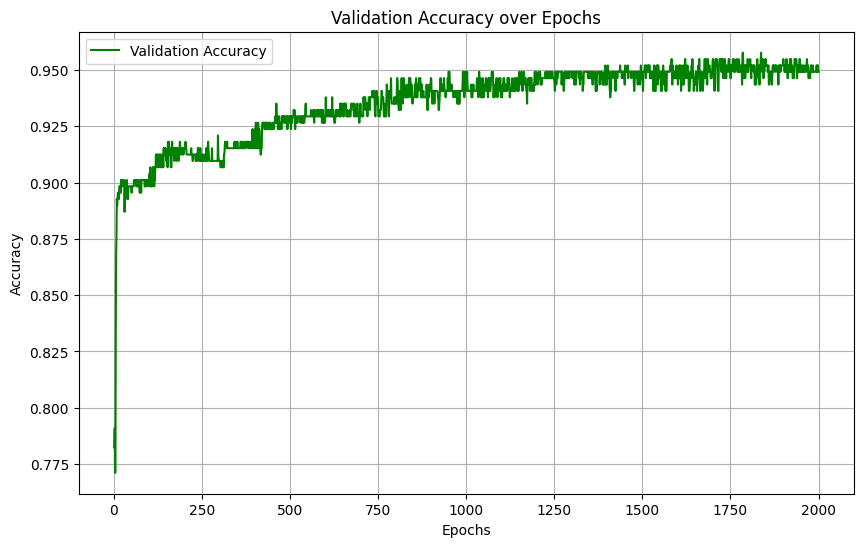

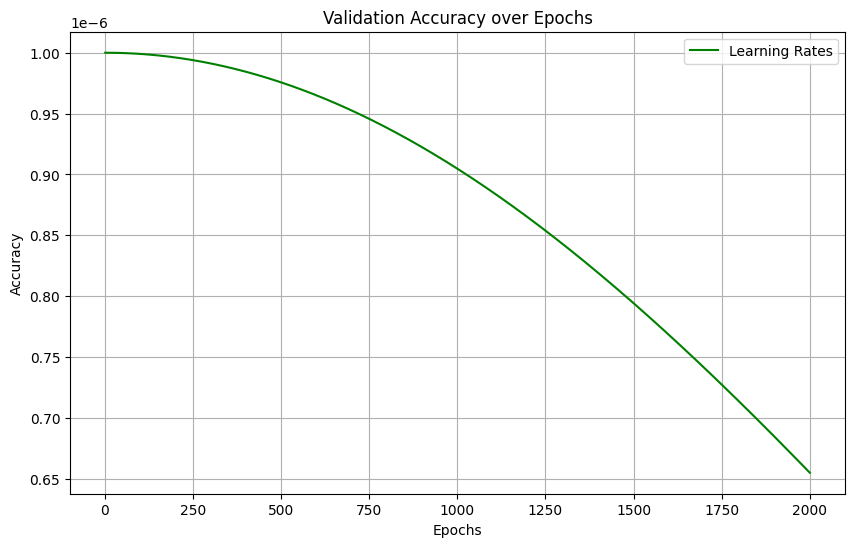

Model for bin 39 saved to GNN-5A_Exp2/model_bin_39.pth
Using 4 GPUs
Training on bin 40/50
Bin 40, Epoch 1/2000, Train Loss: 0.7039, Validation Loss: 0.6711,  Accuracy: 0.4883, LR: 0.000001
Bin 40, Epoch 101/2000, Train Loss: 0.3847, Validation Loss: 0.2651,  Accuracy: 0.8351, LR: 0.000001
Bin 40, Epoch 201/2000, Train Loss: 0.3562, Validation Loss: 0.2407,  Accuracy: 0.8455, LR: 0.000001
Bin 40, Epoch 301/2000, Train Loss: 0.3303, Validation Loss: 0.2298,  Accuracy: 0.8610, LR: 0.000001
Bin 40, Epoch 401/2000, Train Loss: 0.3113, Validation Loss: 0.2174,  Accuracy: 0.8779, LR: 0.000001
Bin 40, Epoch 501/2000, Train Loss: 0.2794, Validation Loss: 0.2026,  Accuracy: 0.8831, LR: 0.000001
Bin 40, Epoch 601/2000, Train Loss: 0.2763, Validation Loss: 0.1994,  Accuracy: 0.8922, LR: 0.000001
Bin 40, Epoch 701/2000, Train Loss: 0.2444, Validation Loss: 0.1978,  Accuracy: 0.9026, LR: 0.000001
Bin 40, Epoch 801/2000, Train Loss: 0.2298, Validation Loss: 0.1989,  Accuracy: 0.9130, LR: 0.000001
Bin

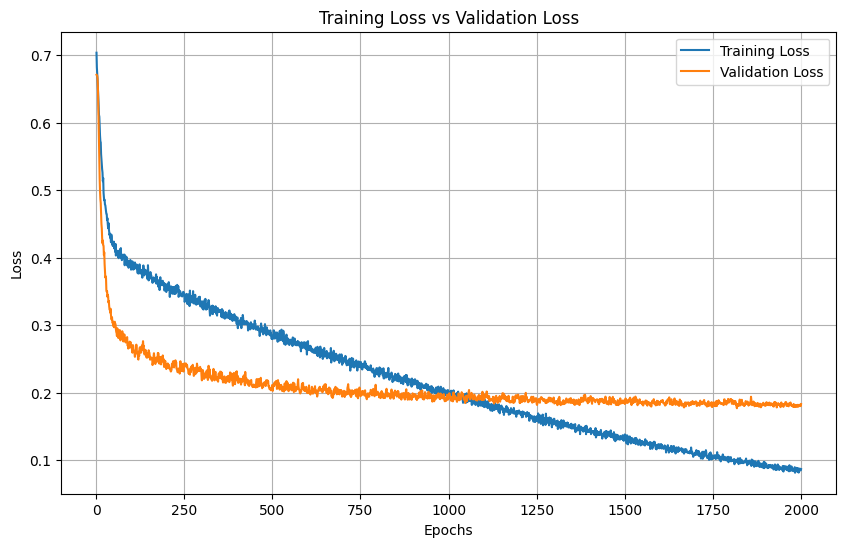

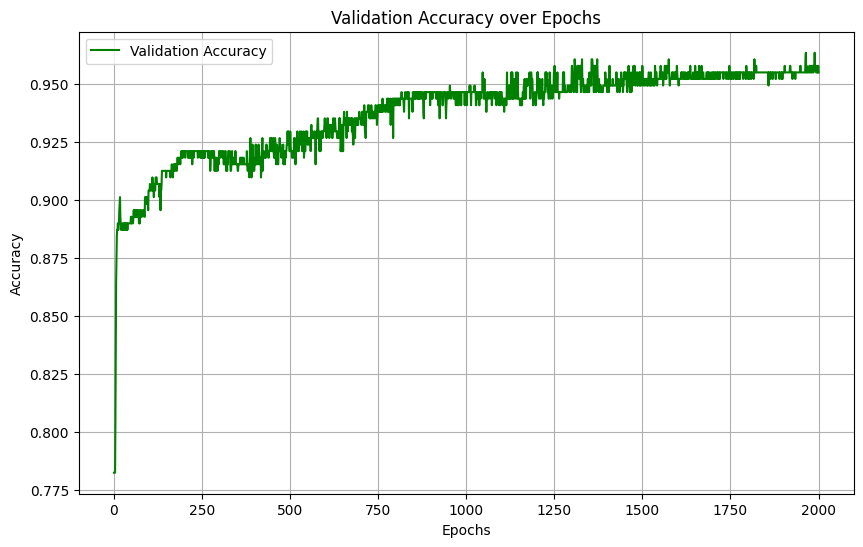

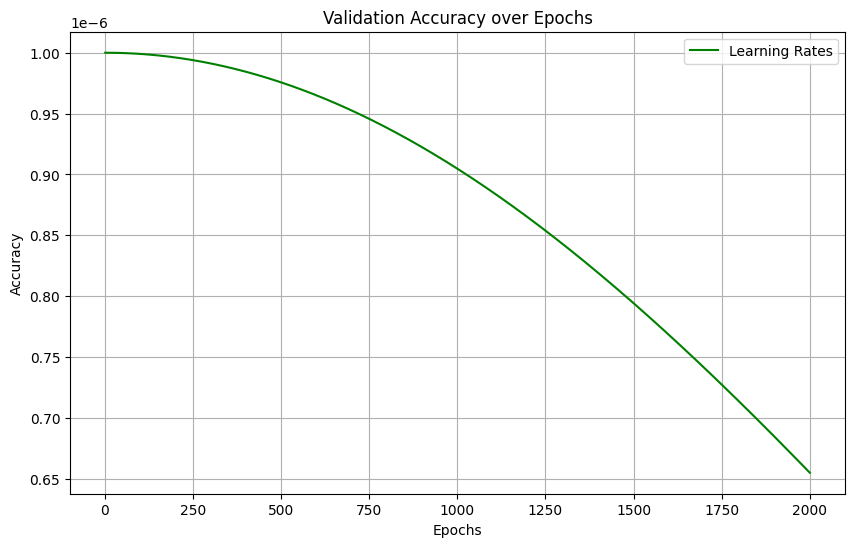

Model for bin 40 saved to GNN-5A_Exp2/model_bin_40.pth
Using 4 GPUs
Training on bin 41/50
Bin 41, Epoch 1/2000, Train Loss: 0.7185, Validation Loss: 0.7071,  Accuracy: 0.5208, LR: 0.000001
Bin 41, Epoch 101/2000, Train Loss: 0.3927, Validation Loss: 0.2611,  Accuracy: 0.8260, LR: 0.000001
Bin 41, Epoch 201/2000, Train Loss: 0.3435, Validation Loss: 0.2342,  Accuracy: 0.8416, LR: 0.000001
Bin 41, Epoch 301/2000, Train Loss: 0.3325, Validation Loss: 0.2285,  Accuracy: 0.8610, LR: 0.000001
Bin 41, Epoch 401/2000, Train Loss: 0.3071, Validation Loss: 0.2179,  Accuracy: 0.8740, LR: 0.000001
Bin 41, Epoch 501/2000, Train Loss: 0.2862, Validation Loss: 0.2038,  Accuracy: 0.8818, LR: 0.000001
Bin 41, Epoch 601/2000, Train Loss: 0.2707, Validation Loss: 0.2040,  Accuracy: 0.8987, LR: 0.000001
Bin 41, Epoch 701/2000, Train Loss: 0.2509, Validation Loss: 0.2029,  Accuracy: 0.9065, LR: 0.000001
Bin 41, Epoch 801/2000, Train Loss: 0.2349, Validation Loss: 0.1959,  Accuracy: 0.9130, LR: 0.000001
Bin

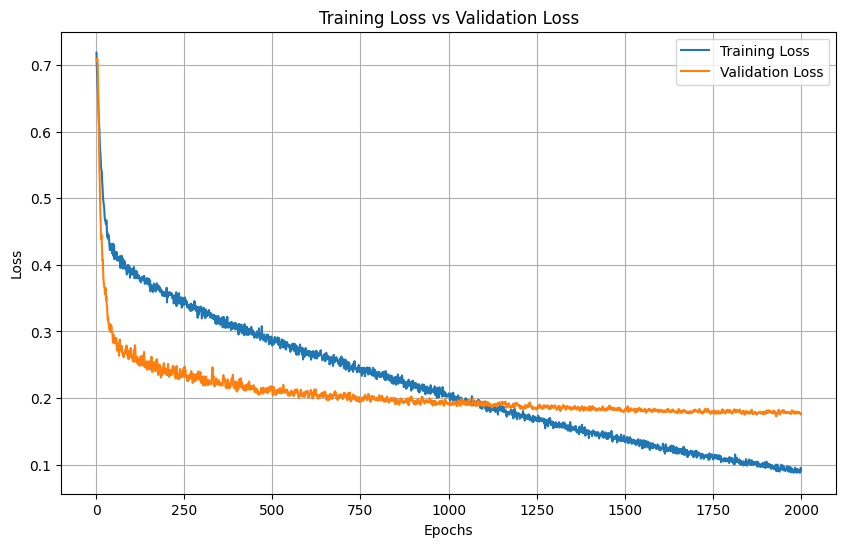

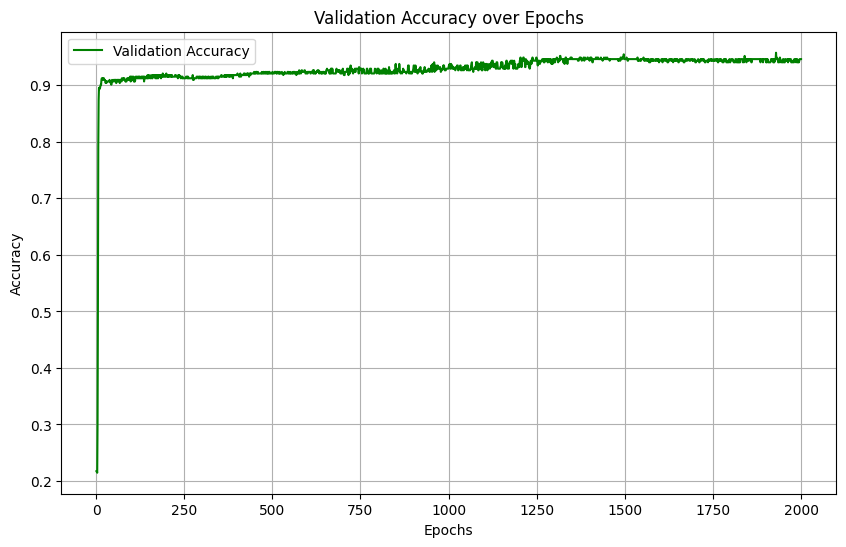

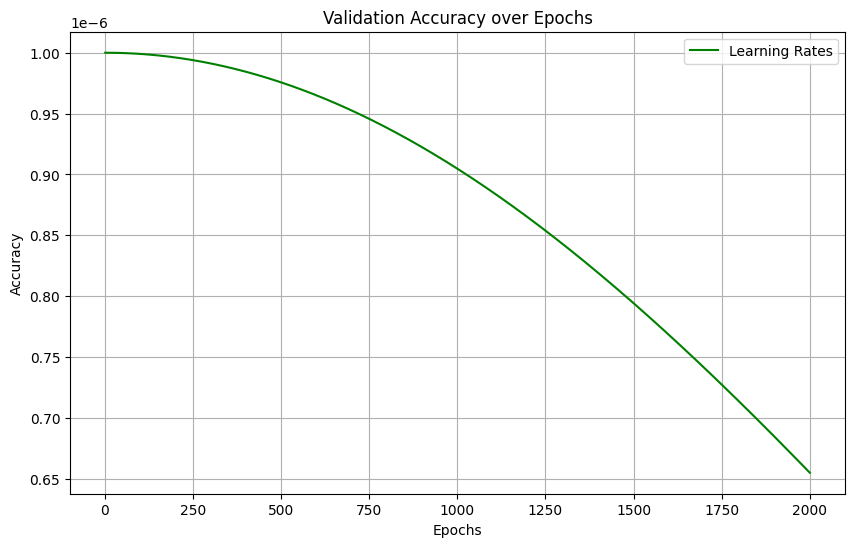

Model for bin 41 saved to GNN-5A_Exp2/model_bin_41.pth
Using 4 GPUs
Training on bin 42/50
Bin 42, Epoch 1/2000, Train Loss: 0.7287, Validation Loss: 0.6753,  Accuracy: 0.4532, LR: 0.000001
Bin 42, Epoch 101/2000, Train Loss: 0.3932, Validation Loss: 0.2689,  Accuracy: 0.8377, LR: 0.000001
Bin 42, Epoch 201/2000, Train Loss: 0.3501, Validation Loss: 0.2510,  Accuracy: 0.8481, LR: 0.000001
Bin 42, Epoch 301/2000, Train Loss: 0.3158, Validation Loss: 0.2272,  Accuracy: 0.8662, LR: 0.000001
Bin 42, Epoch 401/2000, Train Loss: 0.2950, Validation Loss: 0.2056,  Accuracy: 0.8831, LR: 0.000001
Bin 42, Epoch 501/2000, Train Loss: 0.2780, Validation Loss: 0.1990,  Accuracy: 0.8935, LR: 0.000001
Bin 42, Epoch 601/2000, Train Loss: 0.2588, Validation Loss: 0.2003,  Accuracy: 0.9039, LR: 0.000001
Bin 42, Epoch 701/2000, Train Loss: 0.2427, Validation Loss: 0.2042,  Accuracy: 0.9104, LR: 0.000001
Bin 42, Epoch 801/2000, Train Loss: 0.2210, Validation Loss: 0.1973,  Accuracy: 0.9195, LR: 0.000001
Bin

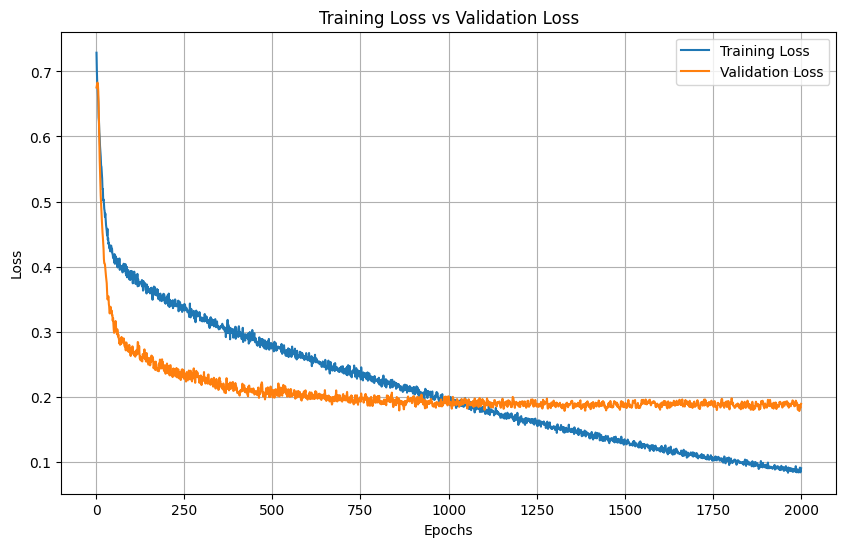

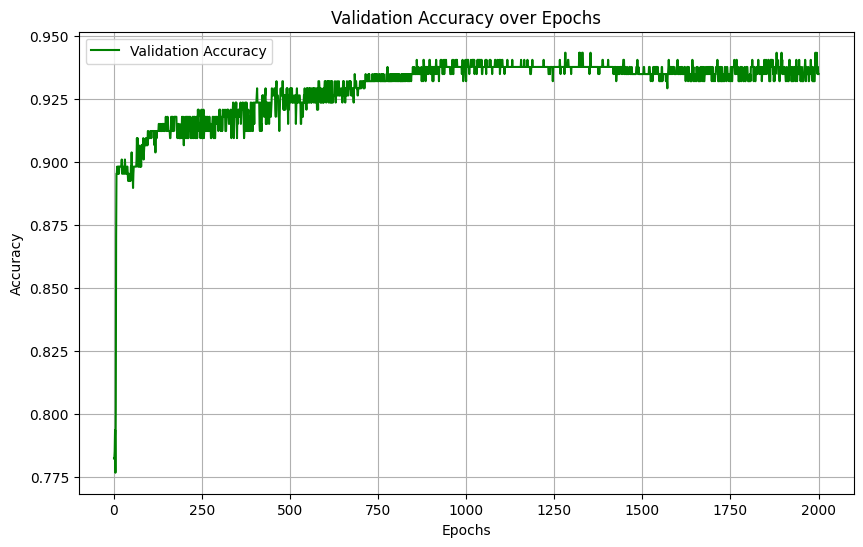

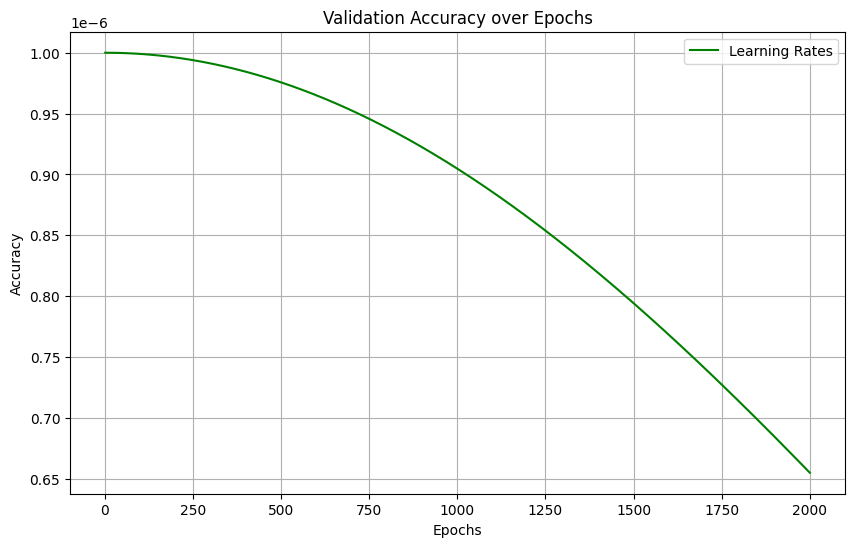

Model for bin 42 saved to GNN-5A_Exp2/model_bin_42.pth
Using 4 GPUs
Training on bin 43/50
Bin 43, Epoch 1/2000, Train Loss: 0.6864, Validation Loss: 0.6755,  Accuracy: 0.5597, LR: 0.000001
Bin 43, Epoch 101/2000, Train Loss: 0.3877, Validation Loss: 0.2643,  Accuracy: 0.8442, LR: 0.000001
Bin 43, Epoch 201/2000, Train Loss: 0.3503, Validation Loss: 0.2438,  Accuracy: 0.8506, LR: 0.000001
Bin 43, Epoch 301/2000, Train Loss: 0.3279, Validation Loss: 0.2218,  Accuracy: 0.8649, LR: 0.000001
Bin 43, Epoch 401/2000, Train Loss: 0.2980, Validation Loss: 0.2100,  Accuracy: 0.8831, LR: 0.000001
Bin 43, Epoch 501/2000, Train Loss: 0.2734, Validation Loss: 0.2046,  Accuracy: 0.8857, LR: 0.000001
Bin 43, Epoch 601/2000, Train Loss: 0.2507, Validation Loss: 0.2019,  Accuracy: 0.9052, LR: 0.000001
Bin 43, Epoch 701/2000, Train Loss: 0.2418, Validation Loss: 0.2007,  Accuracy: 0.9091, LR: 0.000001
Bin 43, Epoch 801/2000, Train Loss: 0.2174, Validation Loss: 0.1971,  Accuracy: 0.9182, LR: 0.000001
Bin

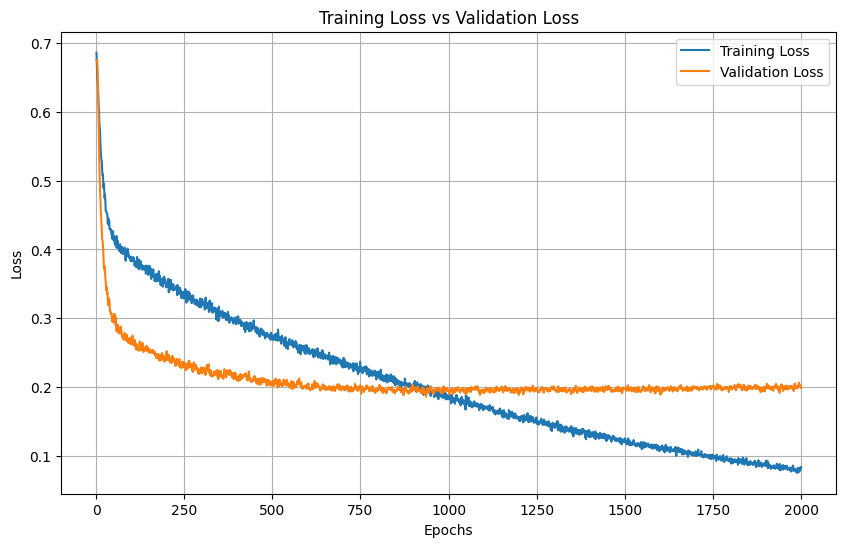

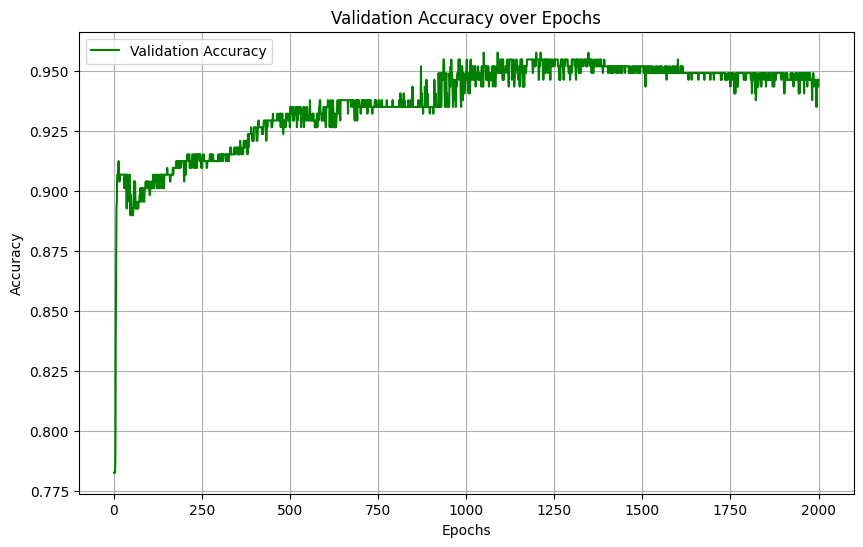

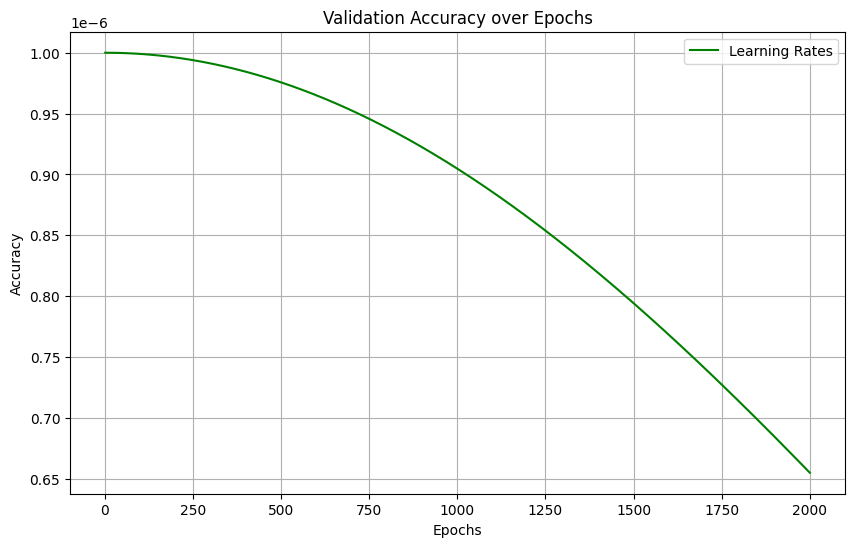

Model for bin 43 saved to GNN-5A_Exp2/model_bin_43.pth
Using 4 GPUs
Training on bin 44/50
Bin 44, Epoch 1/2000, Train Loss: 0.6809, Validation Loss: 0.6984,  Accuracy: 0.5636, LR: 0.000001
Bin 44, Epoch 101/2000, Train Loss: 0.3905, Validation Loss: 0.2596,  Accuracy: 0.8364, LR: 0.000001
Bin 44, Epoch 201/2000, Train Loss: 0.3602, Validation Loss: 0.2388,  Accuracy: 0.8532, LR: 0.000001
Bin 44, Epoch 301/2000, Train Loss: 0.3220, Validation Loss: 0.2176,  Accuracy: 0.8675, LR: 0.000001
Bin 44, Epoch 401/2000, Train Loss: 0.2993, Validation Loss: 0.2025,  Accuracy: 0.8805, LR: 0.000001
Bin 44, Epoch 501/2000, Train Loss: 0.2935, Validation Loss: 0.2013,  Accuracy: 0.8909, LR: 0.000001
Bin 44, Epoch 601/2000, Train Loss: 0.2669, Validation Loss: 0.1958,  Accuracy: 0.8961, LR: 0.000001
Bin 44, Epoch 701/2000, Train Loss: 0.2529, Validation Loss: 0.1969,  Accuracy: 0.9130, LR: 0.000001
Bin 44, Epoch 801/2000, Train Loss: 0.2278, Validation Loss: 0.1887,  Accuracy: 0.9065, LR: 0.000001
Bin

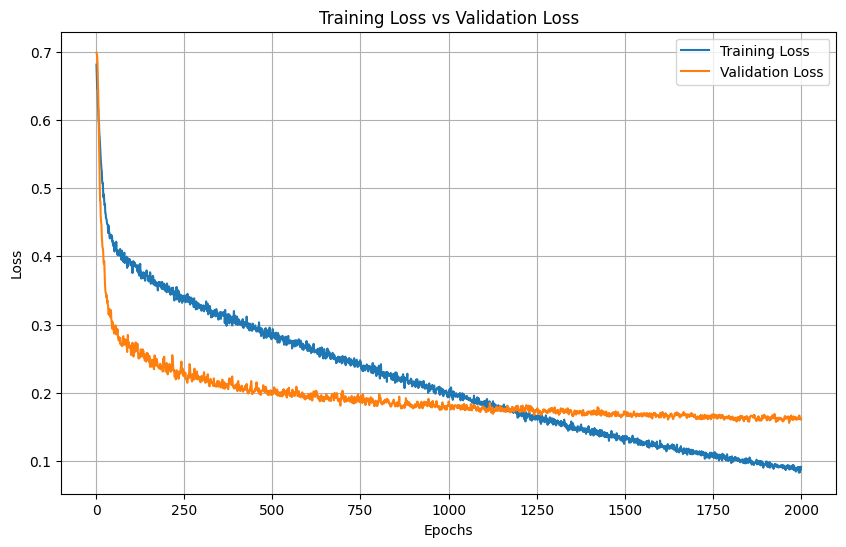

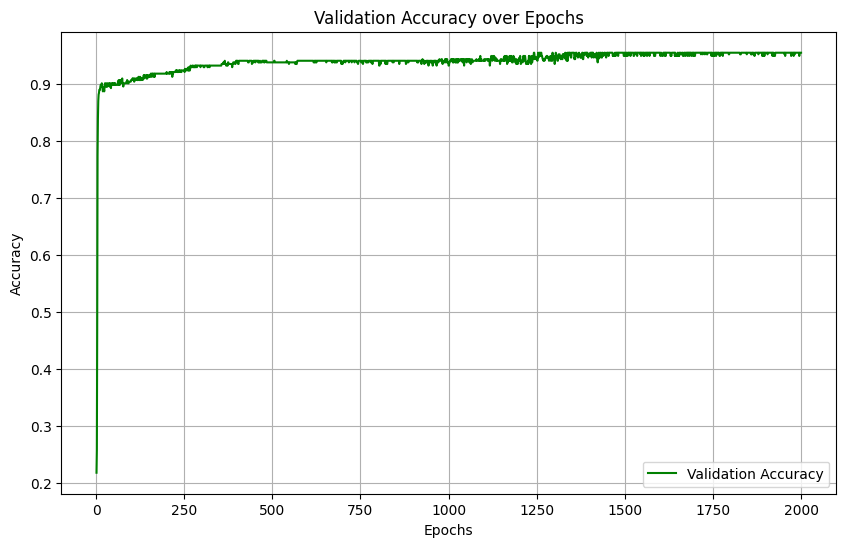

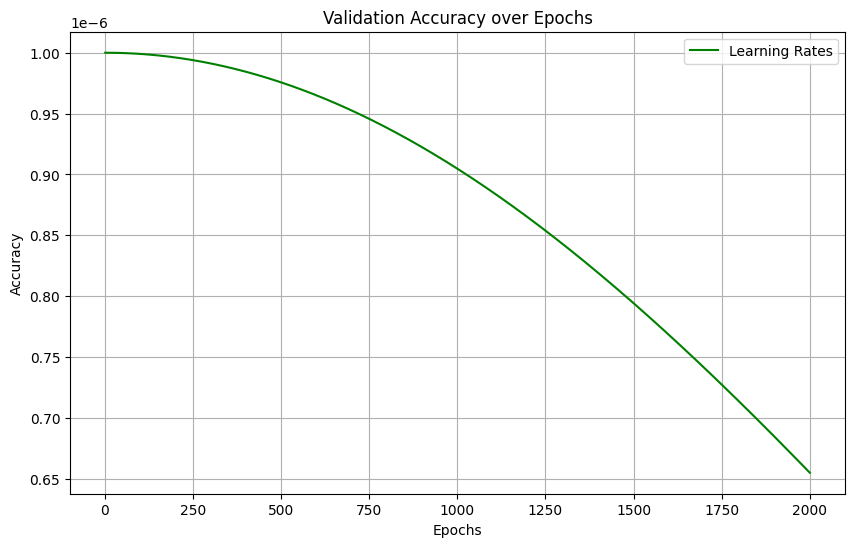

Model for bin 44 saved to GNN-5A_Exp2/model_bin_44.pth
Using 4 GPUs
Training on bin 45/50
Bin 45, Epoch 1/2000, Train Loss: 0.7001, Validation Loss: 0.7028,  Accuracy: 0.5026, LR: 0.000001
Bin 45, Epoch 101/2000, Train Loss: 0.3853, Validation Loss: 0.2682,  Accuracy: 0.8312, LR: 0.000001
Bin 45, Epoch 201/2000, Train Loss: 0.3542, Validation Loss: 0.2322,  Accuracy: 0.8429, LR: 0.000001
Bin 45, Epoch 301/2000, Train Loss: 0.3219, Validation Loss: 0.2230,  Accuracy: 0.8662, LR: 0.000001
Bin 45, Epoch 401/2000, Train Loss: 0.2843, Validation Loss: 0.2134,  Accuracy: 0.8792, LR: 0.000001
Bin 45, Epoch 501/2000, Train Loss: 0.2720, Validation Loss: 0.2087,  Accuracy: 0.8987, LR: 0.000001
Bin 45, Epoch 601/2000, Train Loss: 0.2524, Validation Loss: 0.2079,  Accuracy: 0.9143, LR: 0.000001
Bin 45, Epoch 701/2000, Train Loss: 0.2266, Validation Loss: 0.1975,  Accuracy: 0.9260, LR: 0.000001
Bin 45, Epoch 801/2000, Train Loss: 0.2189, Validation Loss: 0.2006,  Accuracy: 0.9247, LR: 0.000001
Bin

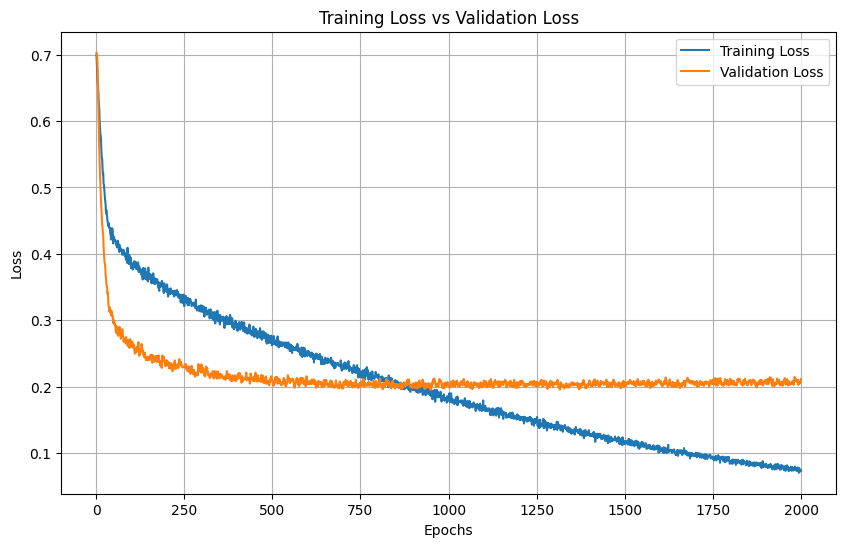

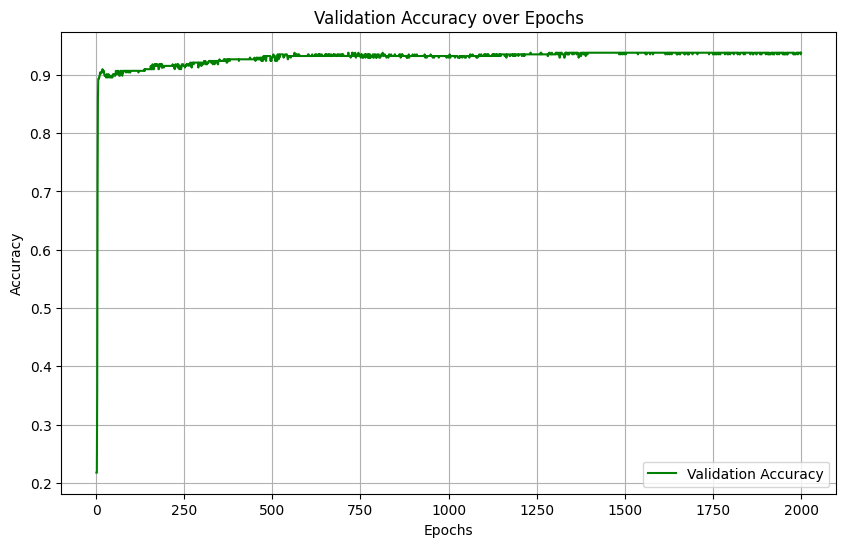

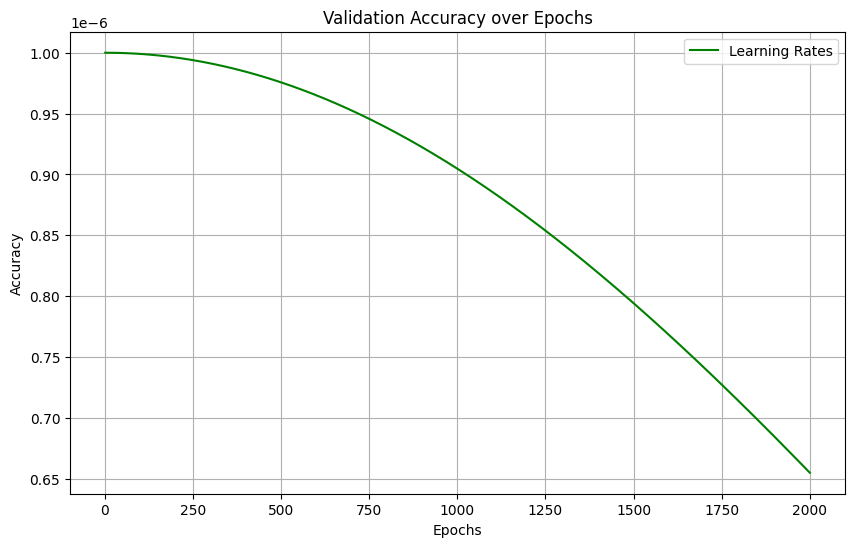

Model for bin 45 saved to GNN-5A_Exp2/model_bin_45.pth
Using 4 GPUs
Training on bin 46/50
Bin 46, Epoch 1/2000, Train Loss: 0.7243, Validation Loss: 0.6704,  Accuracy: 0.4688, LR: 0.000001
Bin 46, Epoch 101/2000, Train Loss: 0.3826, Validation Loss: 0.2532,  Accuracy: 0.8312, LR: 0.000001
Bin 46, Epoch 201/2000, Train Loss: 0.3448, Validation Loss: 0.2159,  Accuracy: 0.8481, LR: 0.000001
Bin 46, Epoch 301/2000, Train Loss: 0.3261, Validation Loss: 0.2091,  Accuracy: 0.8675, LR: 0.000001
Bin 46, Epoch 401/2000, Train Loss: 0.3036, Validation Loss: 0.1925,  Accuracy: 0.8818, LR: 0.000001
Bin 46, Epoch 501/2000, Train Loss: 0.2830, Validation Loss: 0.1996,  Accuracy: 0.8922, LR: 0.000001
Bin 46, Epoch 601/2000, Train Loss: 0.2676, Validation Loss: 0.1955,  Accuracy: 0.8961, LR: 0.000001
Bin 46, Epoch 701/2000, Train Loss: 0.2602, Validation Loss: 0.1857,  Accuracy: 0.9013, LR: 0.000001
Bin 46, Epoch 801/2000, Train Loss: 0.2377, Validation Loss: 0.1825,  Accuracy: 0.9052, LR: 0.000001
Bin

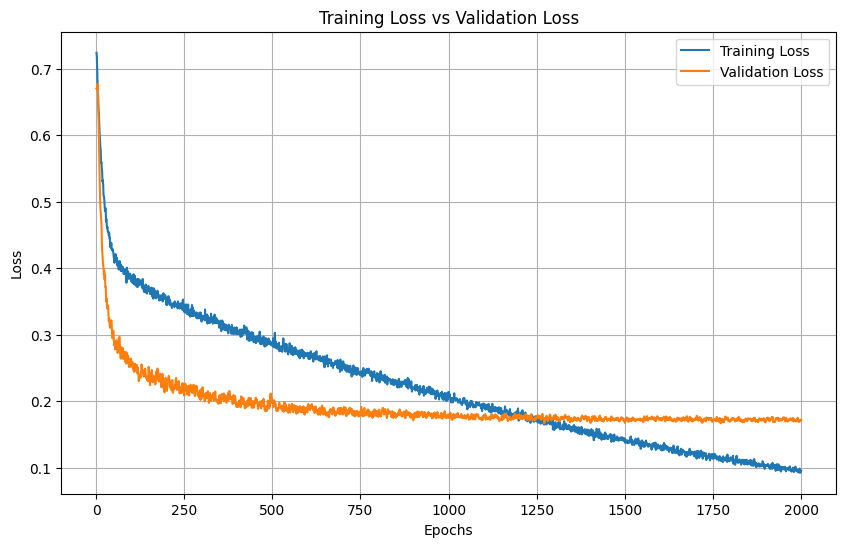

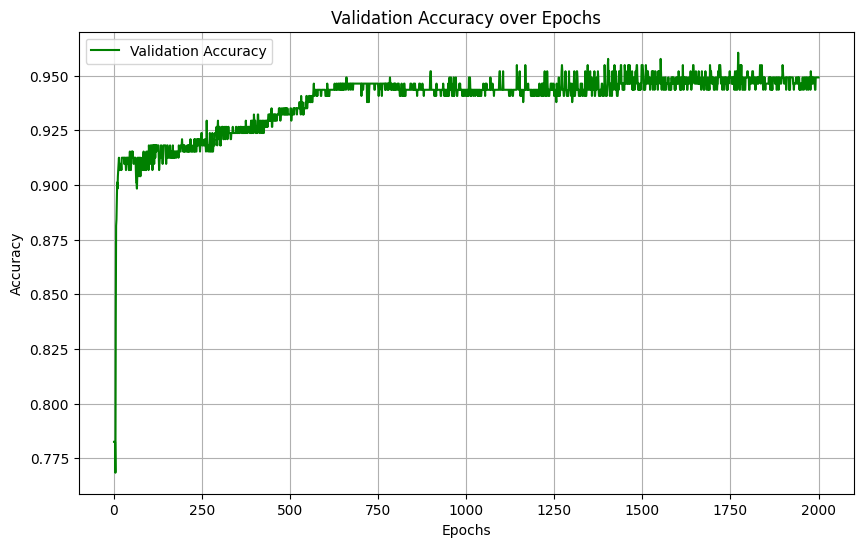

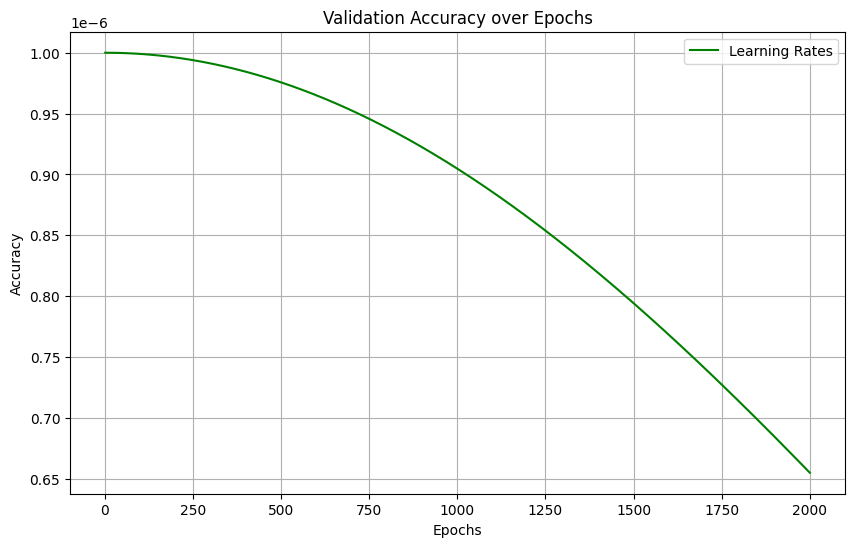

Model for bin 46 saved to GNN-5A_Exp2/model_bin_46.pth
Using 4 GPUs
Training on bin 47/50
Bin 47, Epoch 1/2000, Train Loss: 0.6866, Validation Loss: 0.6887,  Accuracy: 0.5584, LR: 0.000001
Bin 47, Epoch 101/2000, Train Loss: 0.3463, Validation Loss: 0.2580,  Accuracy: 0.8506, LR: 0.000001
Bin 47, Epoch 201/2000, Train Loss: 0.3139, Validation Loss: 0.2356,  Accuracy: 0.8636, LR: 0.000001
Bin 47, Epoch 301/2000, Train Loss: 0.2926, Validation Loss: 0.2180,  Accuracy: 0.8714, LR: 0.000001
Bin 47, Epoch 401/2000, Train Loss: 0.2679, Validation Loss: 0.2100,  Accuracy: 0.8896, LR: 0.000001
Bin 47, Epoch 501/2000, Train Loss: 0.2487, Validation Loss: 0.2071,  Accuracy: 0.9143, LR: 0.000001
Bin 47, Epoch 601/2000, Train Loss: 0.2282, Validation Loss: 0.2011,  Accuracy: 0.9143, LR: 0.000001
Bin 47, Epoch 701/2000, Train Loss: 0.2115, Validation Loss: 0.1982,  Accuracy: 0.9260, LR: 0.000001
Bin 47, Epoch 801/2000, Train Loss: 0.1882, Validation Loss: 0.2023,  Accuracy: 0.9390, LR: 0.000001
Bin

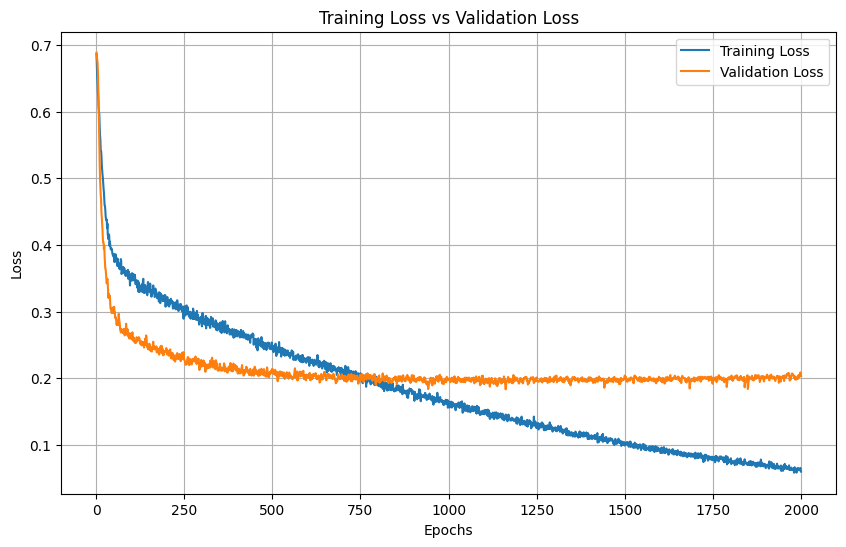

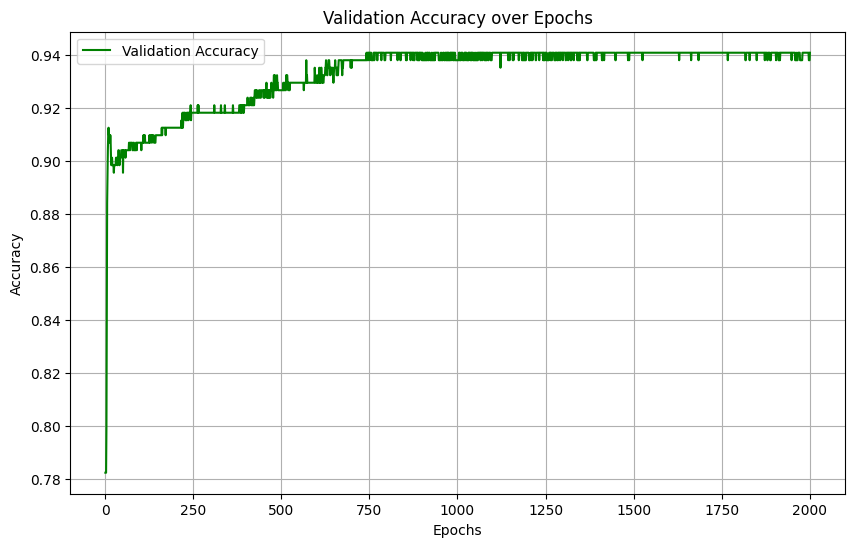

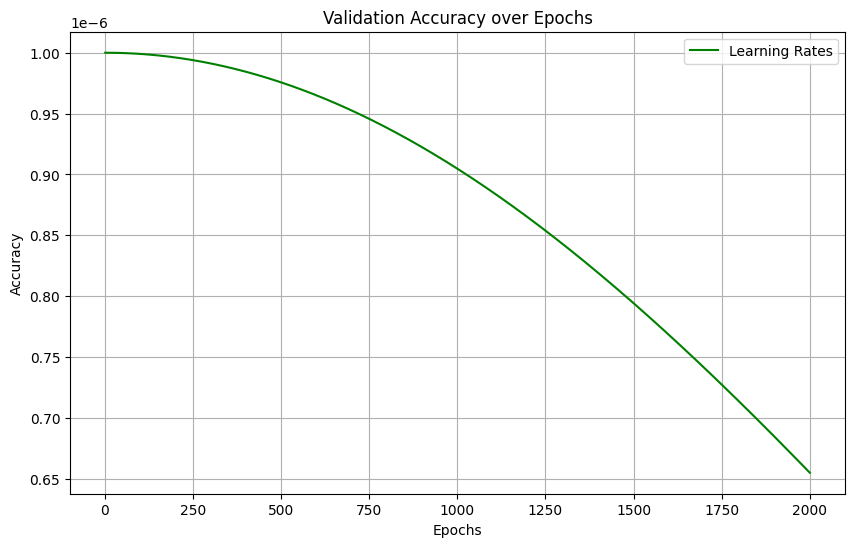

Model for bin 47 saved to GNN-5A_Exp2/model_bin_47.pth
Using 4 GPUs
Training on bin 48/50
Bin 48, Epoch 1/2000, Train Loss: 0.6729, Validation Loss: 0.7197,  Accuracy: 0.5896, LR: 0.000001
Bin 48, Epoch 101/2000, Train Loss: 0.3755, Validation Loss: 0.2575,  Accuracy: 0.8416, LR: 0.000001
Bin 48, Epoch 201/2000, Train Loss: 0.3364, Validation Loss: 0.2358,  Accuracy: 0.8571, LR: 0.000001
Bin 48, Epoch 301/2000, Train Loss: 0.3183, Validation Loss: 0.2192,  Accuracy: 0.8714, LR: 0.000001
Bin 48, Epoch 401/2000, Train Loss: 0.2923, Validation Loss: 0.2119,  Accuracy: 0.8857, LR: 0.000001
Bin 48, Epoch 501/2000, Train Loss: 0.2828, Validation Loss: 0.2141,  Accuracy: 0.8922, LR: 0.000001
Bin 48, Epoch 601/2000, Train Loss: 0.2586, Validation Loss: 0.2013,  Accuracy: 0.9026, LR: 0.000001
Bin 48, Epoch 701/2000, Train Loss: 0.2500, Validation Loss: 0.1988,  Accuracy: 0.9065, LR: 0.000001
Bin 48, Epoch 801/2000, Train Loss: 0.2329, Validation Loss: 0.1953,  Accuracy: 0.9065, LR: 0.000001
Bin

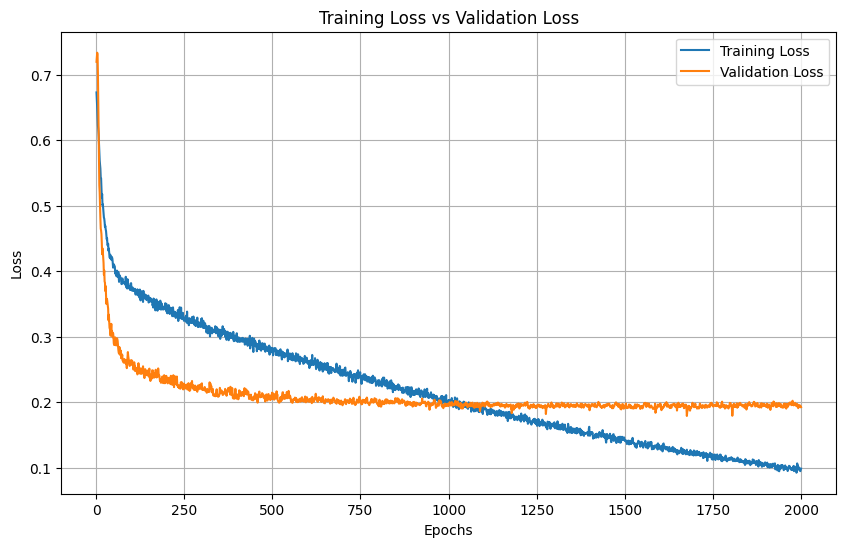

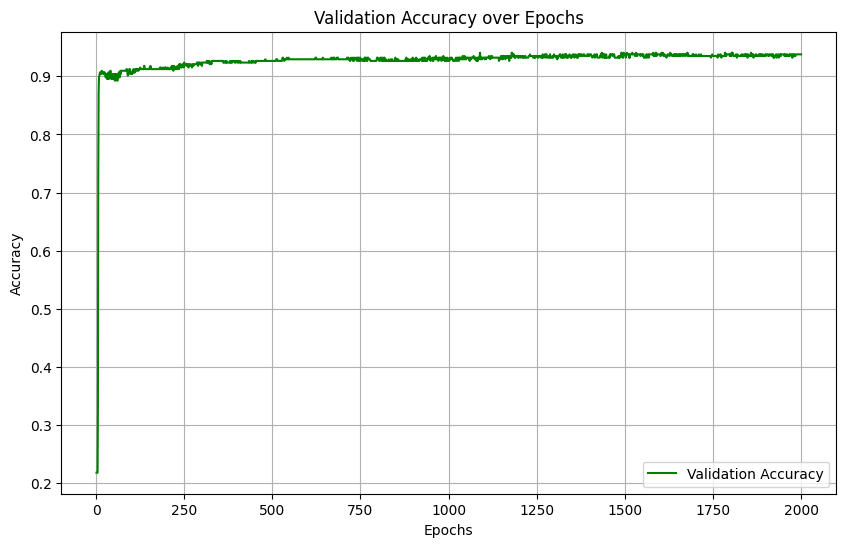

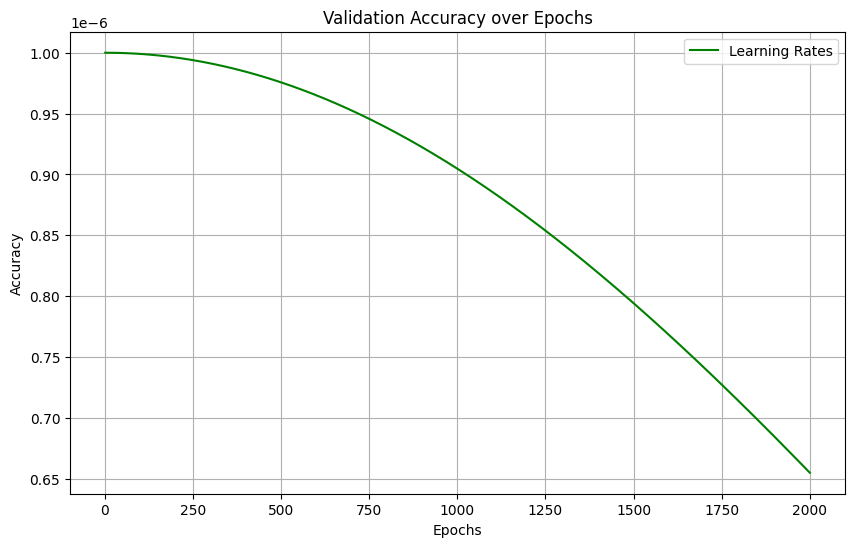

Model for bin 48 saved to GNN-5A_Exp2/model_bin_48.pth
Using 4 GPUs
Training on bin 49/50
Bin 49, Epoch 1/2000, Train Loss: 0.7156, Validation Loss: 0.6828,  Accuracy: 0.4649, LR: 0.000001
Bin 49, Epoch 101/2000, Train Loss: 0.3745, Validation Loss: 0.2565,  Accuracy: 0.8442, LR: 0.000001
Bin 49, Epoch 201/2000, Train Loss: 0.3306, Validation Loss: 0.2398,  Accuracy: 0.8675, LR: 0.000001
Bin 49, Epoch 301/2000, Train Loss: 0.3056, Validation Loss: 0.2185,  Accuracy: 0.8792, LR: 0.000001
Bin 49, Epoch 401/2000, Train Loss: 0.2829, Validation Loss: 0.2214,  Accuracy: 0.8896, LR: 0.000001
Bin 49, Epoch 501/2000, Train Loss: 0.2676, Validation Loss: 0.2107,  Accuracy: 0.9000, LR: 0.000001
Bin 49, Epoch 601/2000, Train Loss: 0.2402, Validation Loss: 0.2014,  Accuracy: 0.9078, LR: 0.000001
Bin 49, Epoch 701/2000, Train Loss: 0.2248, Validation Loss: 0.2076,  Accuracy: 0.9156, LR: 0.000001
Bin 49, Epoch 801/2000, Train Loss: 0.2102, Validation Loss: 0.2060,  Accuracy: 0.9169, LR: 0.000001
Bin

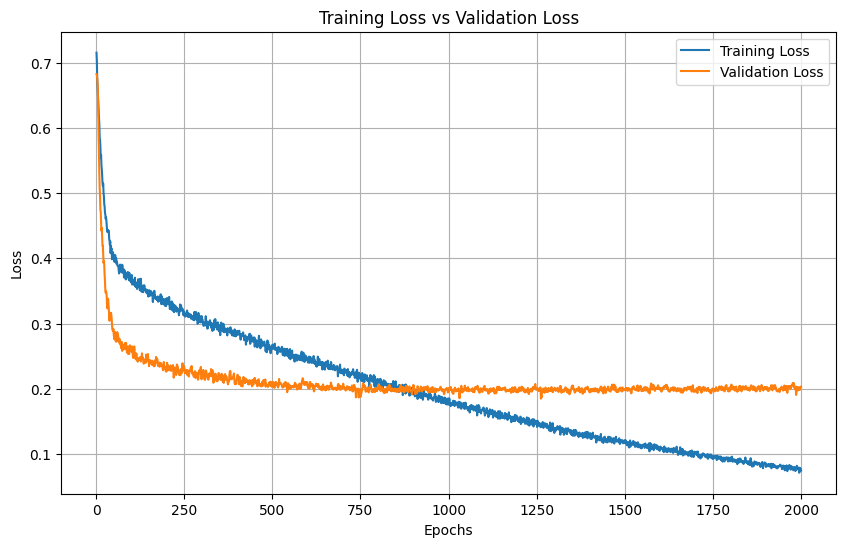

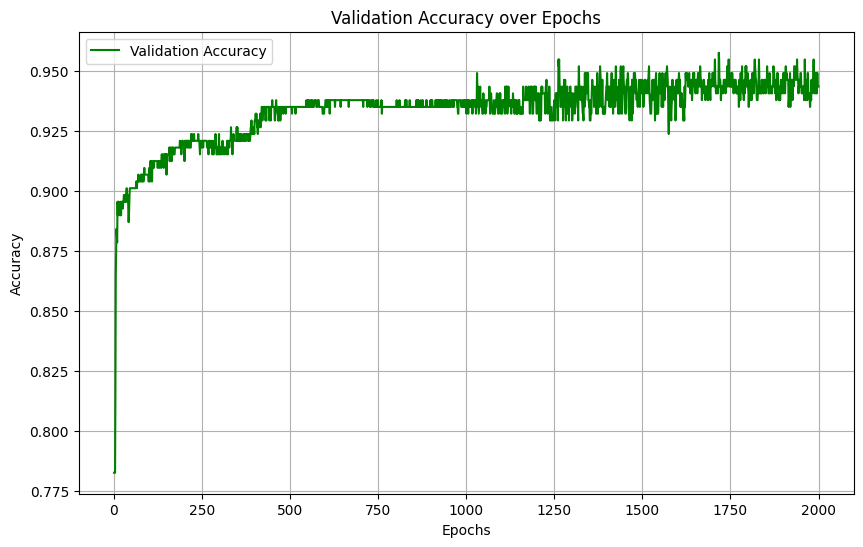

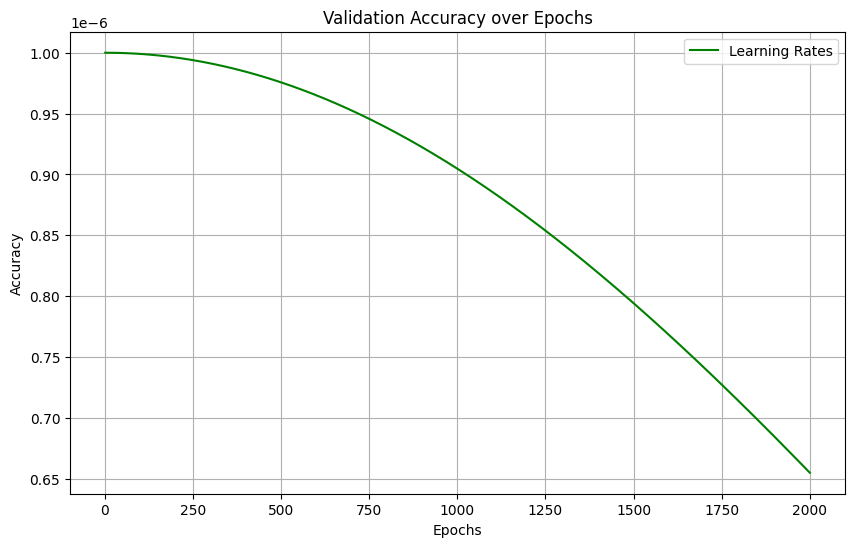

Model for bin 49 saved to GNN-5A_Exp2/model_bin_49.pth
Using 4 GPUs
Training on bin 50/50
Bin 50, Epoch 1/2000, Train Loss: 0.6935, Validation Loss: 0.6976,  Accuracy: 0.5234, LR: 0.000001
Bin 50, Epoch 101/2000, Train Loss: 0.3956, Validation Loss: 0.2441,  Accuracy: 0.8182, LR: 0.000001
Bin 50, Epoch 201/2000, Train Loss: 0.3513, Validation Loss: 0.2229,  Accuracy: 0.8455, LR: 0.000001
Bin 50, Epoch 301/2000, Train Loss: 0.3234, Validation Loss: 0.2085,  Accuracy: 0.8675, LR: 0.000001
Bin 50, Epoch 401/2000, Train Loss: 0.3011, Validation Loss: 0.2066,  Accuracy: 0.8805, LR: 0.000001
Bin 50, Epoch 501/2000, Train Loss: 0.2739, Validation Loss: 0.2021,  Accuracy: 0.8896, LR: 0.000001
Bin 50, Epoch 601/2000, Train Loss: 0.2670, Validation Loss: 0.2052,  Accuracy: 0.9000, LR: 0.000001
Bin 50, Epoch 701/2000, Train Loss: 0.2485, Validation Loss: 0.1887,  Accuracy: 0.9117, LR: 0.000001
Bin 50, Epoch 801/2000, Train Loss: 0.2331, Validation Loss: 0.1901,  Accuracy: 0.9143, LR: 0.000001
Bin

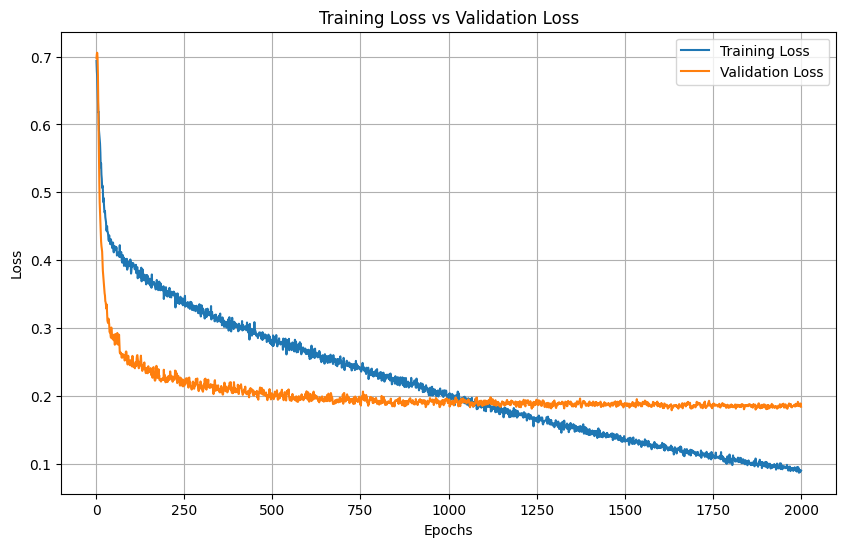

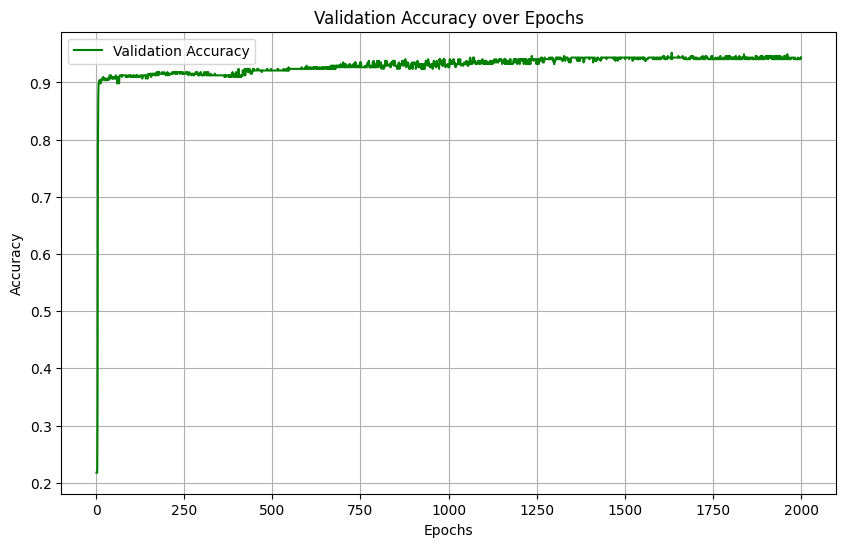

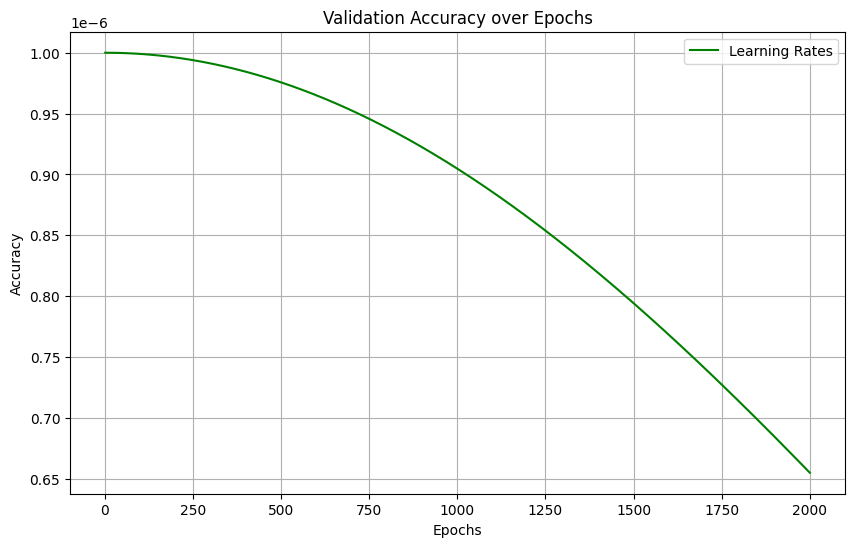

Model for bin 50 saved to GNN-5A_Exp2/model_bin_50.pth
Training complete.


In [14]:
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
criterion = nn.BCEWithLogitsLoss()

# Define paths for saving models
save_dir = "GNN-5A_Exp2"
os.makedirs(save_dir, exist_ok=True)

# Training loop
epochs = 2000
batch_size = 128

# keep 10 positives and 10 negatives for validation data
validation_dataset = GridDataset(validation_grids)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

for i in range(0, len(bins)):
    model = CNN2D(input_channels=1).to(device)
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)
    optimizer = optim.Adam(model.parameters(), lr=0.000001, weight_decay=1e-4) 
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5000, eta_min=1e-10)

    print(f"Training on bin {i+1}/{len(bins)}")
    dataset = GridDataset(bins[i])
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    train_losses = []
    learning_rates = []
    validation_losses = []
    validation_accuracies = []

    best_val_loss = float("inf")
    best_model_state = None

    for epoch in range(epochs):
        epoch_loss, accuracy = train_model(model, dataloader, criterion, optimizer, device)
        validation_loss, validation_accuracy = validate_model(model, validation_dataloader, criterion, device)
        current_lr = optimizer.param_groups[0]['lr'] 
        train_losses.append(epoch_loss)
        learning_rates.append(current_lr)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)   
        if epoch % 100 == 0:
            print(
                f"Bin {i+1}, Epoch {epoch+1}/{epochs}, "
                f"Train Loss: {epoch_loss:.4f}, Validation Loss: {validation_loss:.4f},  "
                f"Accuracy: {accuracy:.4f}, "
                f"LR: {current_lr:.6f}"
            )

        if validation_loss < best_val_loss:
            best_val_loss = validation_loss
            best_model_state = model.state_dict()
        scheduler.step()

    plot_graphs(train_losses, validation_losses, validation_accuracies, learning_rates)
    
    #Save the trained model
    model_path = os.path.join(save_dir, f"model_bin_{i+1}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model for bin {i+1} saved to {model_path}")


print("Training complete.")

